# Aprendizado de máquina para análise de tráfego de rede e detecção de intrusão

## Introdução

Este notebook contém a parte prática do trabalho de conclusão de curso de André Chierighini e Tiago Maldonado.

In [109]:
!pip install sweetviz mljar-supervised ipywidgets

In [110]:
import pandas as pd
import numpy as np
import sklearn
import sweetviz as sv
from supervised.automl import AutoML # mljar-supervised
from sklearn.metrics import accuracy_score, f1_score, log_loss, precision_score, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from ipywidgets import IntProgress

In [111]:
path_Train = "./KDDTrain+.txt"
path_Test = "./KDDTest+.txt"

## Leitura e adição de Headers 

In [112]:
df_train= pd.read_csv(path_Train,header=None)
df_test= pd.read_csv(path_Test,header=None)

In [113]:
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df_train.columns = columns
df_test.columns = columns

### Tratamento da variável categórica de ataque
Nesta parte, a variável categórica de ataque é transformada em 0 ou 1 indicando a presença de um ataque.
* 0 simboliza tráfego normal
* 1 simboliza tráfego inseguro

In [114]:
is_attack = df_train.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = df_test.attack.map(lambda a: 0 if a == 'normal' else 1)

df_train['attack_flag'] = is_attack
df_test['attack_flag'] = test_attack

df_train.head()

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_diff_srv_rate  \
0               0       0    0  ...                    0.03   
1               0       0    0  ...                    0.60   
2               0       0    0  ...                    0.05   
3               0       0    0  ...                    0.00   
4               0       0    0  ...                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                         0.88                         0.00   
2                         0.00                         0.00   
3                         0.03                         0.04   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                  0.05   
1                  0.00                      0.00                  0.00   
2                  1.00                      1.00                  0.00   
3                  0.03                      0.01                  0.00   
4                  0.00                      0.00                  0.00   

   dst_host_srv_rerror_rate   attack  level  attack_flag  
0                      0.00   normal     20            0  
1                      0.00   normal     15            0  
2                      0.00  neptune     19            1  
3                      0.01   normal     21            0  
4                      0.00   normal     21            0  

[5 rows x 44 columns]

## Normalização

In [115]:
df_train.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

### Transformação das variáveis categóricas em variáveis numéricas:

In [116]:
label_encoder = LabelEncoder()

In [117]:
cat_var = df_train['protocol_type']
num_var = label_encoder.fit_transform(cat_var)
df_train['protocol_type'] = num_var

cat_var = df_train['service']
num_var = label_encoder.fit_transform(cat_var)
df_train['service'] = num_var

cat_var = df_train['flag']
num_var = label_encoder.fit_transform(cat_var)
df_train['flag'] = num_var

cat_var = df_train['attack']
num_var = label_encoder.fit_transform(cat_var)
df_train['attack'] = num_var

df_train.head()

duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0         0              1       20     9        491          0     0   
1         0              2       44     9        146          0     0   
2         0              1       49     5          0          0     0   
3         0              1       24     9        232       8153     0   
4         0              1       24     9        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_diff_srv_rate  \
0               0       0    0  ...                    0.03   
1               0       0    0  ...                    0.60   
2               0       0    0  ...                    0.05   
3               0       0    0  ...                    0.00   
4               0       0    0  ...                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                         0.88                         0.00   
2                         0.00                         0.00   
3                         0.03                         0.04   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                  0.05   
1                  0.00                      0.00                  0.00   
2                  1.00                      1.00                  0.00   
3                  0.03                      0.01                  0.00   
4                  0.00                      0.00                  0.00   

   dst_host_srv_rerror_rate  attack  level  attack_flag  
0                      0.00      11     20            0  
1                      0.00      11     15            0  
2                      0.00       9     19            1  
3                      0.01      11     21            0  
4                      0.00      11     21            0  

[5 rows x 44 columns]

In [118]:
cat_var = df_test['protocol_type']
num_var = label_encoder.fit_transform(cat_var)
df_test['protocol_type'] = num_var

cat_var = df_test['service']
num_var = label_encoder.fit_transform(cat_var)
df_test['service'] = num_var

cat_var = df_test['flag']
num_var = label_encoder.fit_transform(cat_var)
df_test['flag'] = num_var

cat_var = df_test['attack']
num_var = label_encoder.fit_transform(cat_var)
df_test['attack'] = num_var

df_test.head()

duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0         0              1       45     1          0          0     0   
1         0              1       45     1          0          0     0   
2         2              1       19     9      12983          0     0   
3         0              0       13     9         20          0     0   
4         1              1       55     2          0         15     0   

   wrong_fragment  urgent  hot  ...  dst_host_diff_srv_rate  \
0               0       0    0  ...                    0.06   
1               0       0    0  ...                    0.06   
2               0       0    0  ...                    0.04   
3               0       0    0  ...                    0.00   
4               0       0    0  ...                    0.17   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.00                         0.00   
1                         0.00                         0.00   
2                         0.61                         0.02   
3                         1.00                         0.28   
4                         0.03                         0.02   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                  1.00   
1                   0.0                       0.0                  1.00   
2                   0.0                       0.0                  0.00   
3                   0.0                       0.0                  0.00   
4                   0.0                       0.0                  0.83   

   dst_host_srv_rerror_rate  attack  level  attack_flag  
0                      1.00      14     21            1  
1                      1.00      14     21            1  
2                      0.00      16     21            0  
3                      0.00      24     15            1  
4                      0.71      11     11            1  

[5 rows x 44 columns]

In [119]:
df_train.dtypes

duration                         int64
protocol_type                    int64
service                          int64
flag                             int64
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

## Seleção de colunas relevantes
Durante esta etapa foram selecionadas as colunas que contém informações relevantes para a determinação dos ataques.

As colunas significativas são:

same_srv_rate, dst_host_srv_count, dst_host_same_srv_rate,dst_host_srv_serror_rate, dst_host_serror_rate, serror_rate,dst_host_diff_srv_rate, diff_srv_rate, srv_diff_host_rate, service, flag,logged_in, srv_serror_rate, count, level, dst_host_count, srv_rerror_rate, dst_host_srv_rerror_rate, rerror_rate, dst_host_rerror_rate, attack_flag

In [120]:
df_del = df_train.drop(['same_srv_rate','dst_host_srv_count','dst_host_same_srv_rate','dst_host_srv_serror_rate','service','flag','logged_in','dst_host_serror_rate','serror_rate','dst_host_diff_srv_rate','diff_srv_rate','srv_diff_host_rate','srv_serror_rate','count','level','dst_host_count','srv_rerror_rate','dst_host_srv_rerror_rate','rerror_rate','dst_host_rerror_rate'],axis=1)

In [121]:
cor_ananlysis = sv.analyze(df_train,target_feat='attack_flag')

                                             |          | [  0%]   00:00 -> (? left)


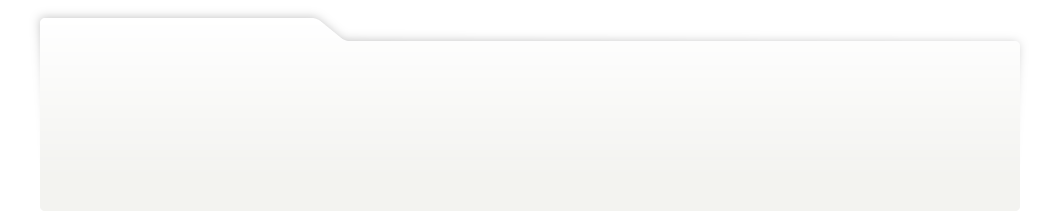
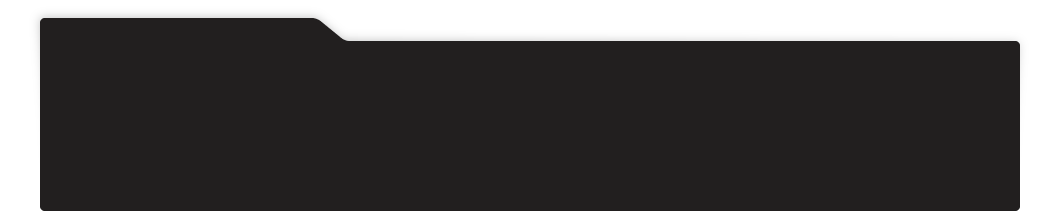
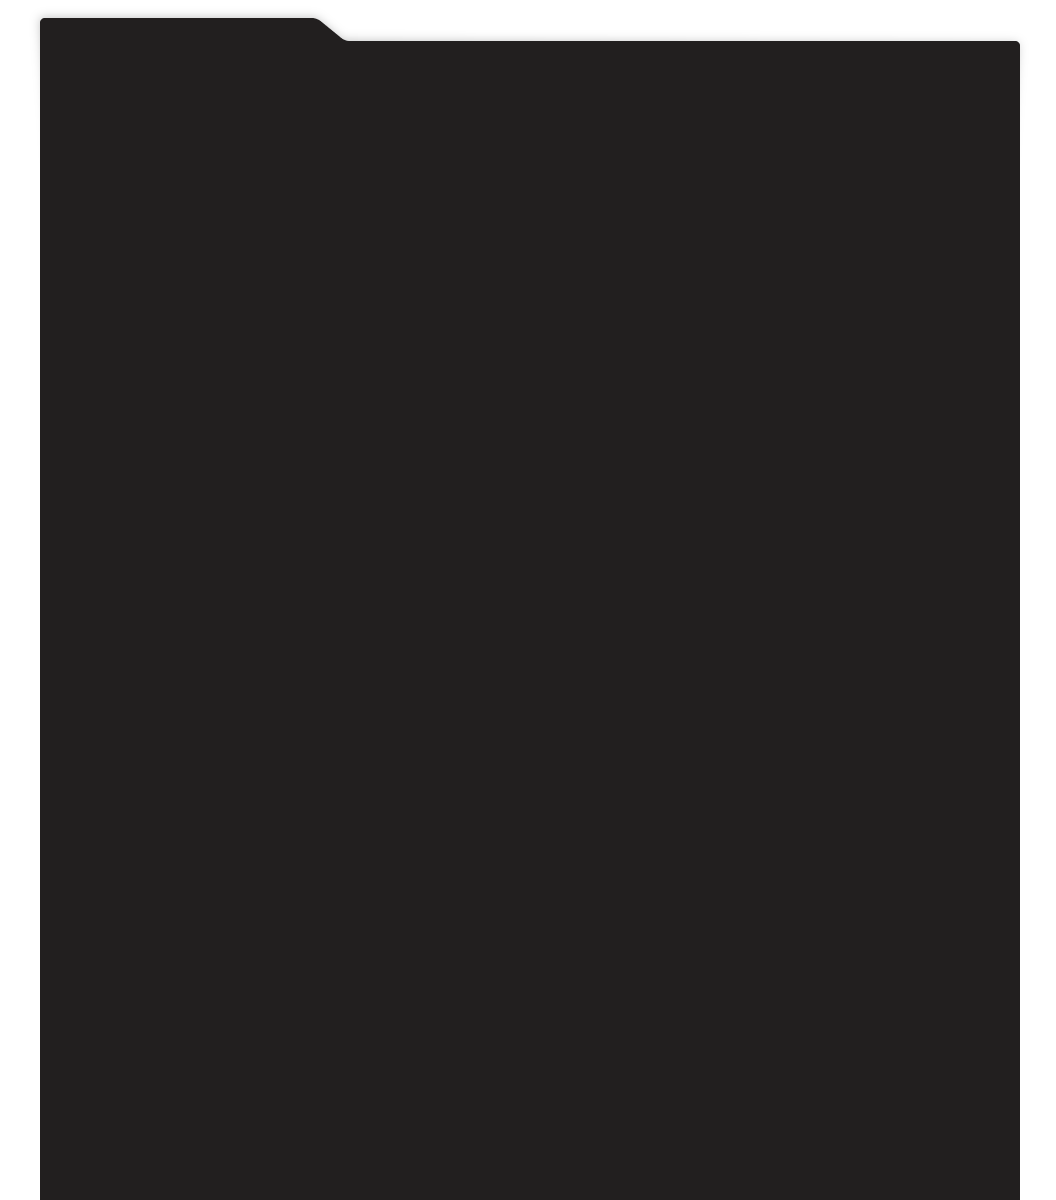
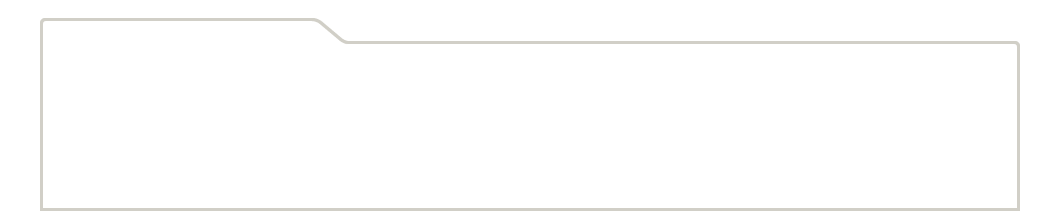
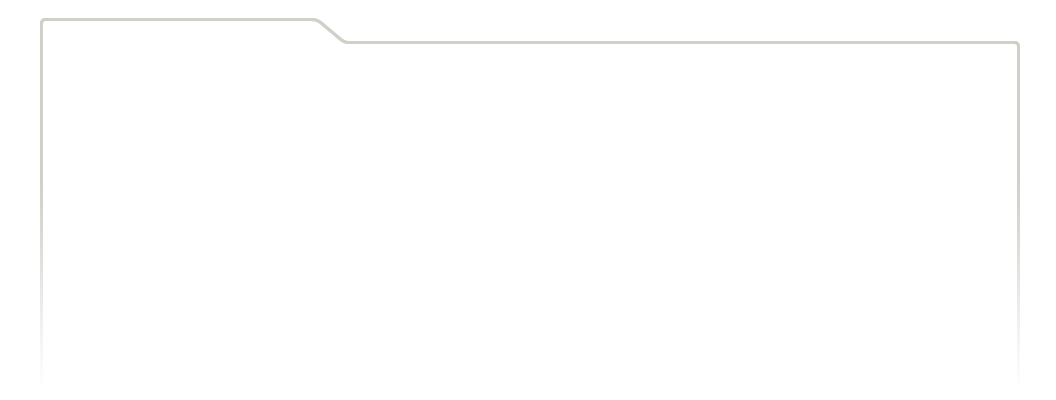
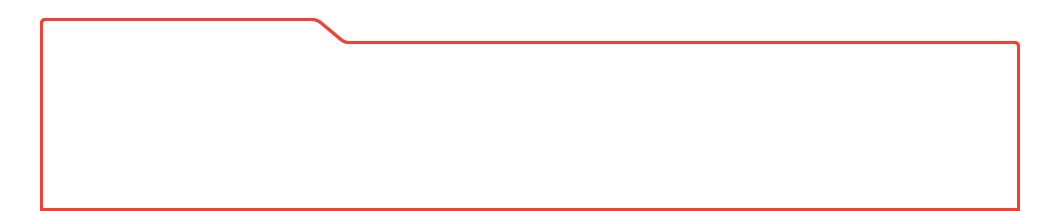
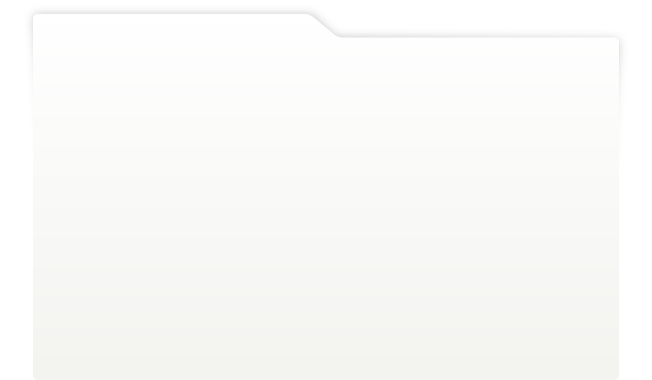
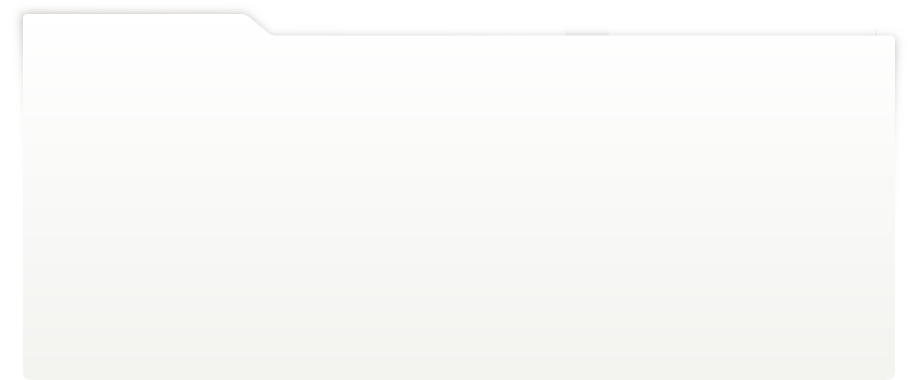
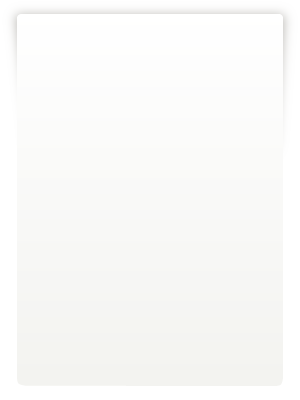
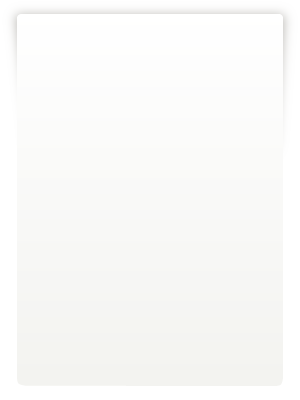
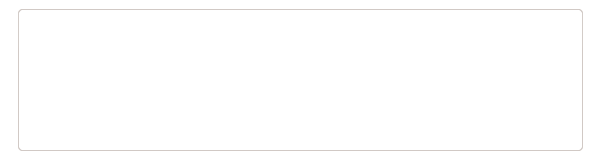
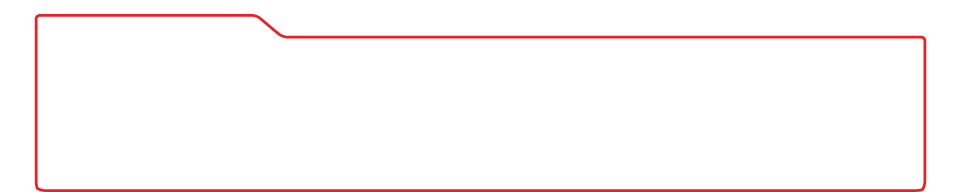
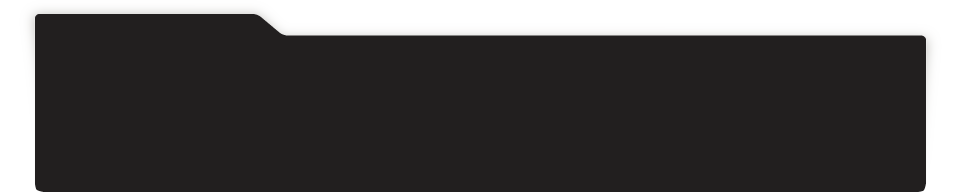
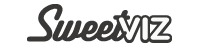
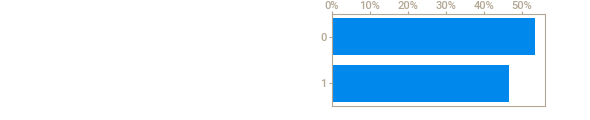
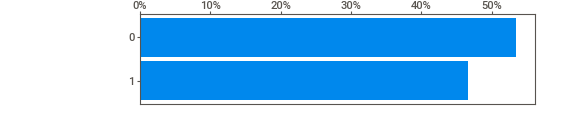
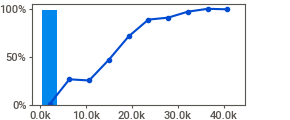
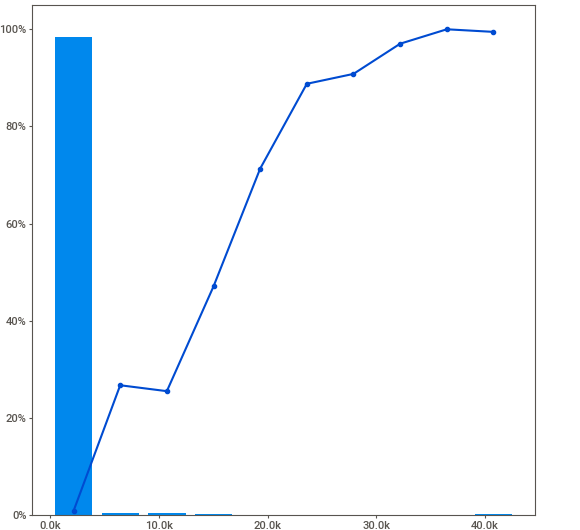
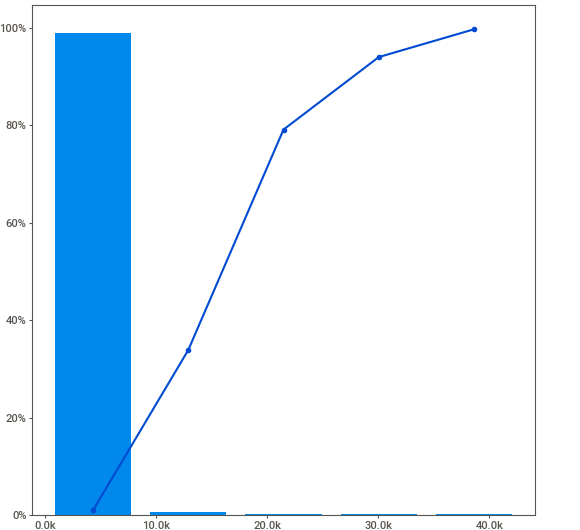
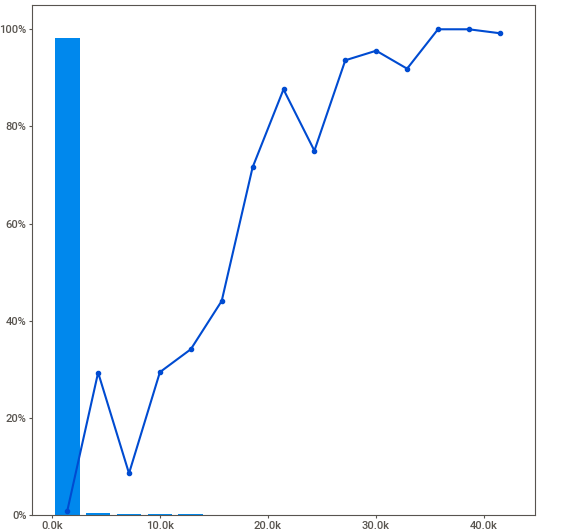
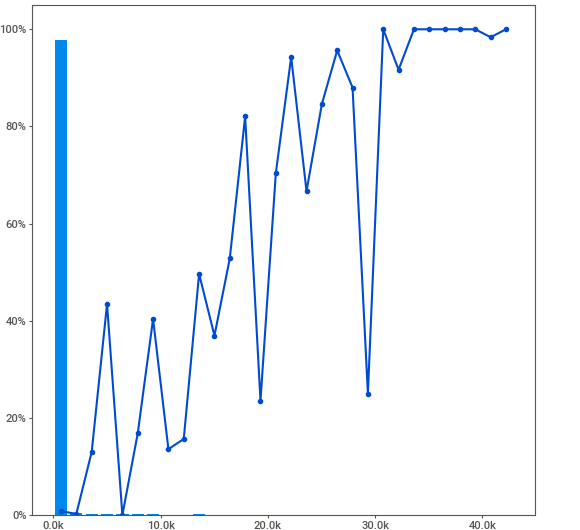
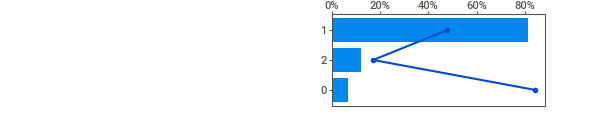
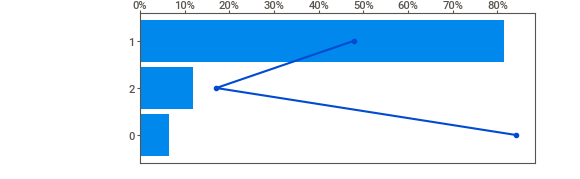
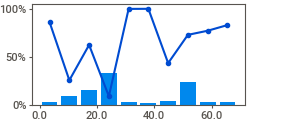
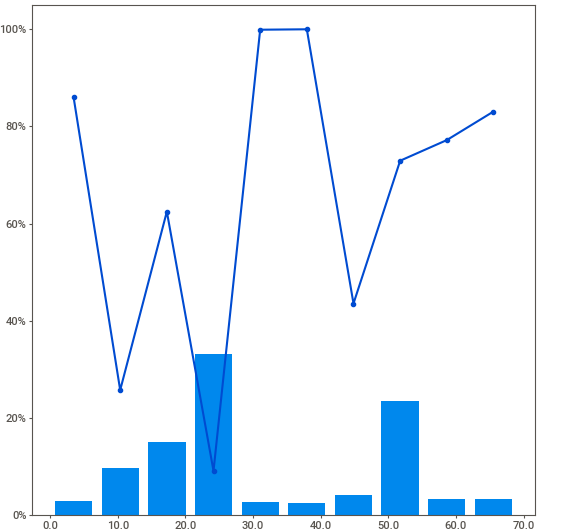
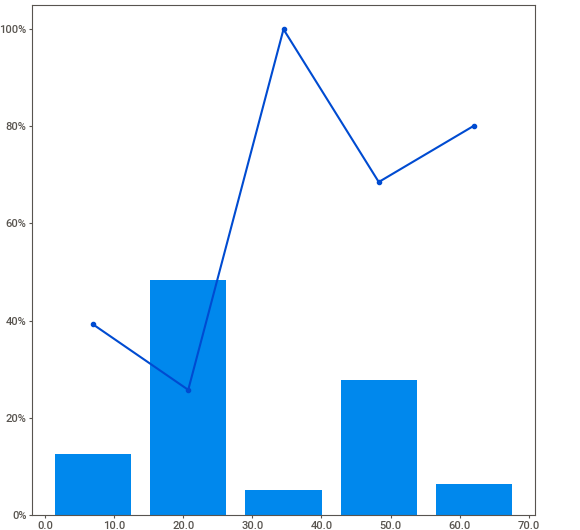
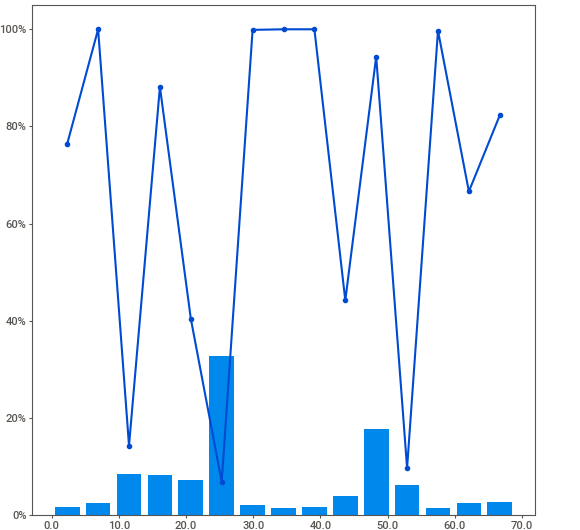
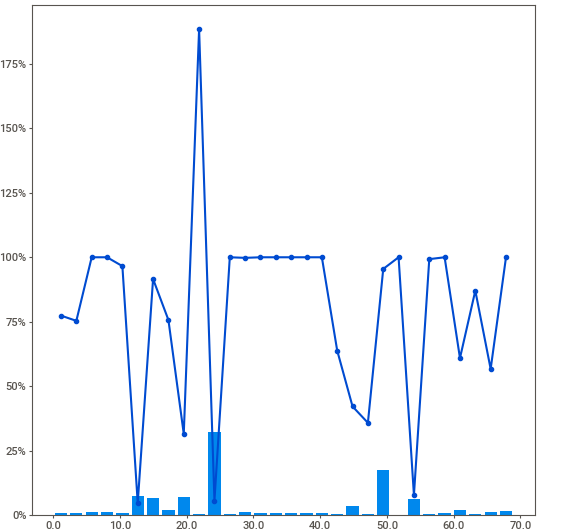
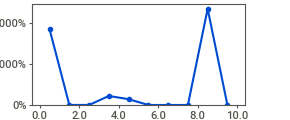
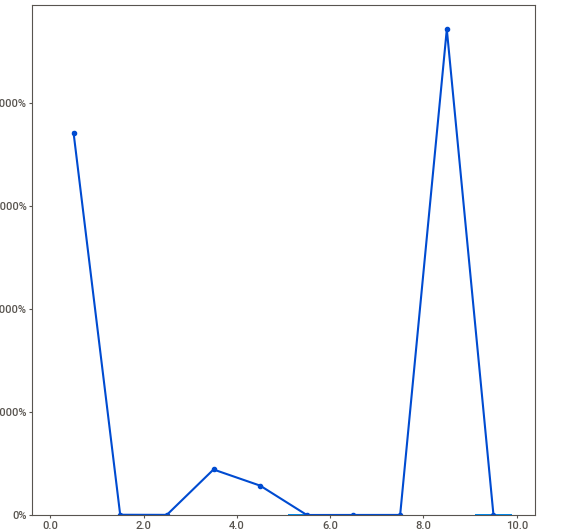
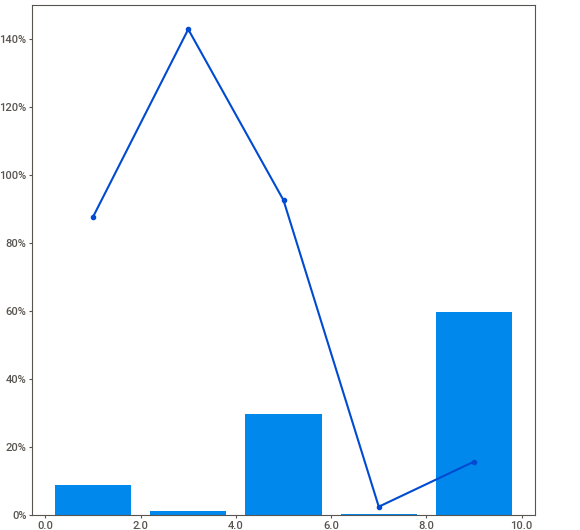
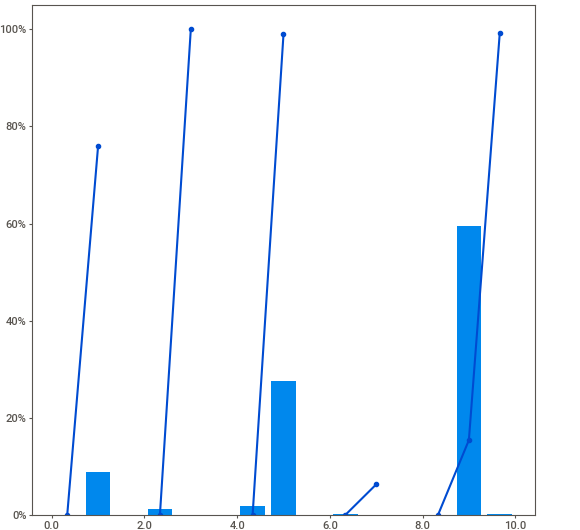
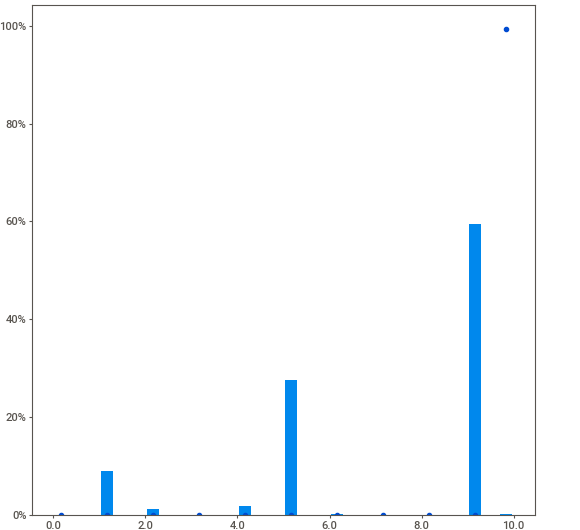
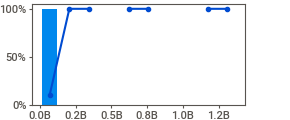
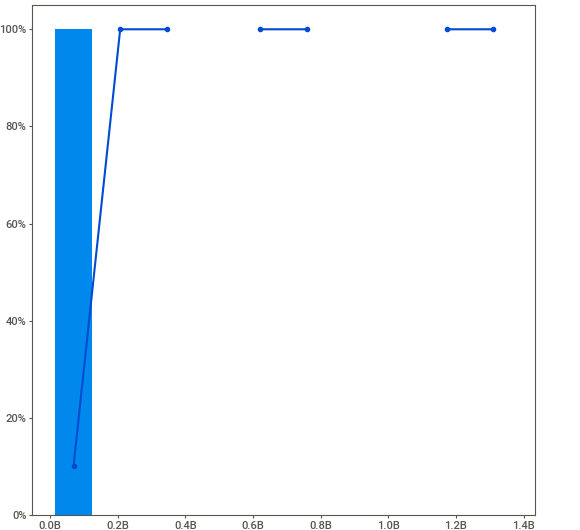
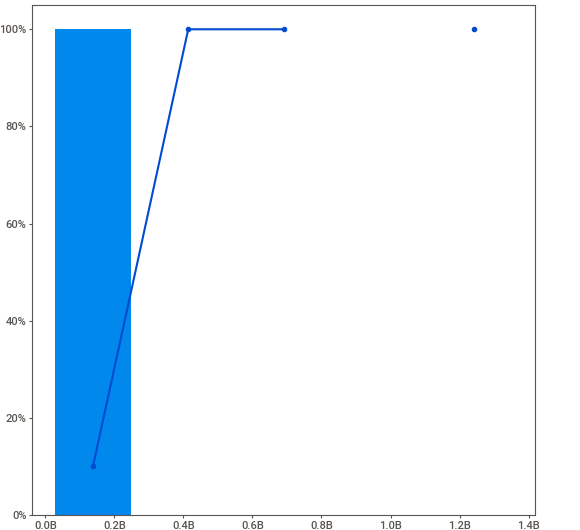
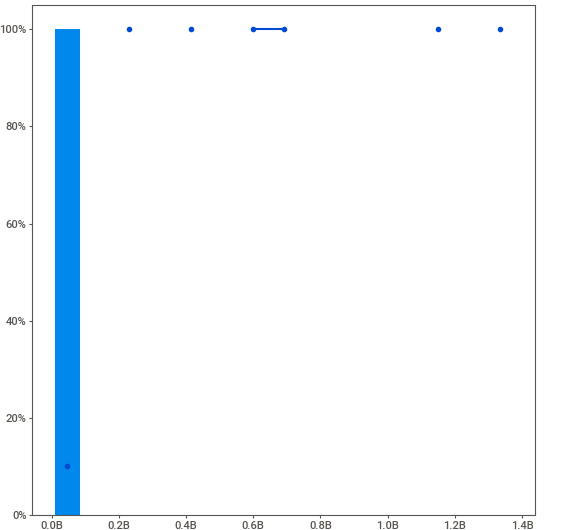
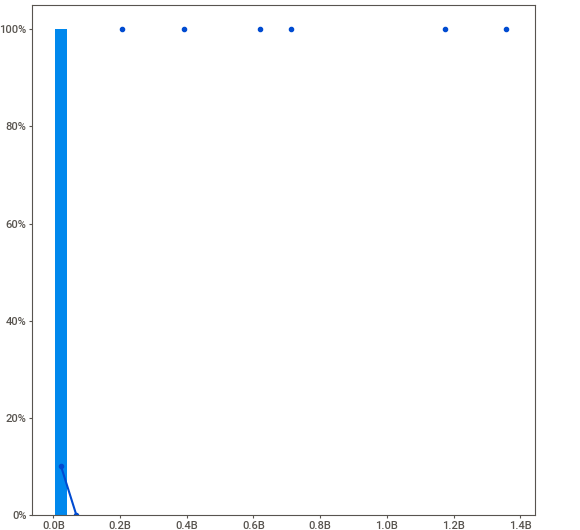
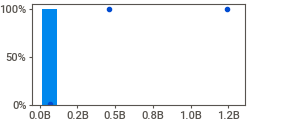
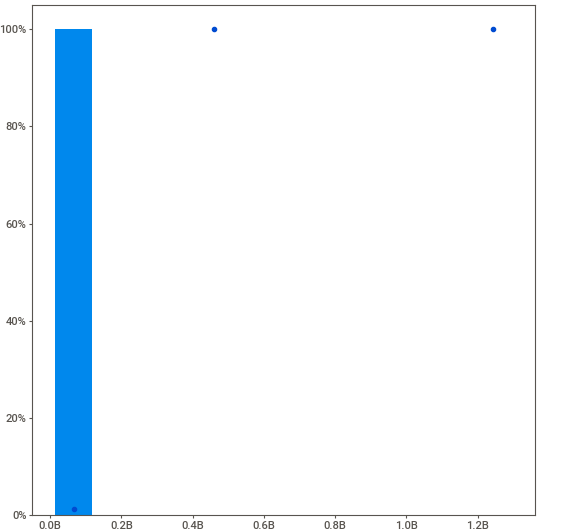
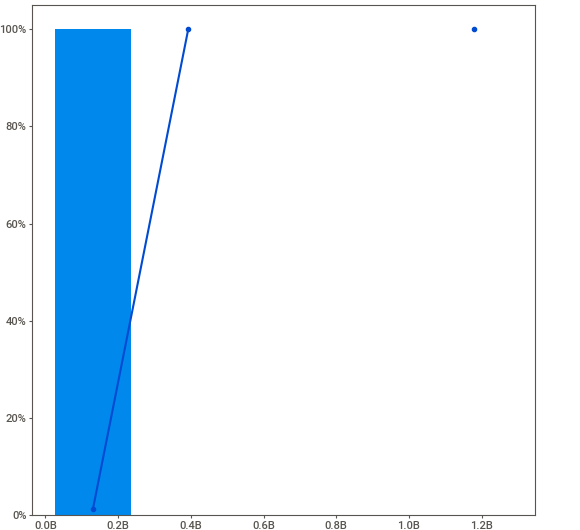
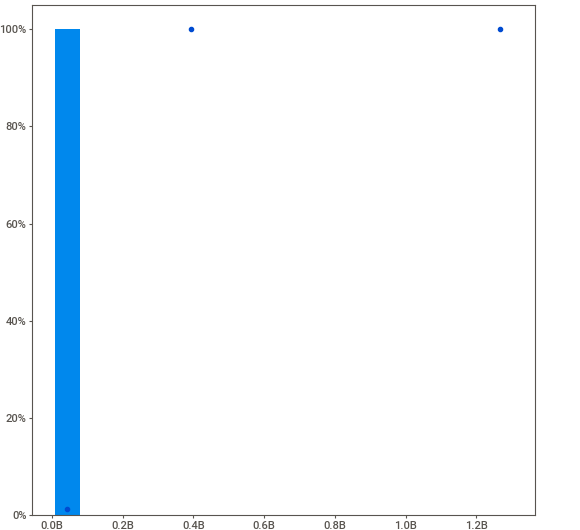
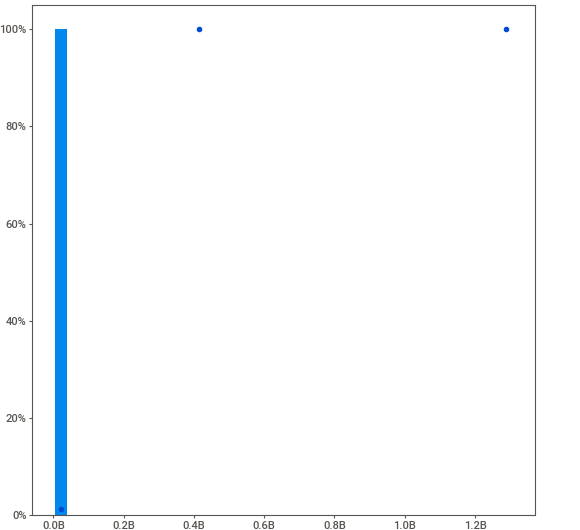
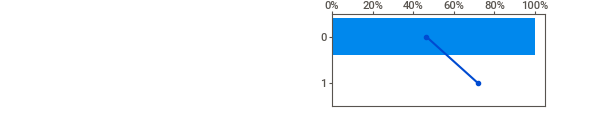
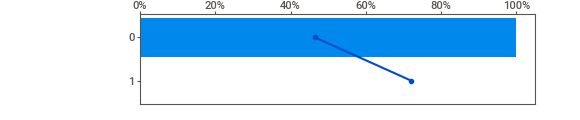
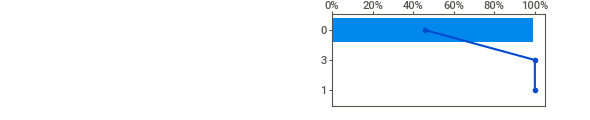
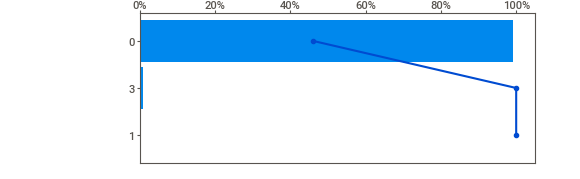
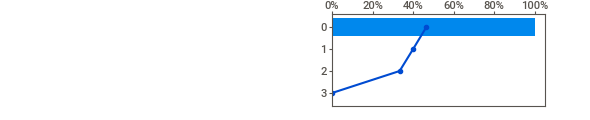
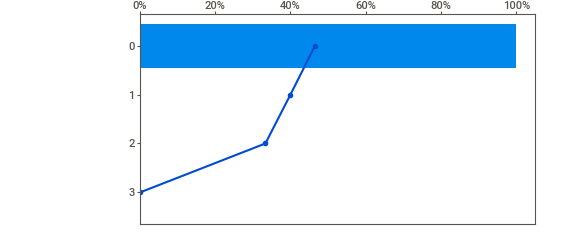
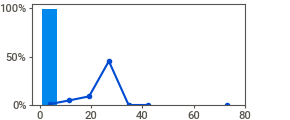
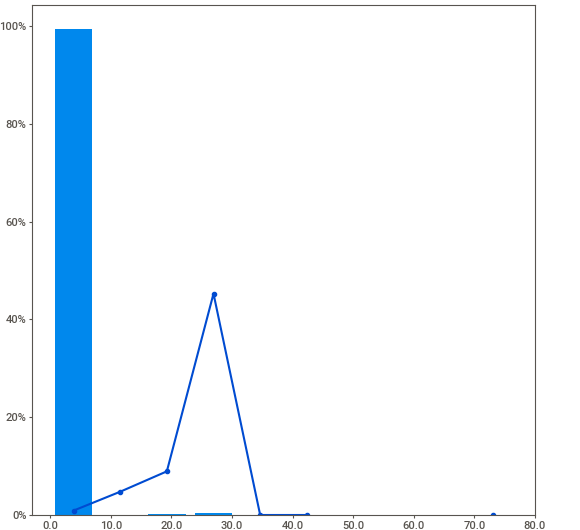
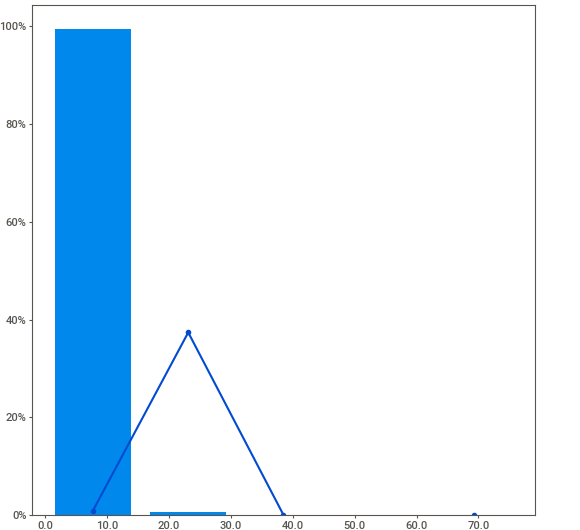
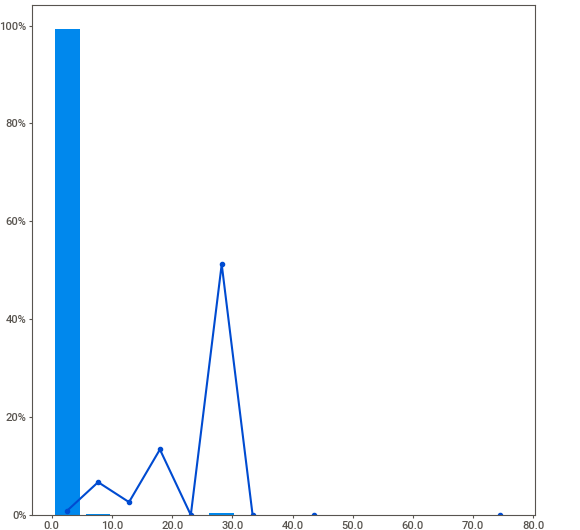
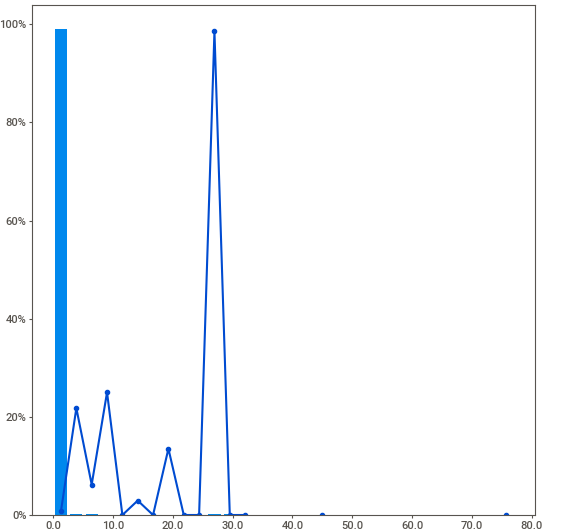
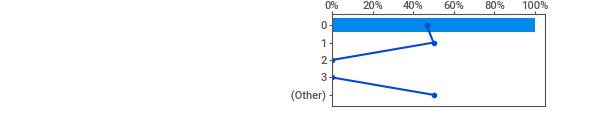
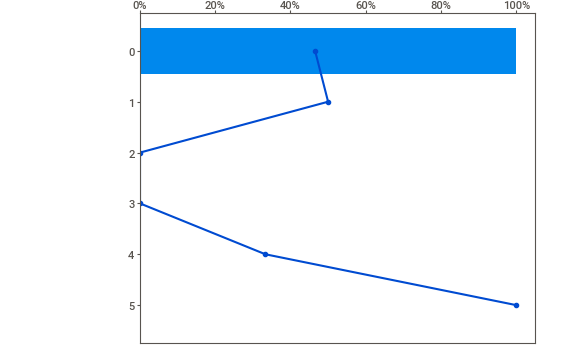
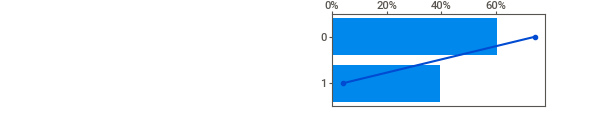
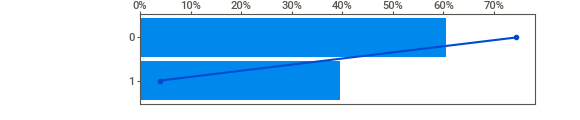
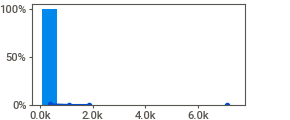
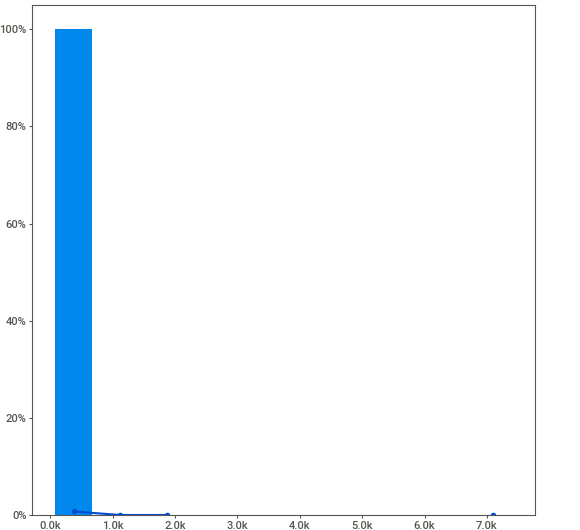
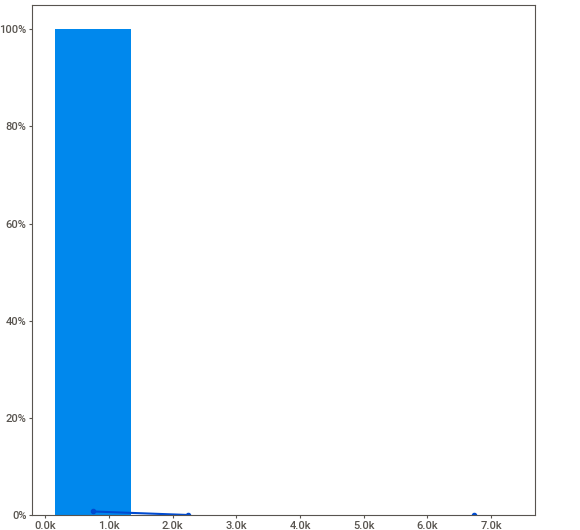
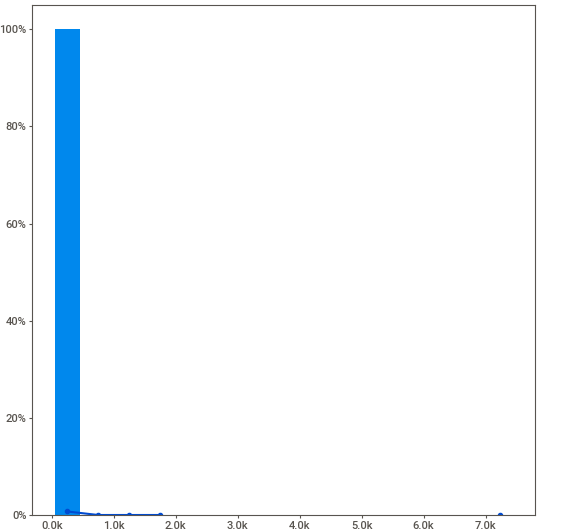
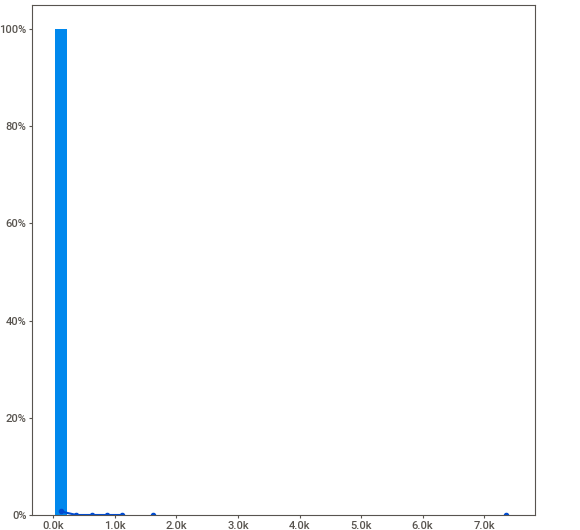
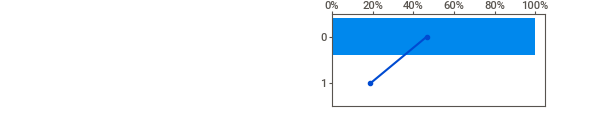
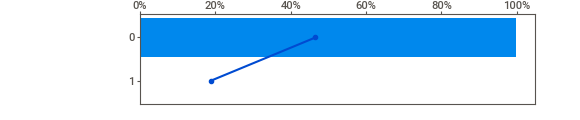
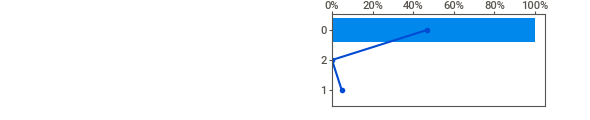
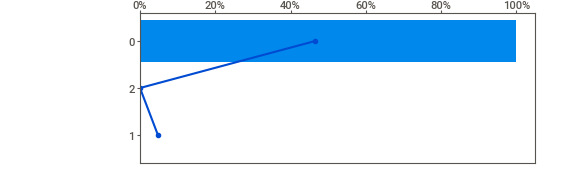
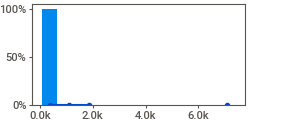
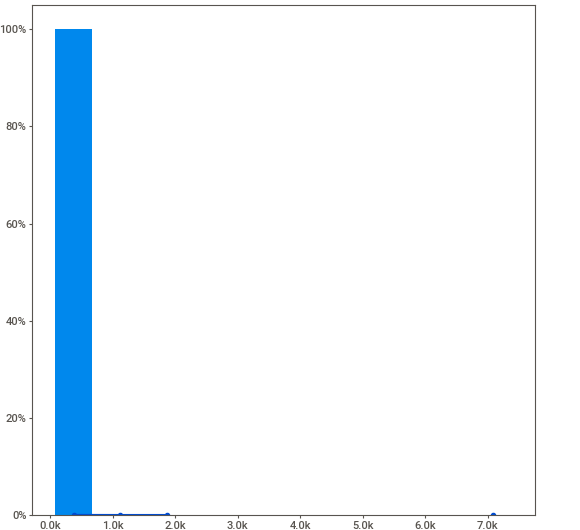
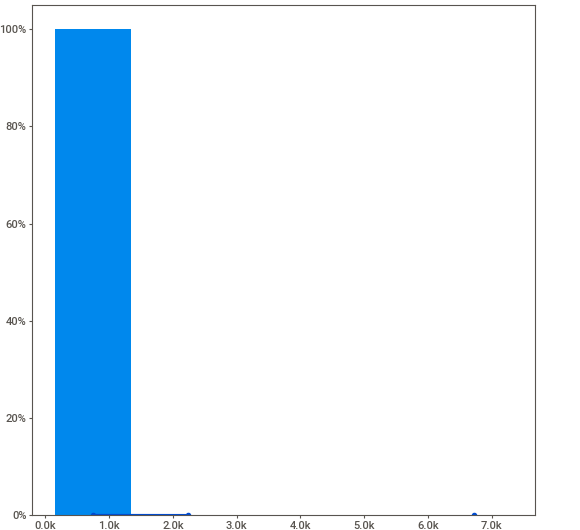
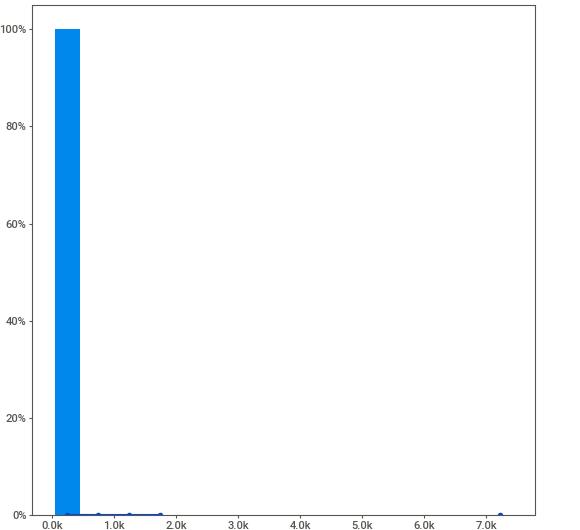
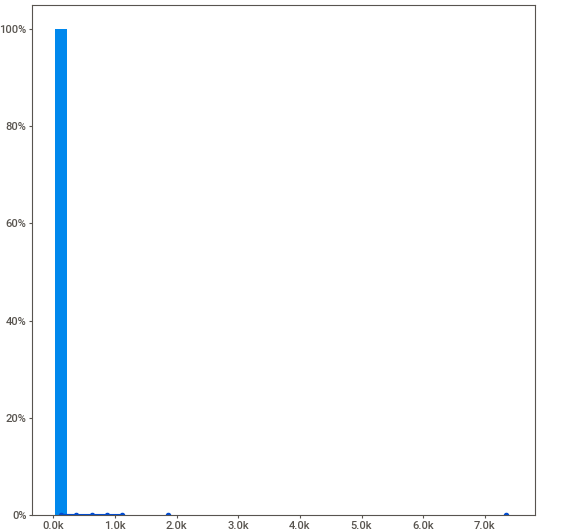
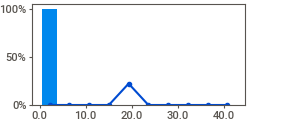
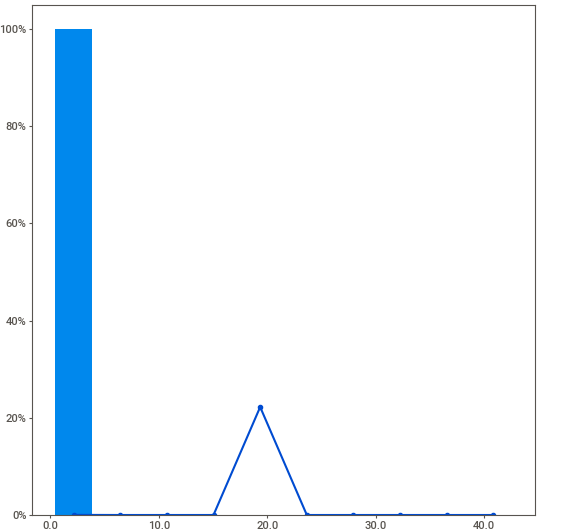
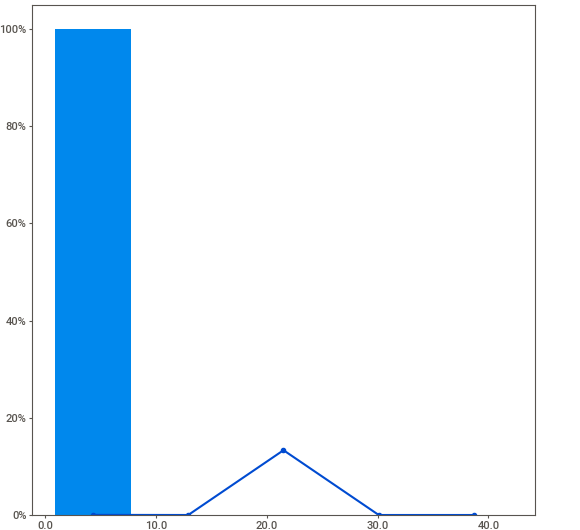
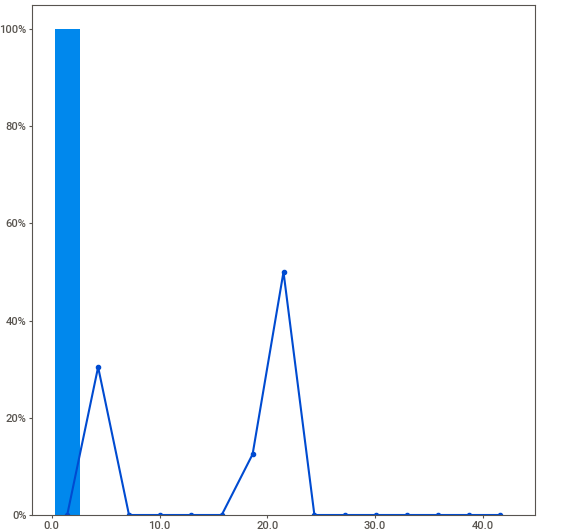
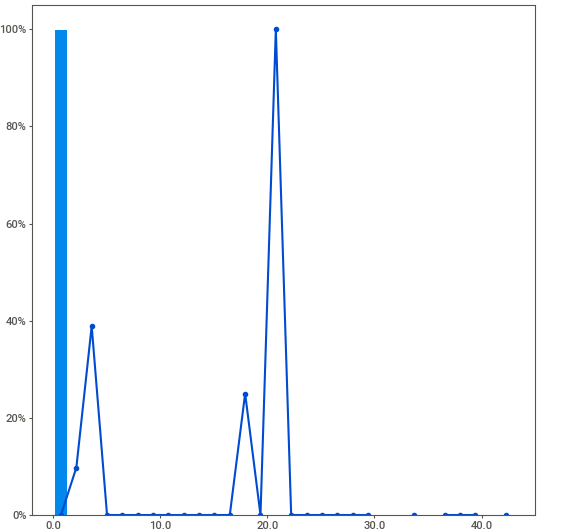
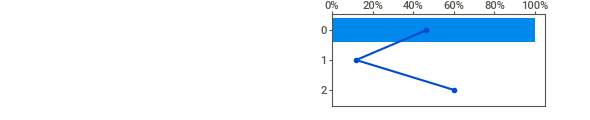
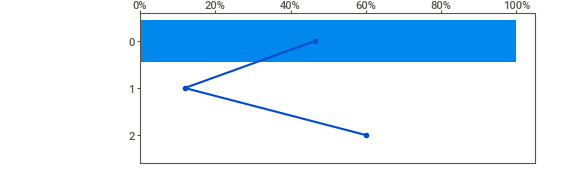
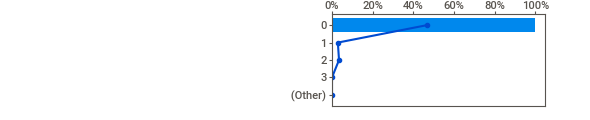
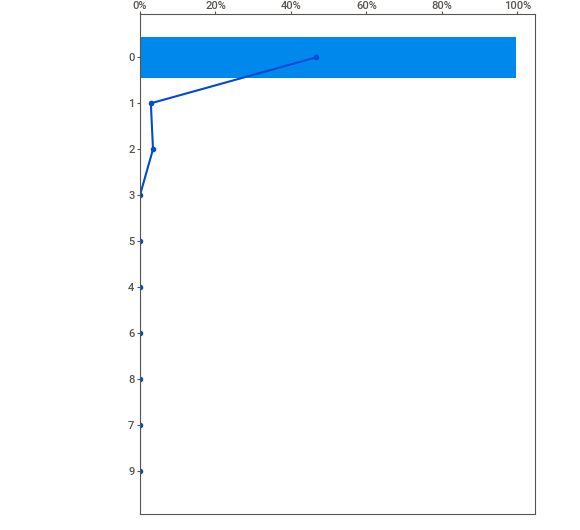
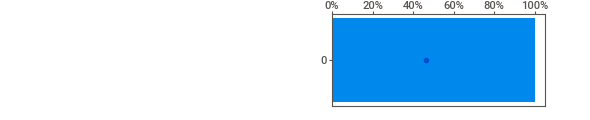
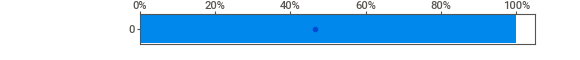
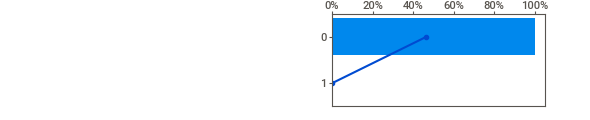
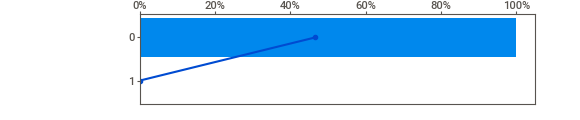
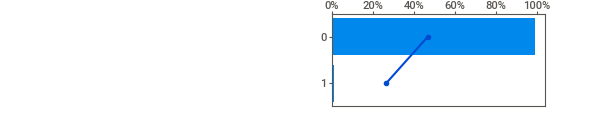
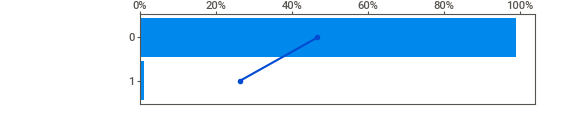
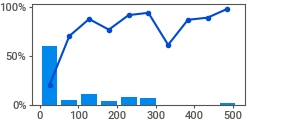
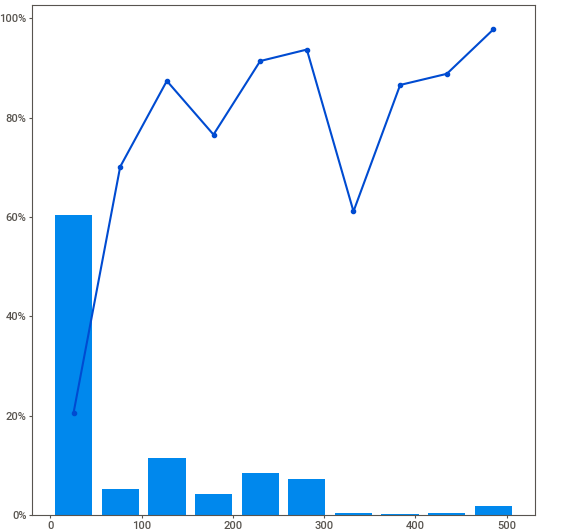
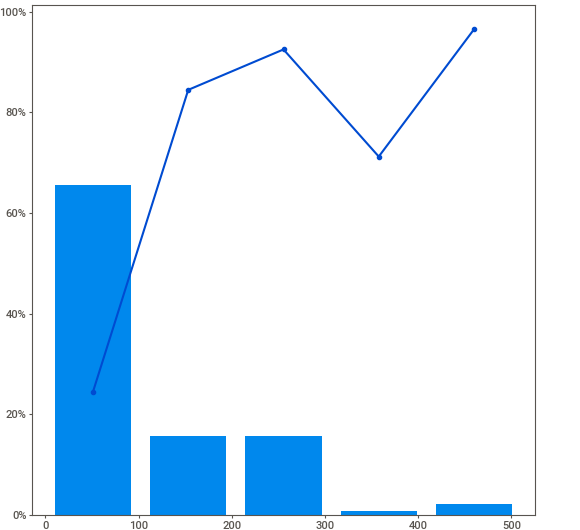
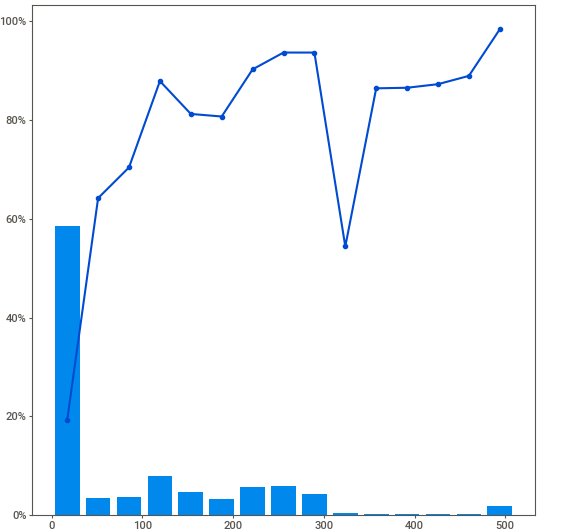
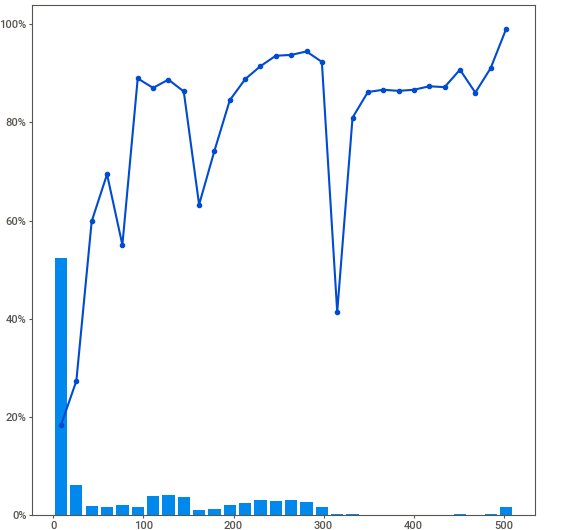
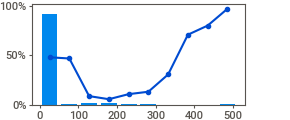
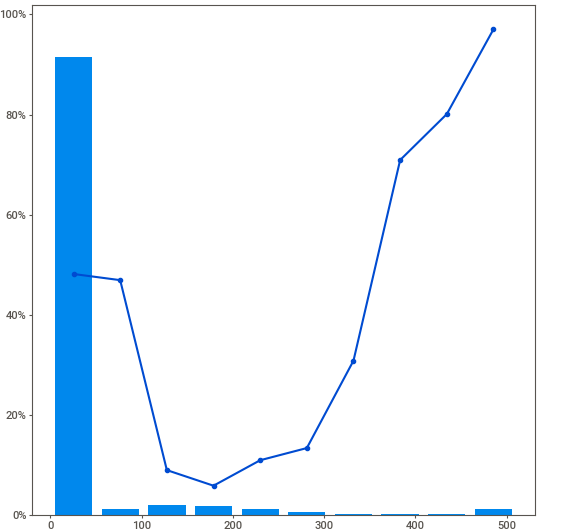
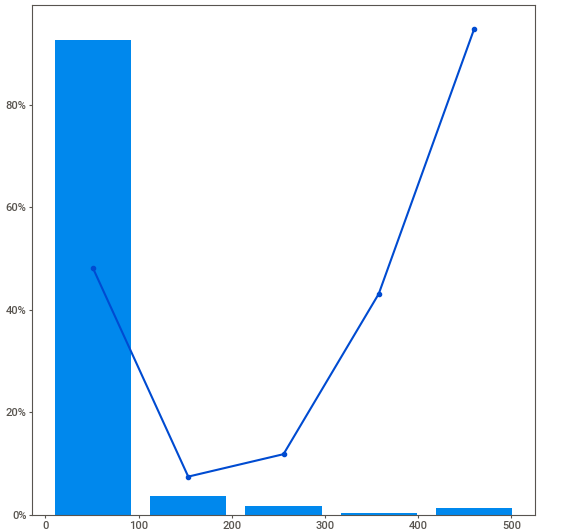
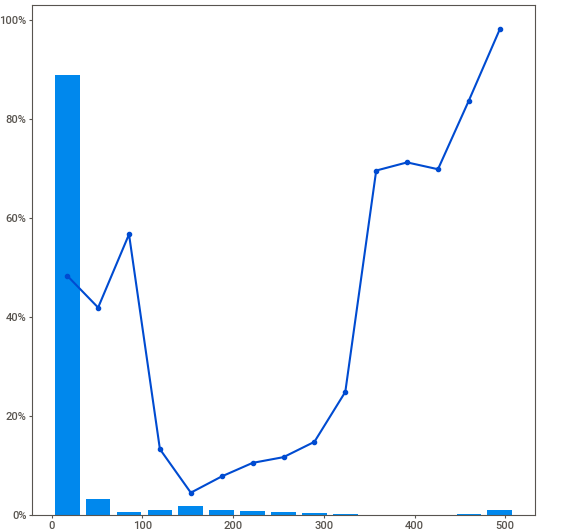
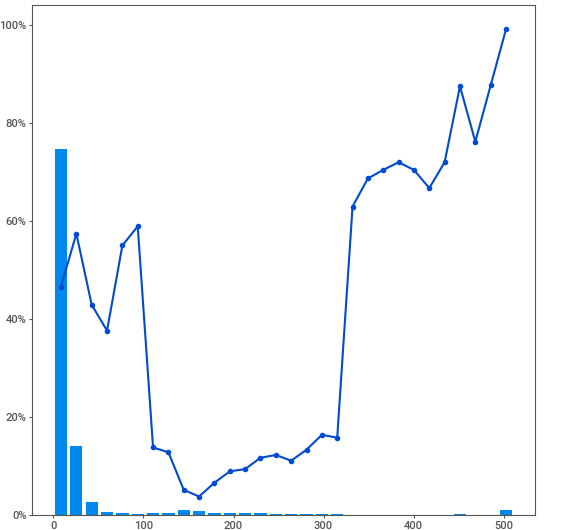
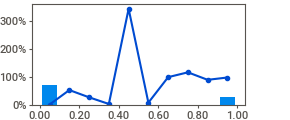
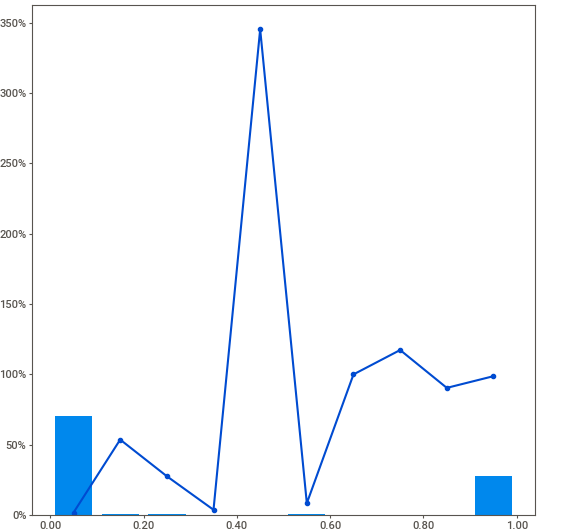
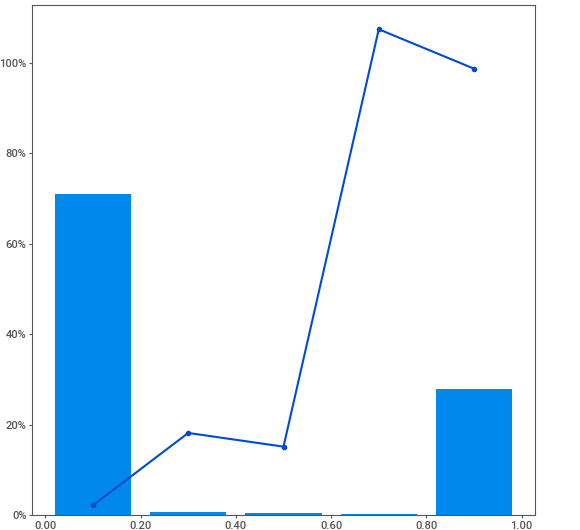
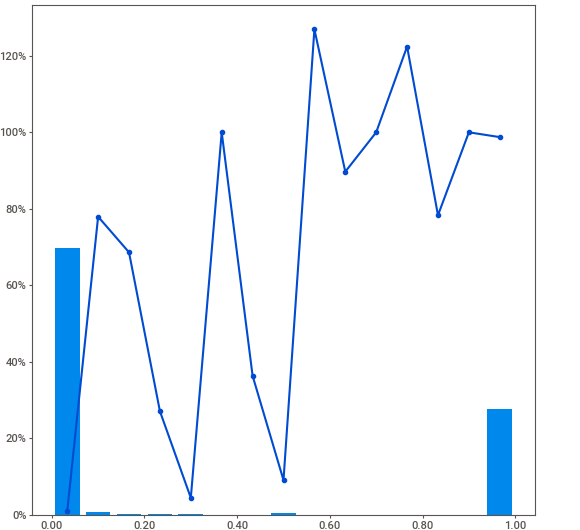
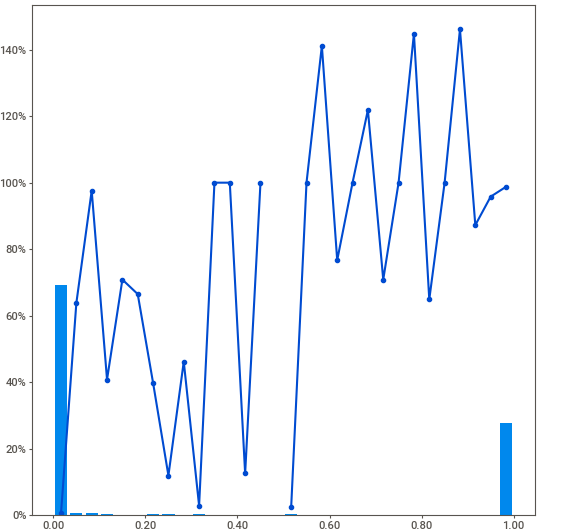
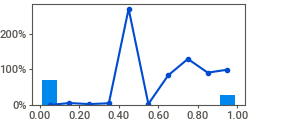
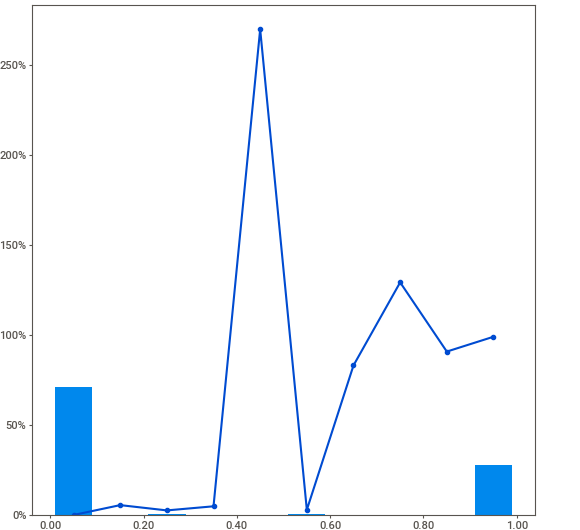
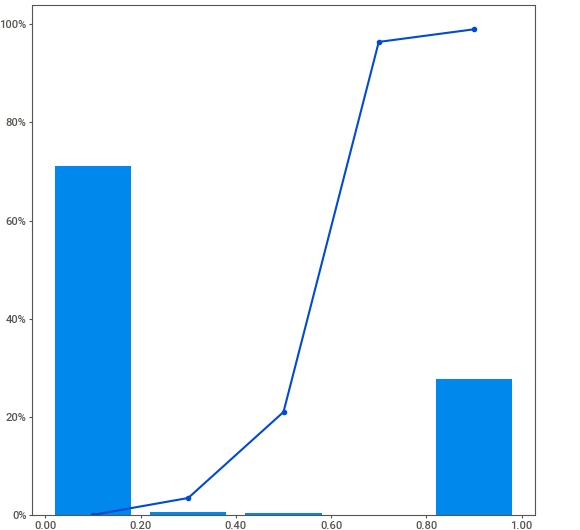
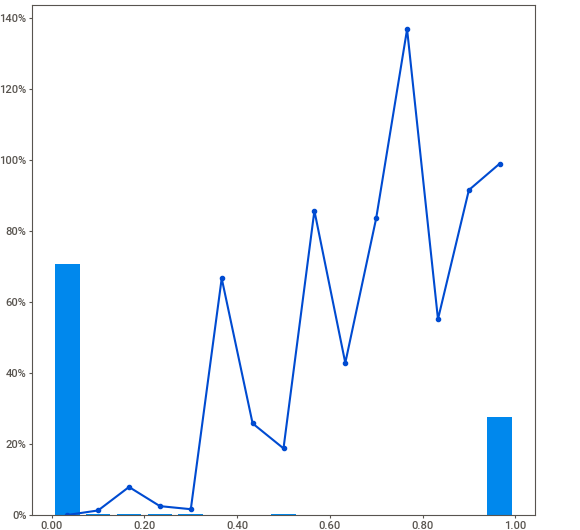
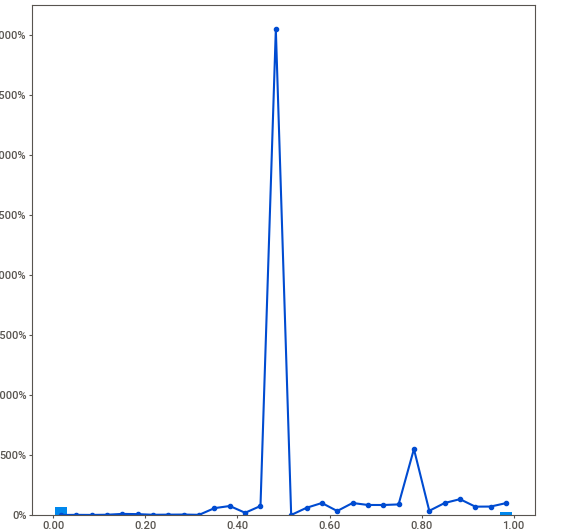
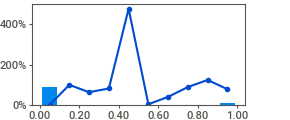
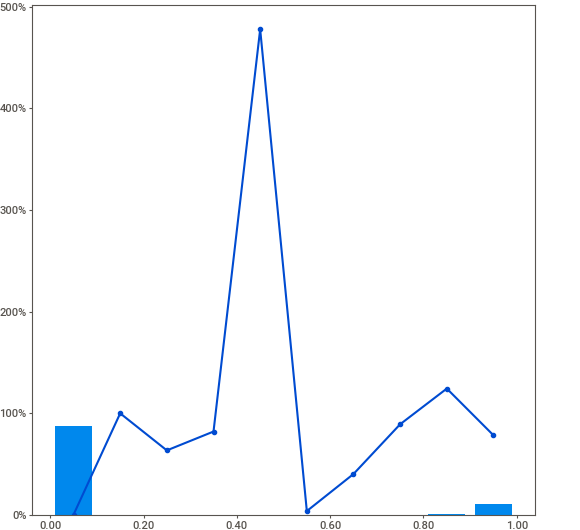
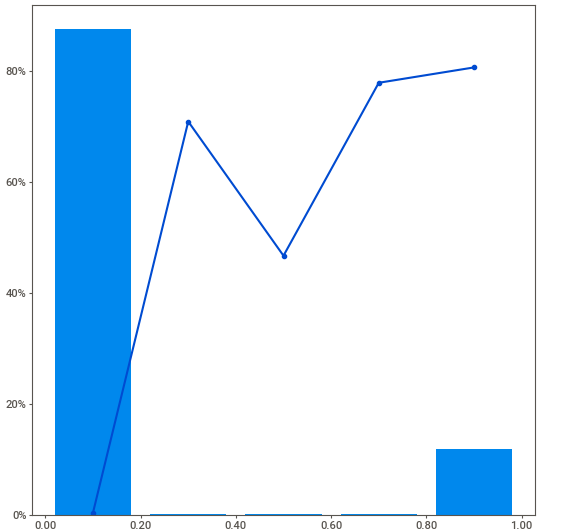
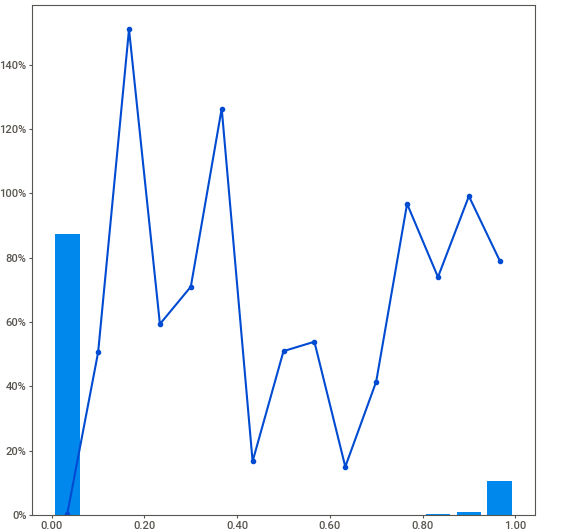
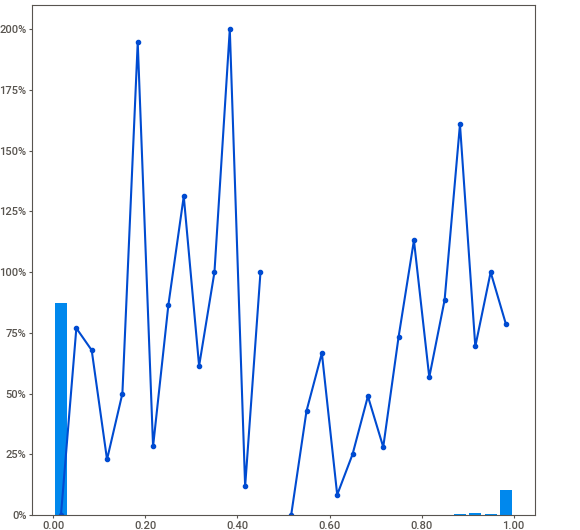
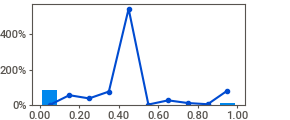
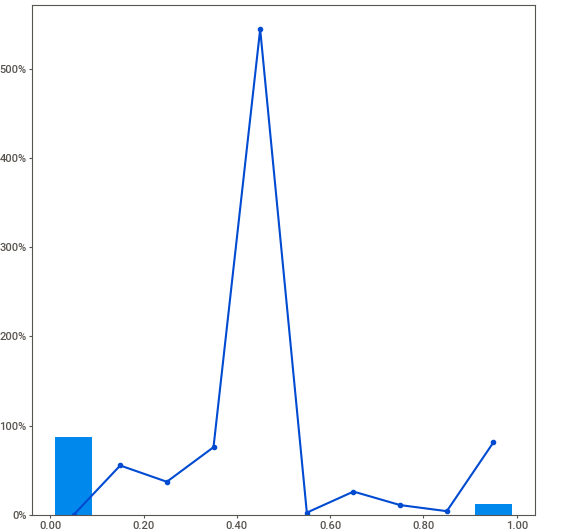
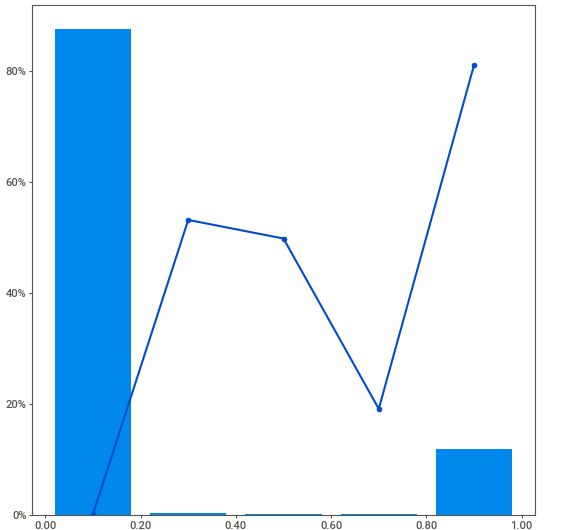
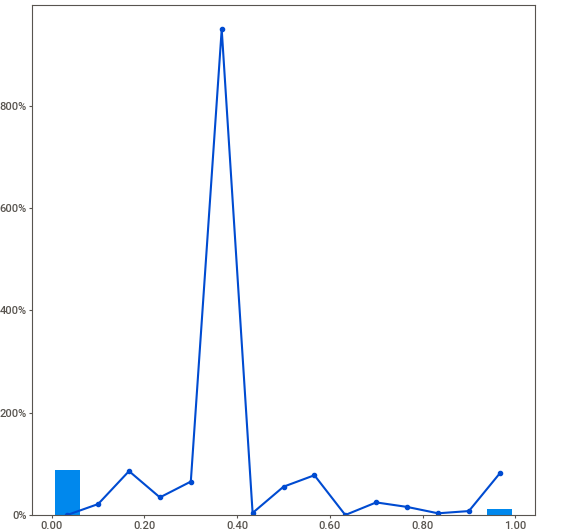
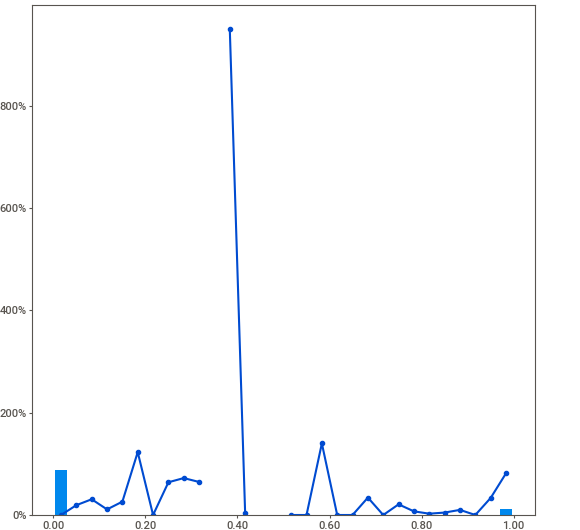
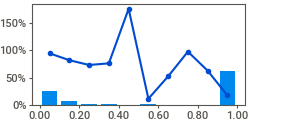
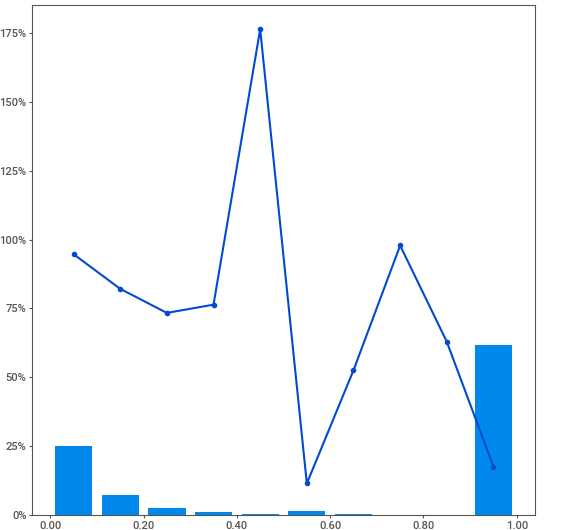
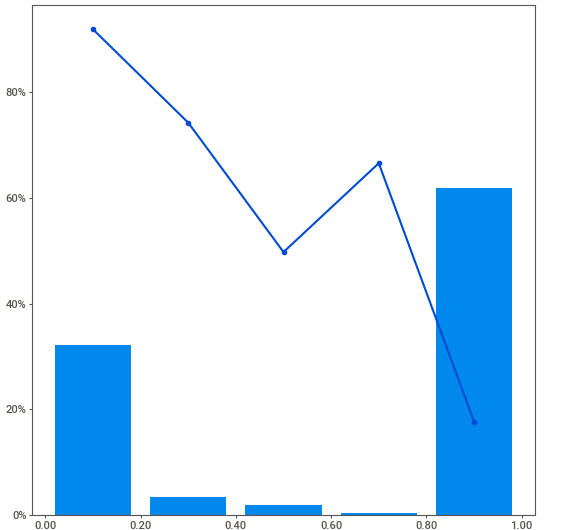
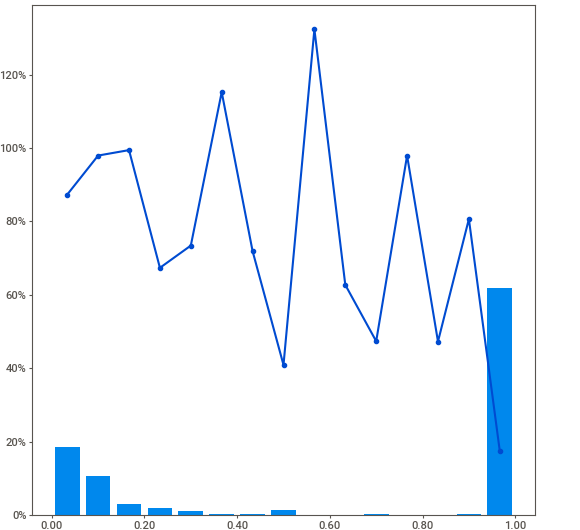
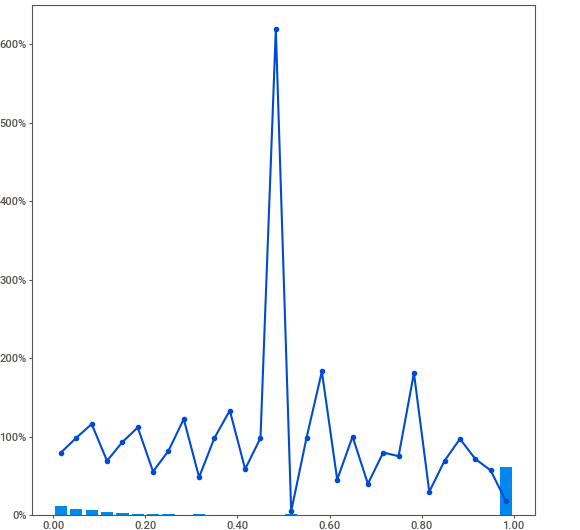
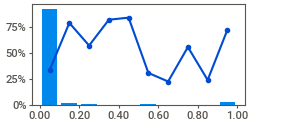
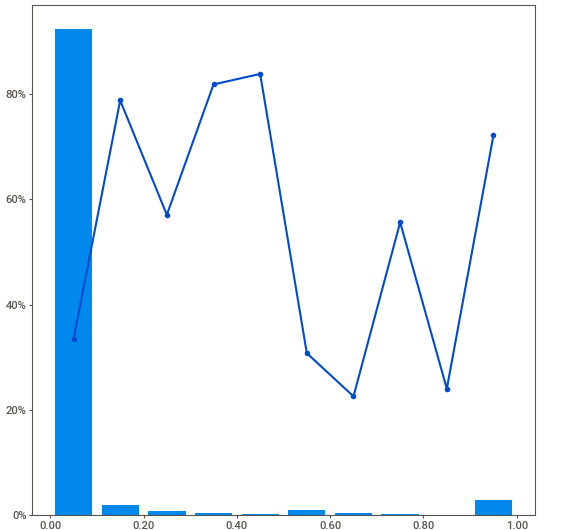
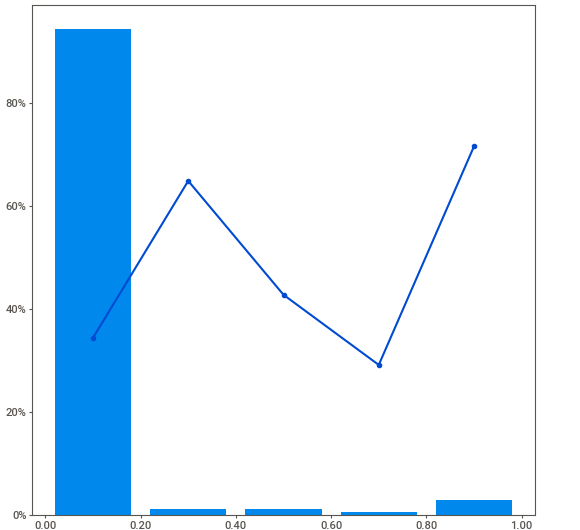
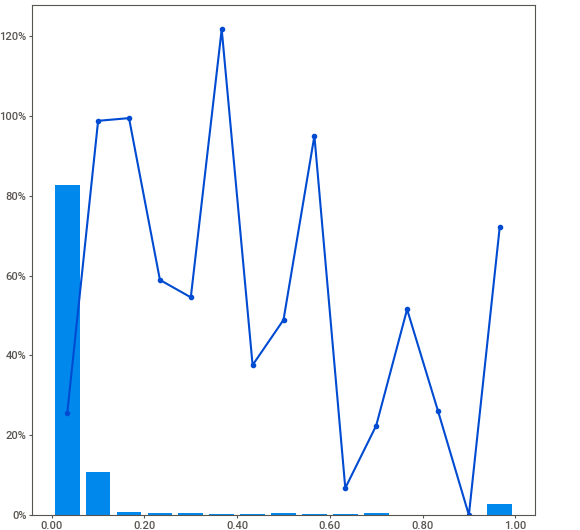
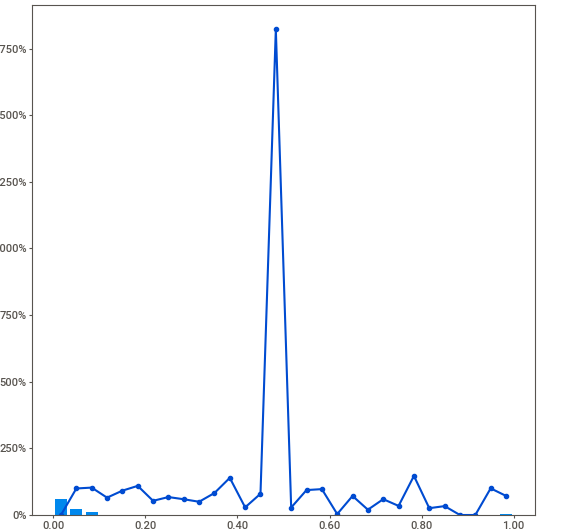
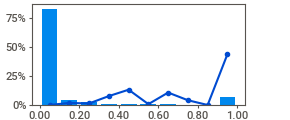
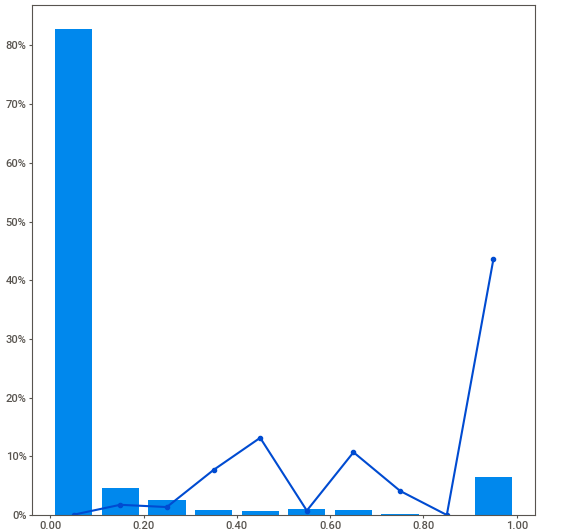
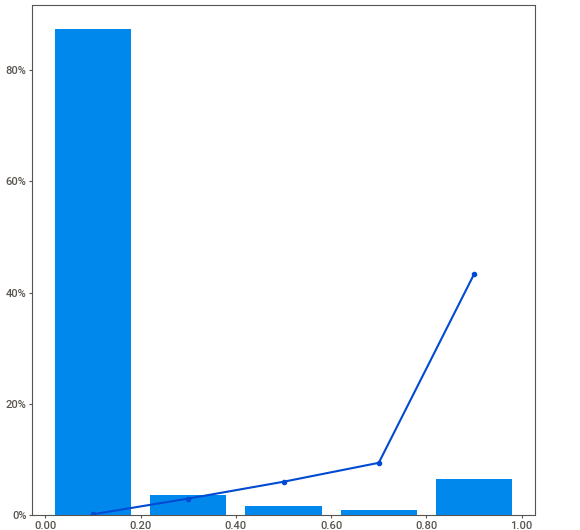
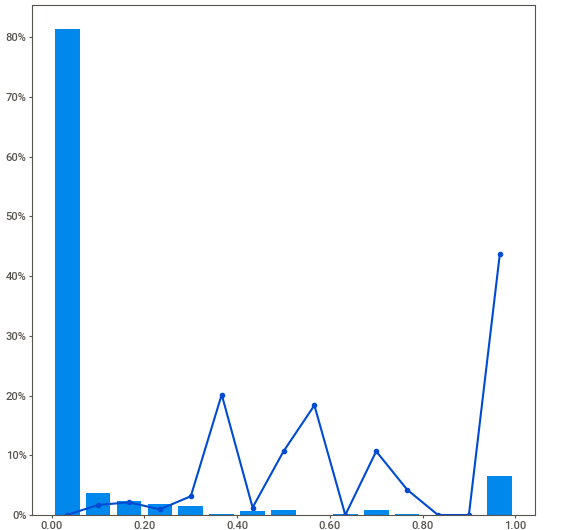
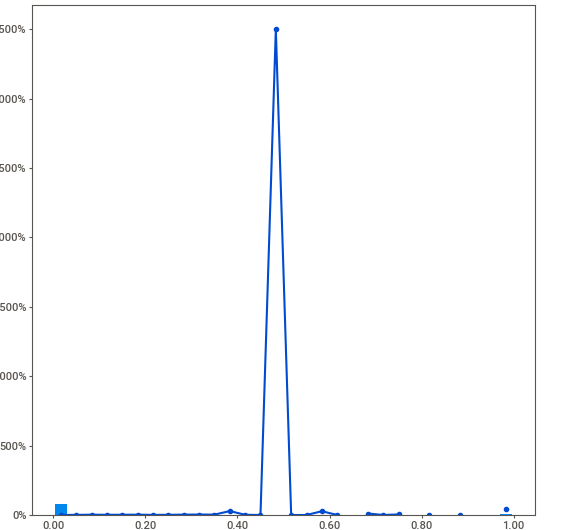
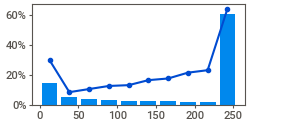
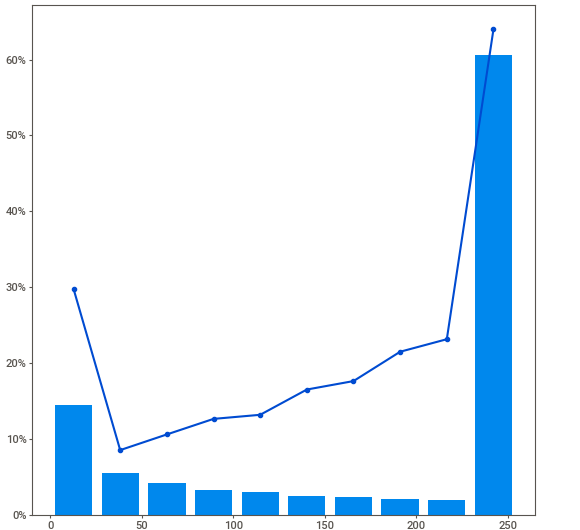
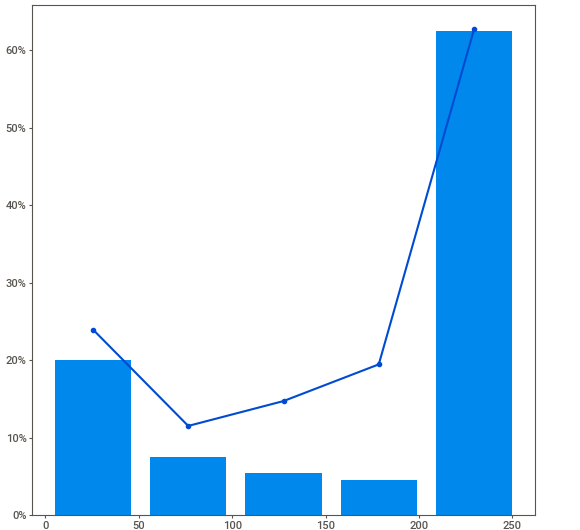
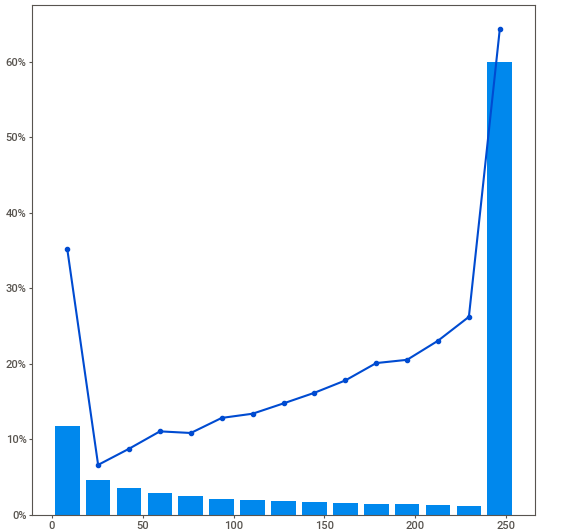
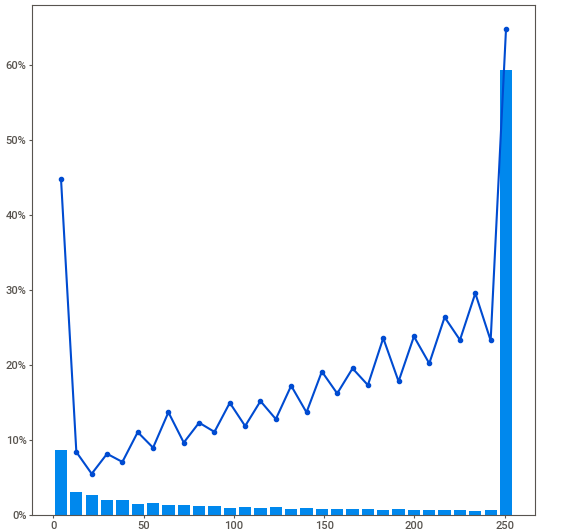
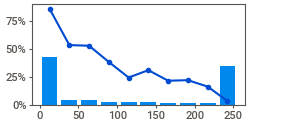
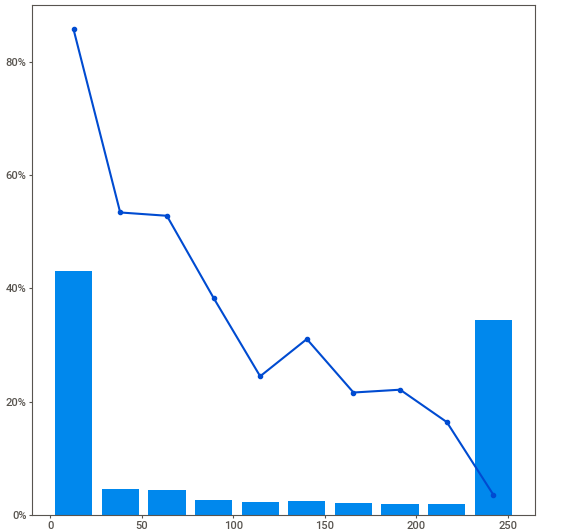
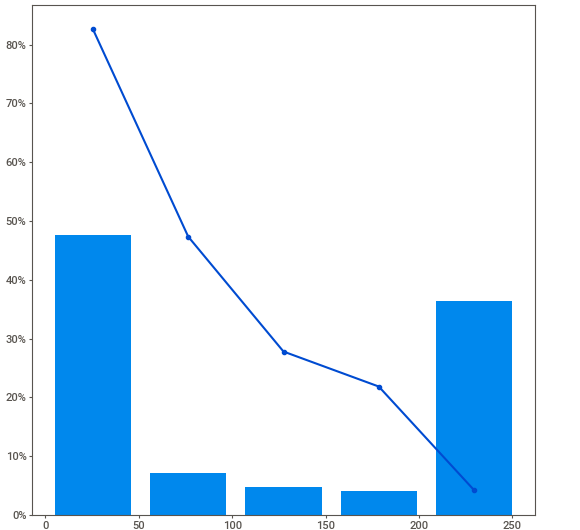
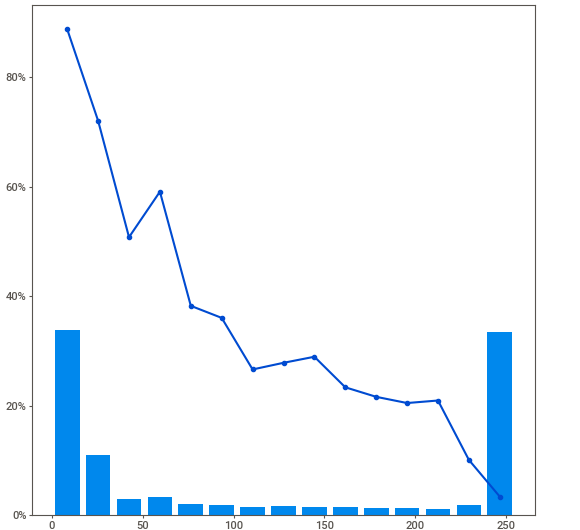
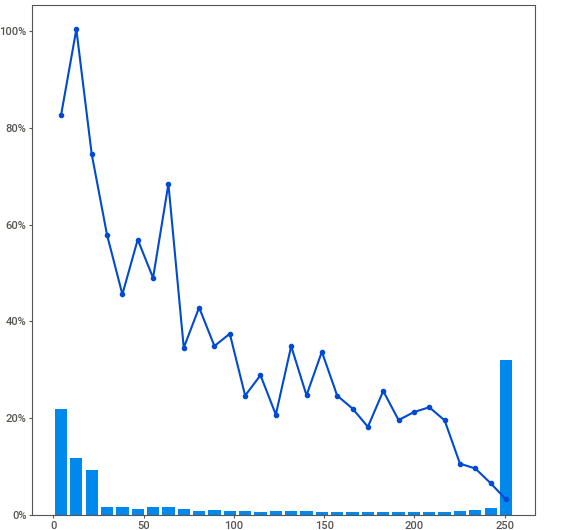
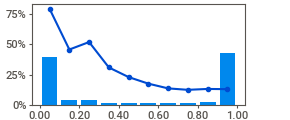
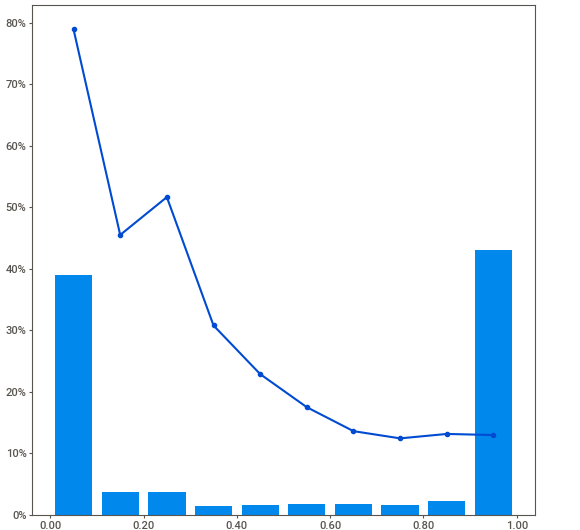
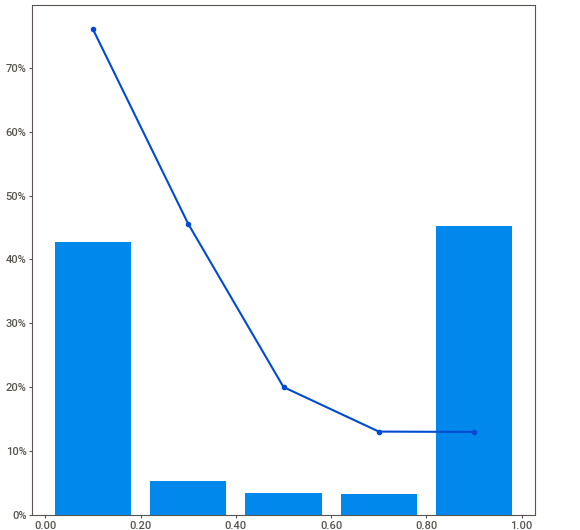
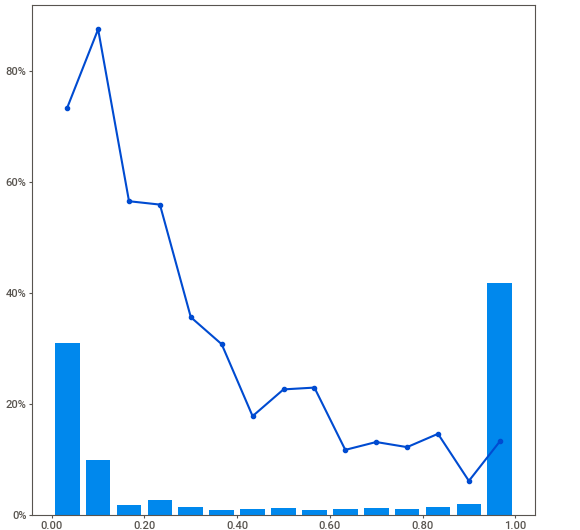
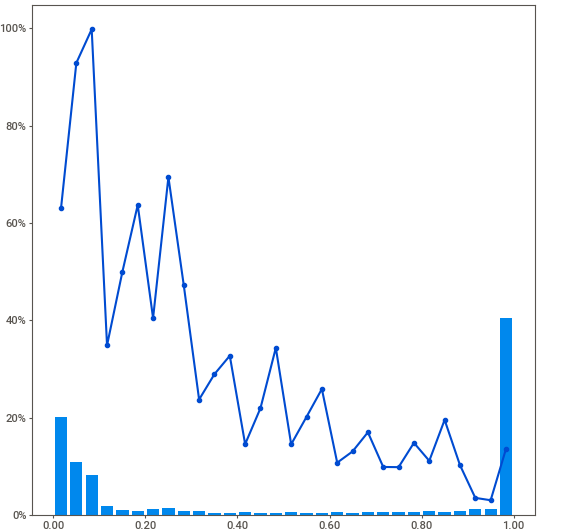
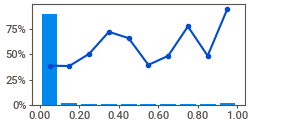
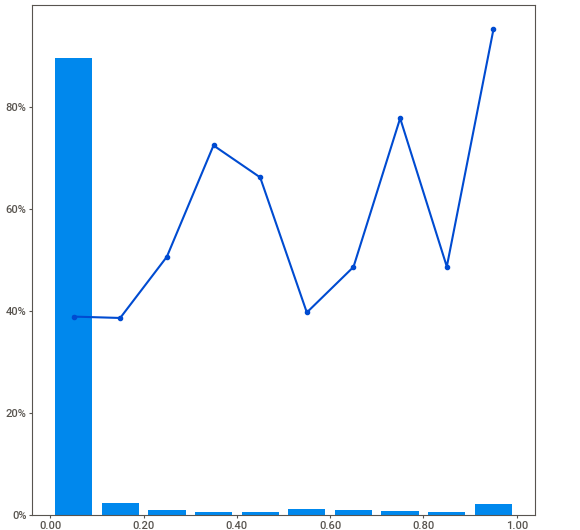
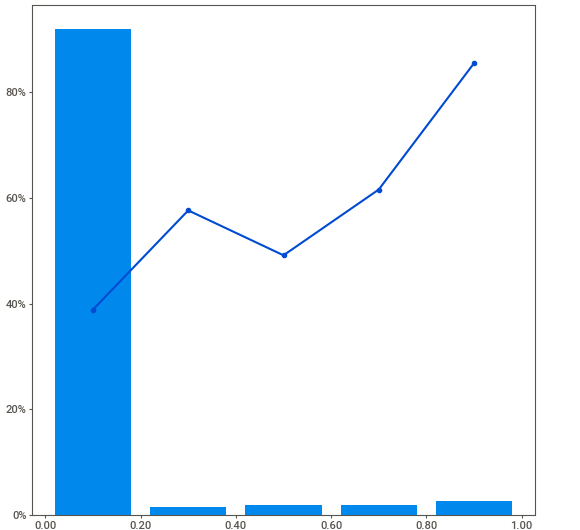
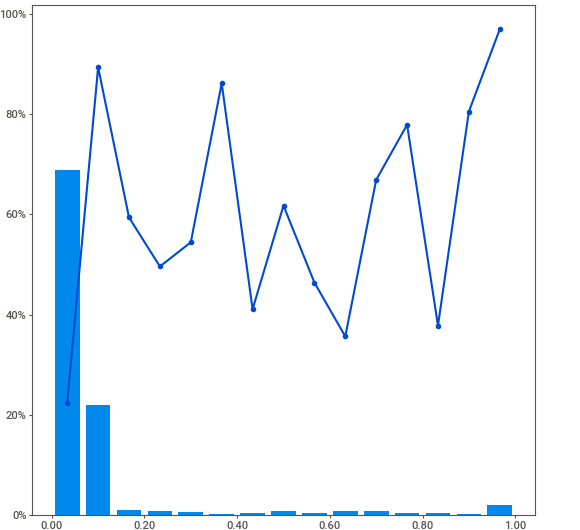
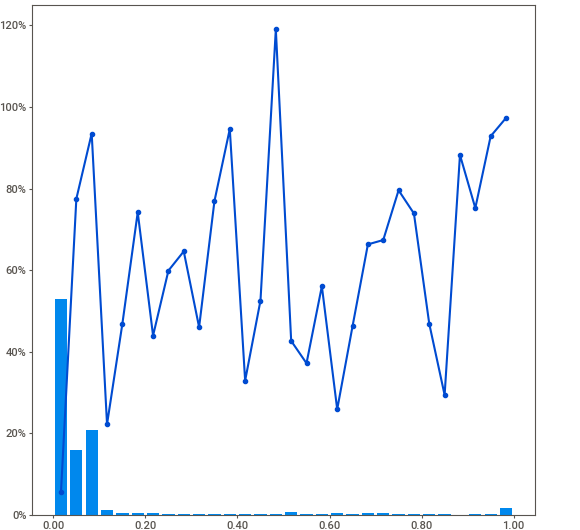
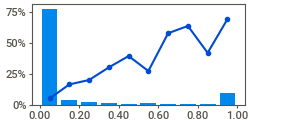
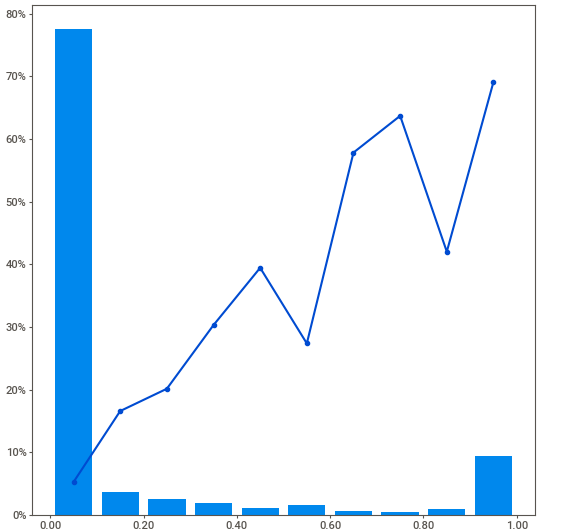
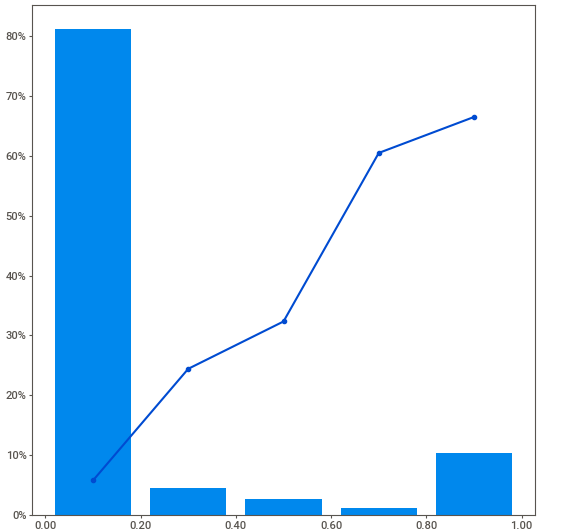
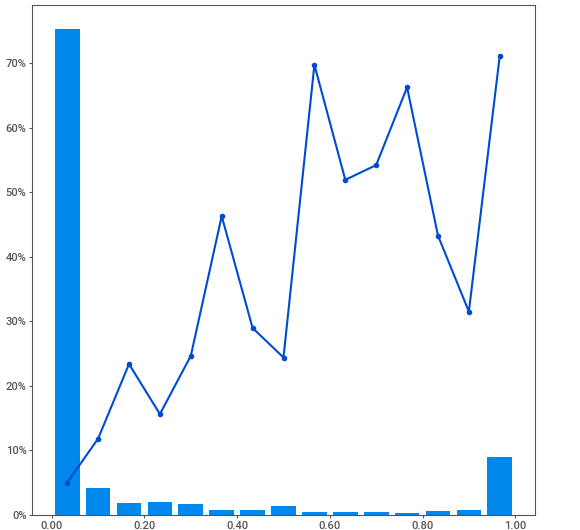
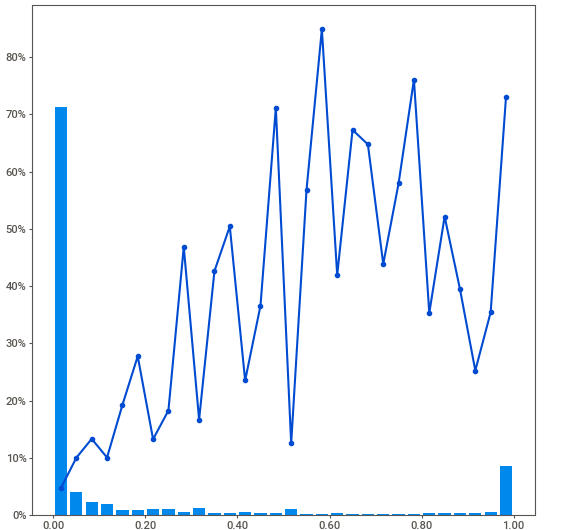
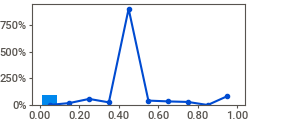
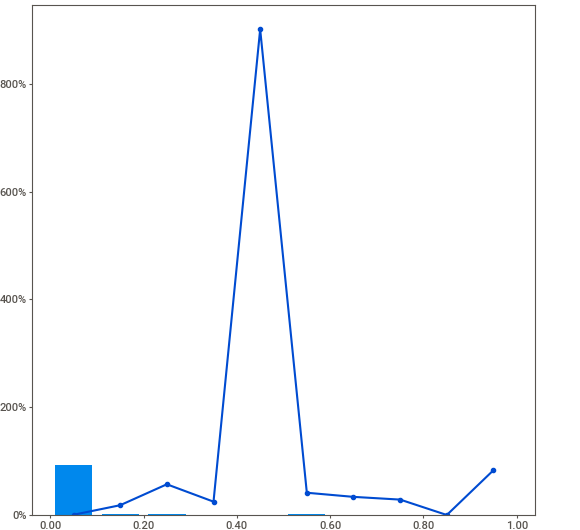
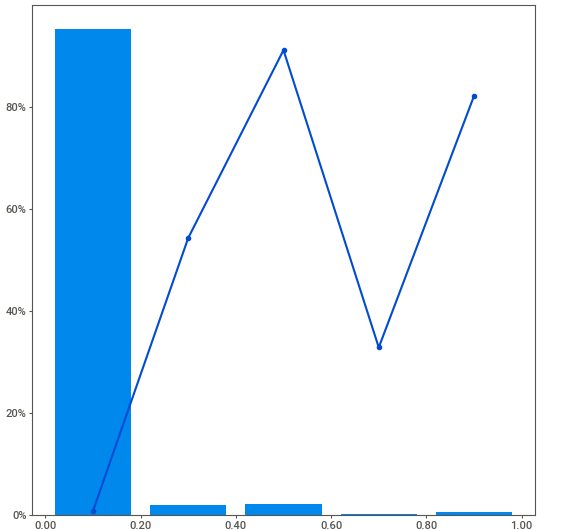
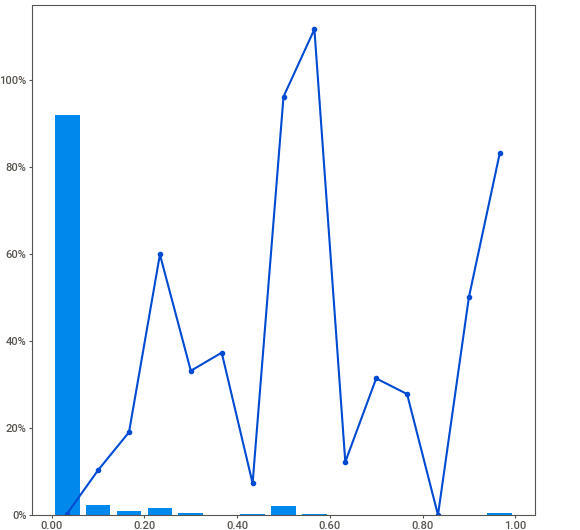
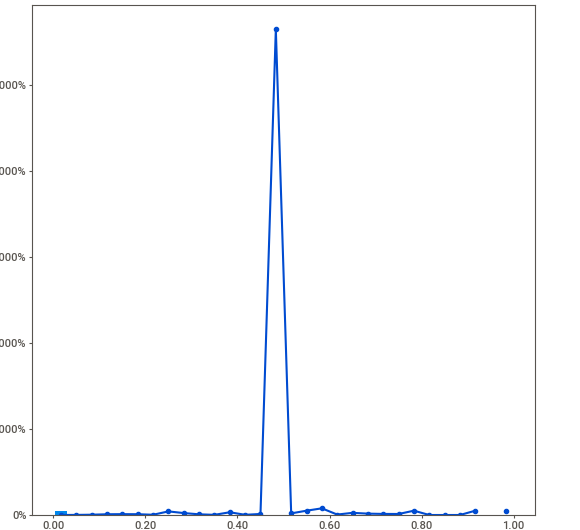
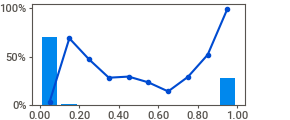
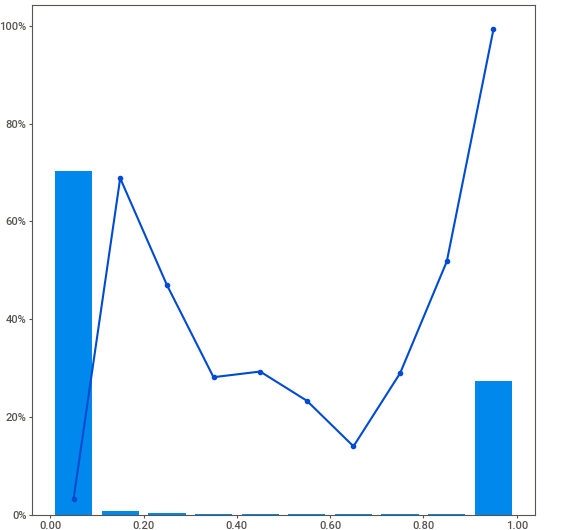
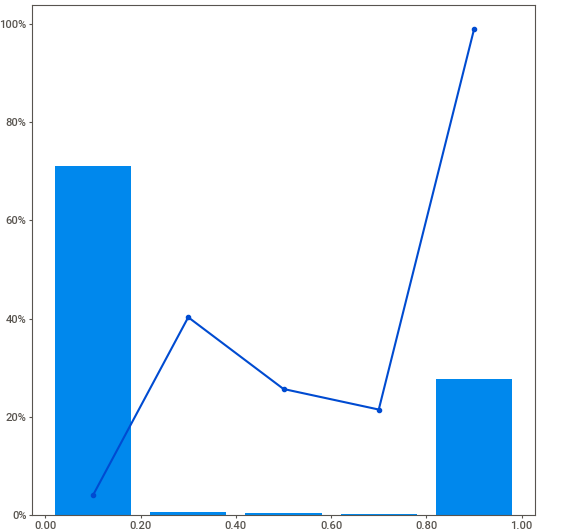
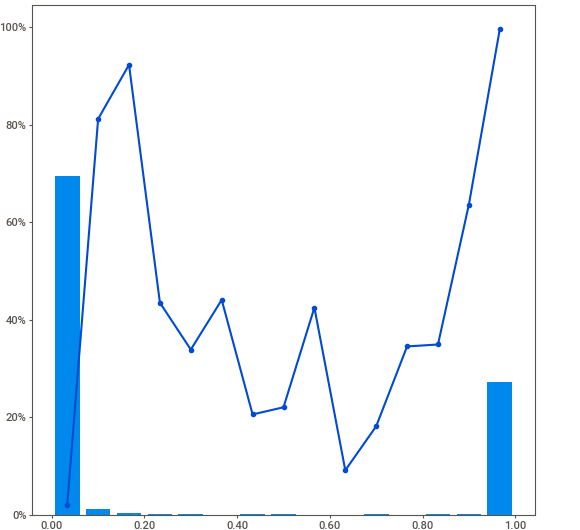
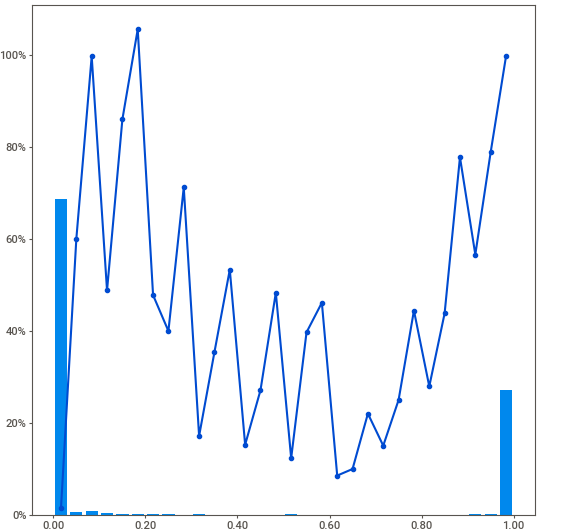
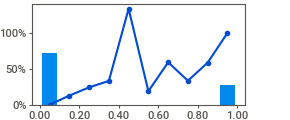
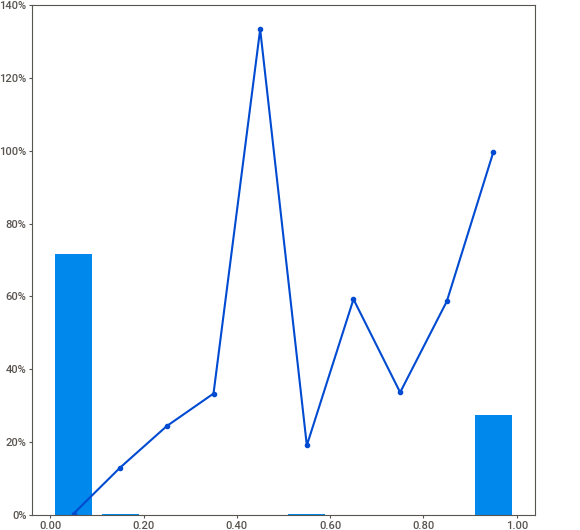
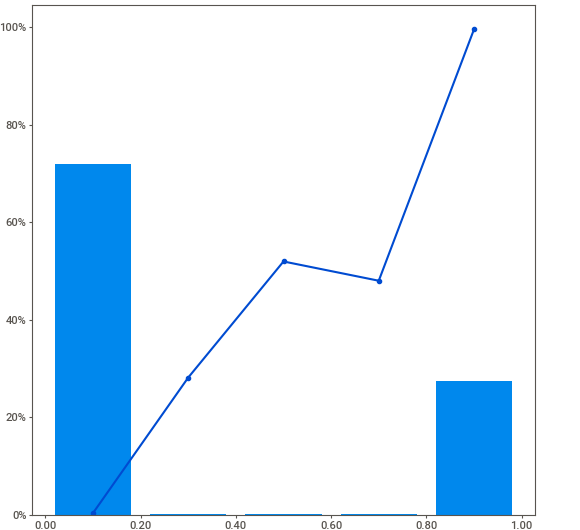
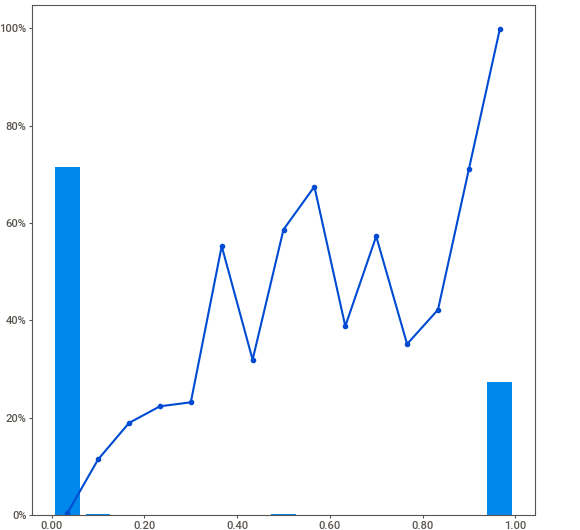
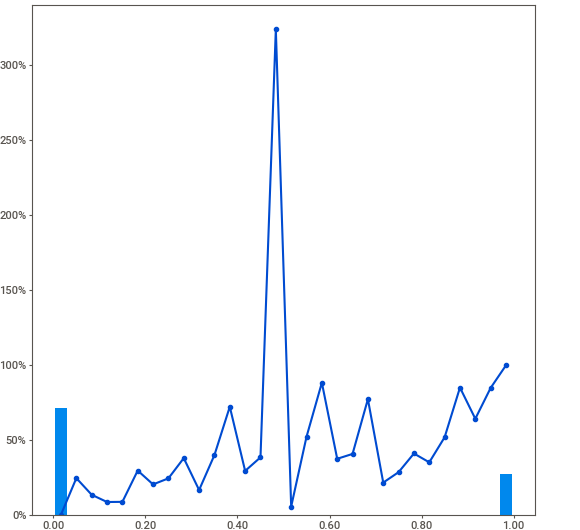
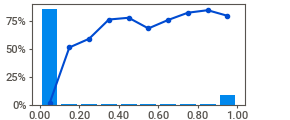
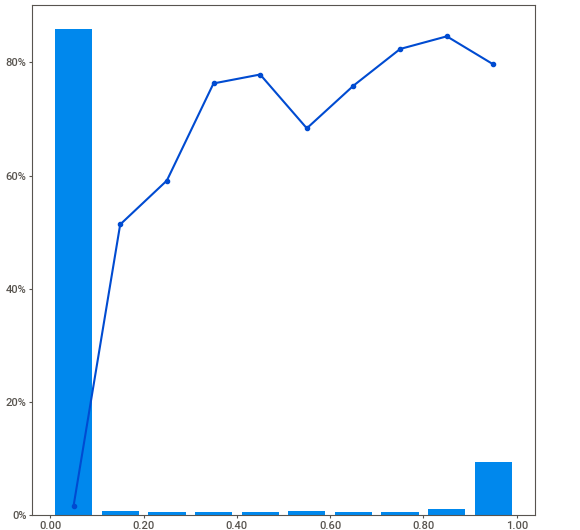
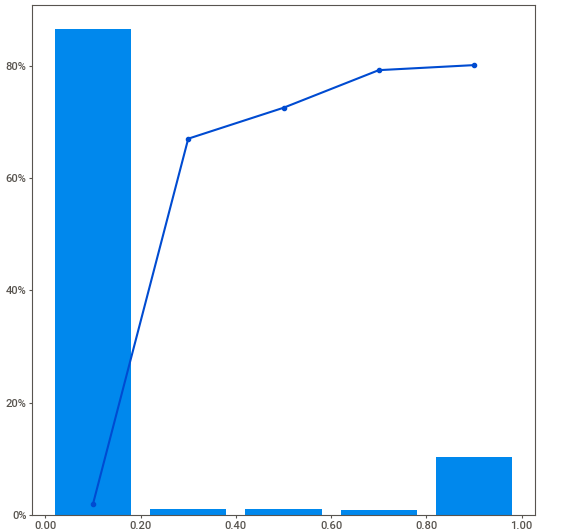
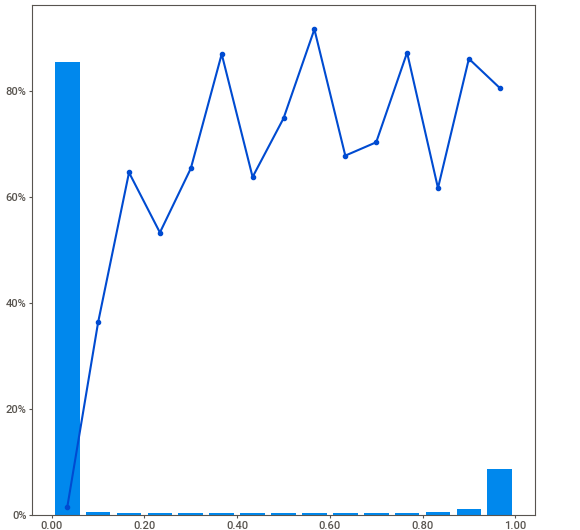
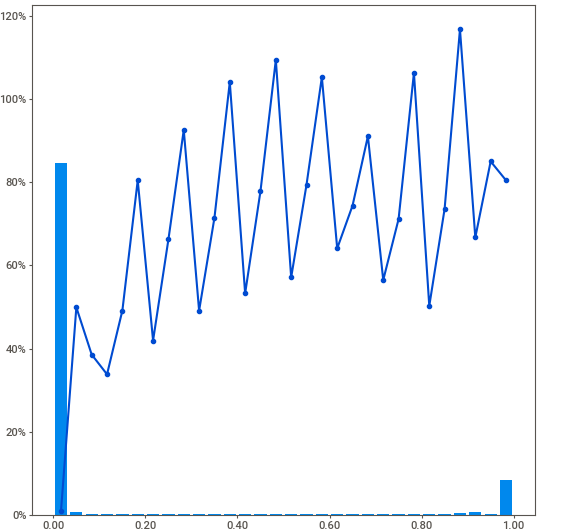
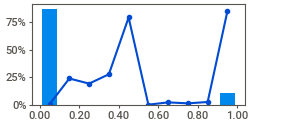
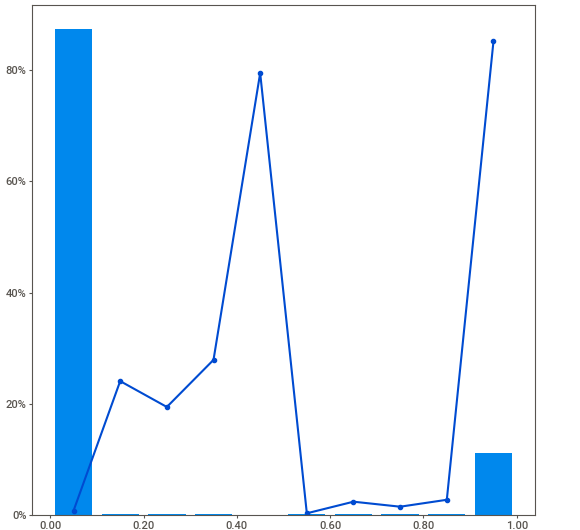
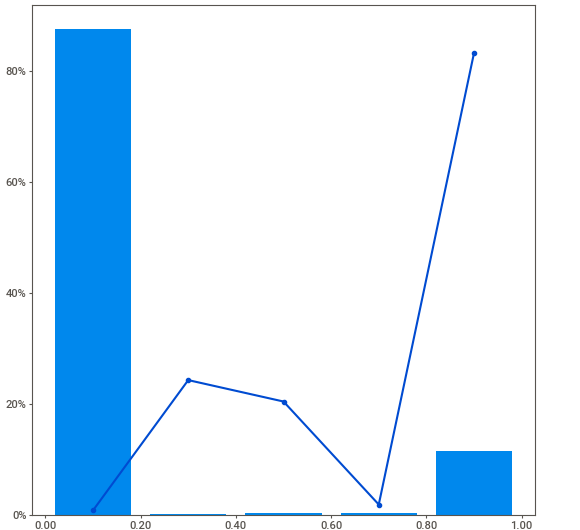
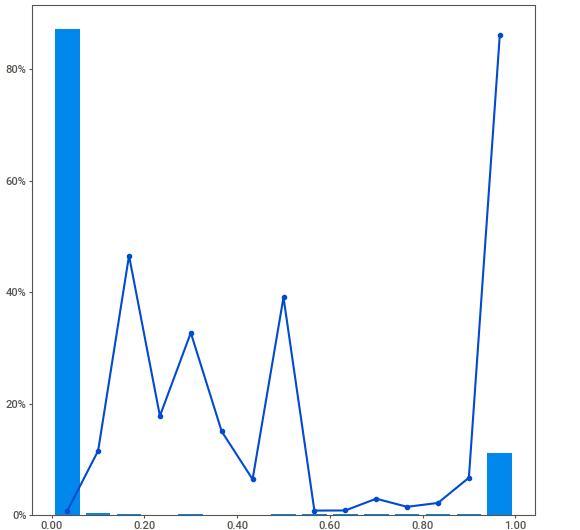
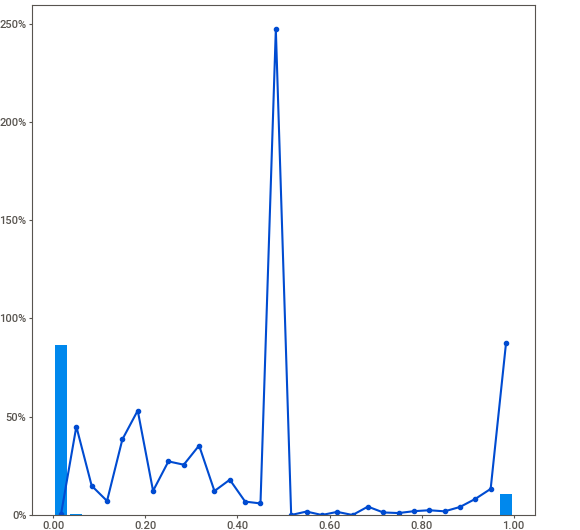
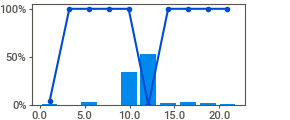
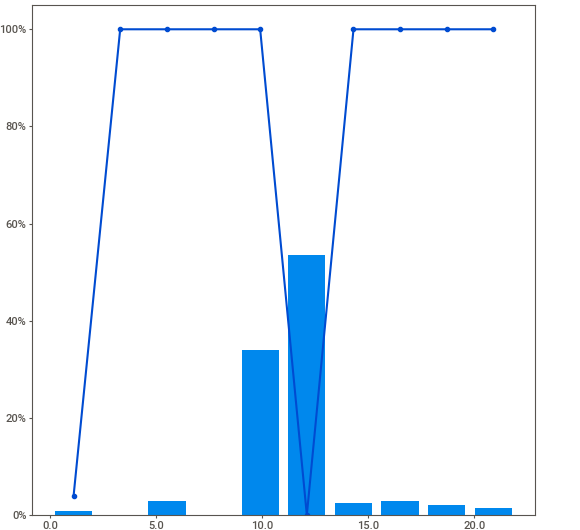
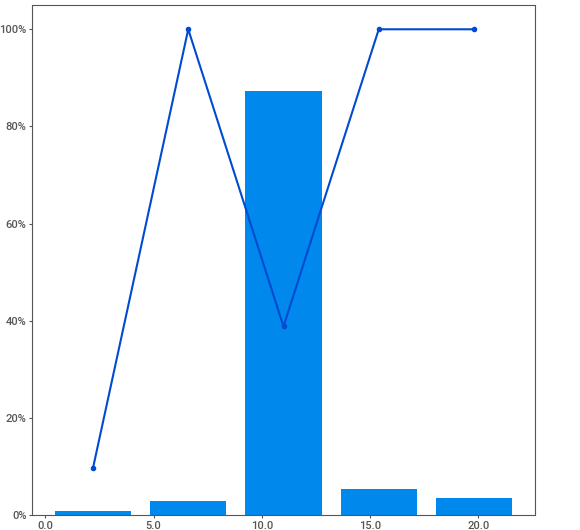
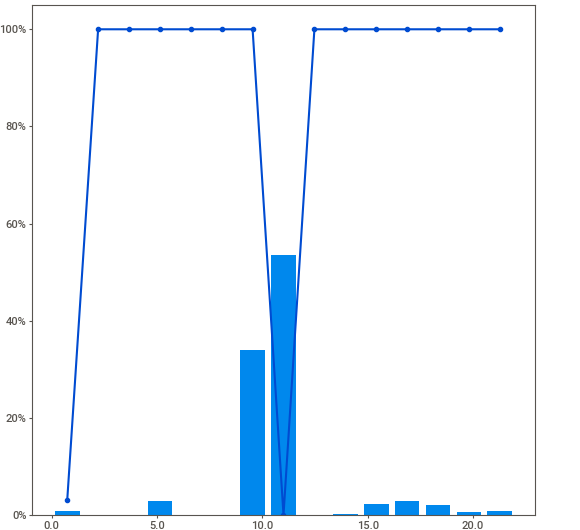
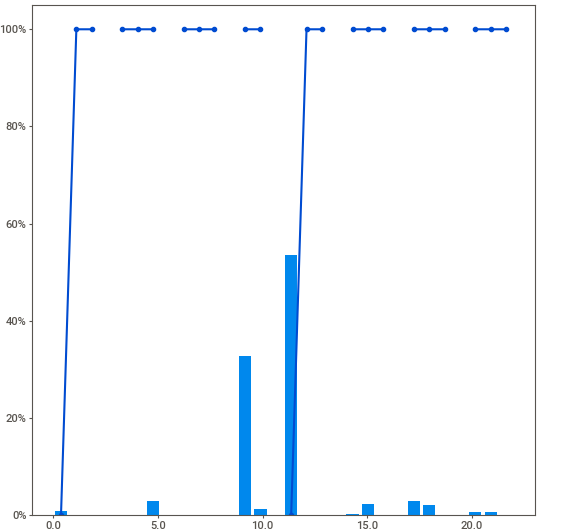
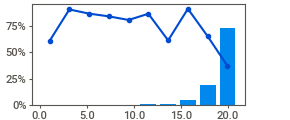
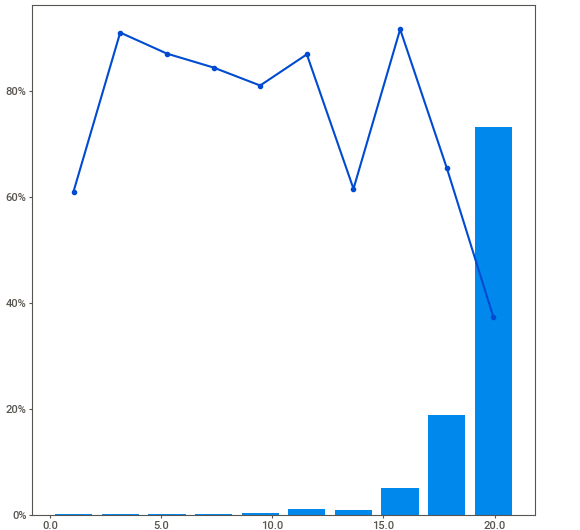
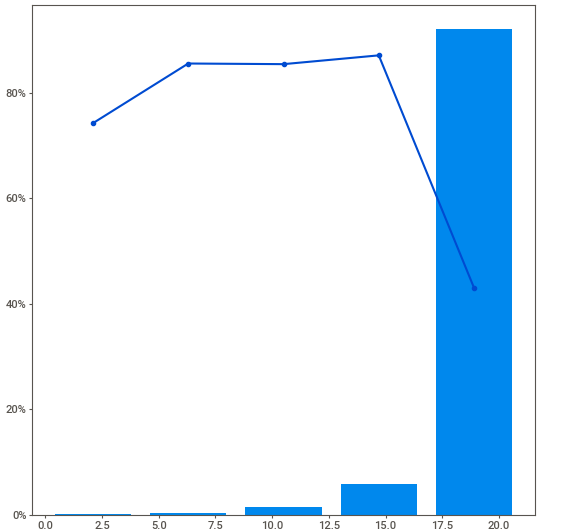
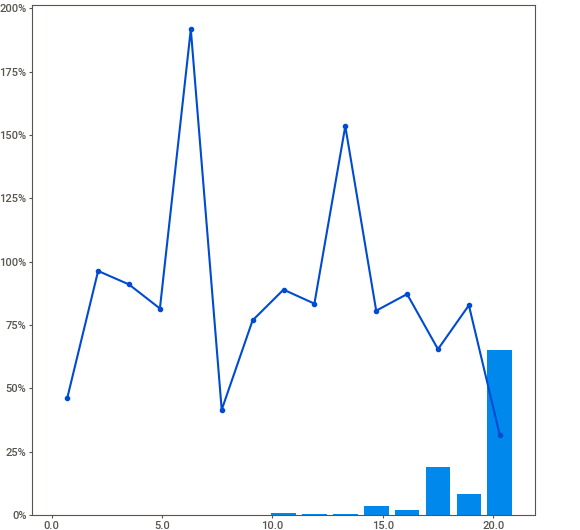
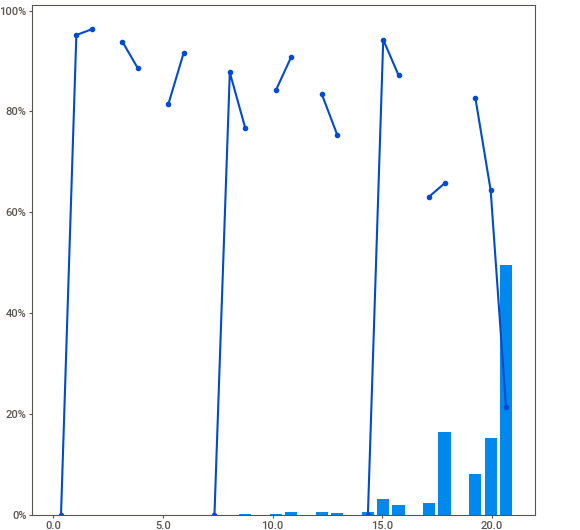
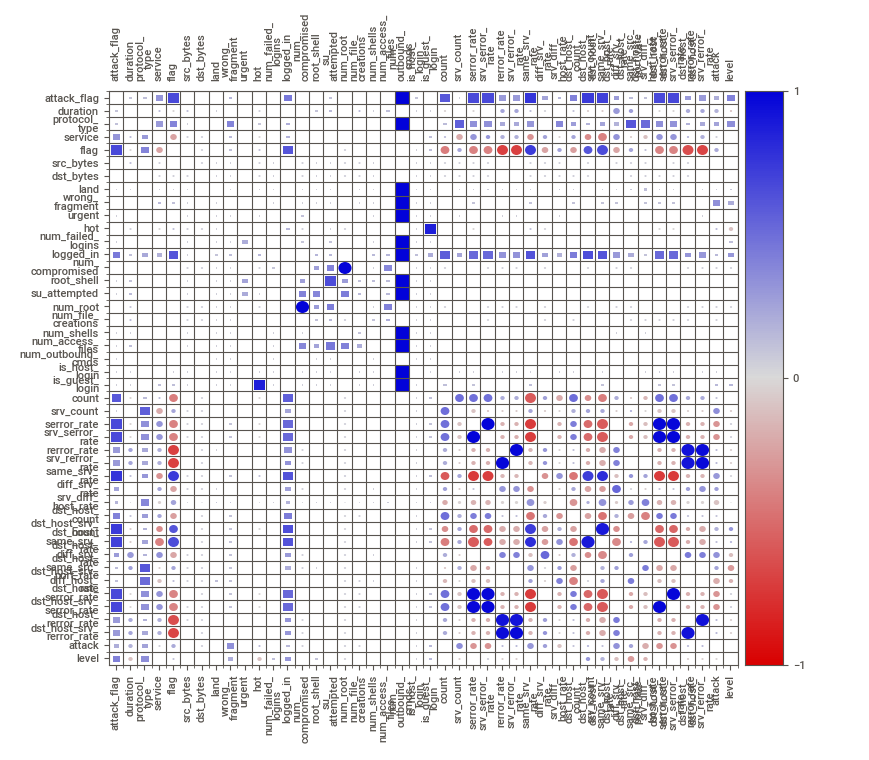
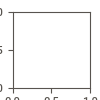

In [122]:
cor_ananlysis.show_notebook()

Como é possível ver, a tabela de correlações está bem mais adequada à coluna de 'attack_flag'

In [123]:
df_test_new = df_test[['same_srv_rate','dst_host_srv_count','dst_host_same_srv_rate','dst_host_srv_serror_rate','dst_host_serror_rate','serror_rate','dst_host_diff_srv_rate','diff_srv_rate','srv_diff_host_rate','service','flag','logged_in','srv_serror_rate','count','dst_host_count','srv_rerror_rate','dst_host_srv_rerror_rate','rerror_rate','dst_host_rerror_rate','attack_flag']]
df_train_new = df_train[['same_srv_rate','dst_host_srv_count','dst_host_same_srv_rate','dst_host_srv_serror_rate','dst_host_serror_rate','serror_rate','dst_host_diff_srv_rate','diff_srv_rate','srv_diff_host_rate','service','flag','logged_in','srv_serror_rate','count','dst_host_count','srv_rerror_rate','dst_host_srv_rerror_rate','rerror_rate','dst_host_rerror_rate','attack_flag']]

In [124]:
cor_ananlysis2 = sv.analyze(df_train_new,target_feat='attack_flag')

                                             |          | [  0%]   00:00 -> (? left)


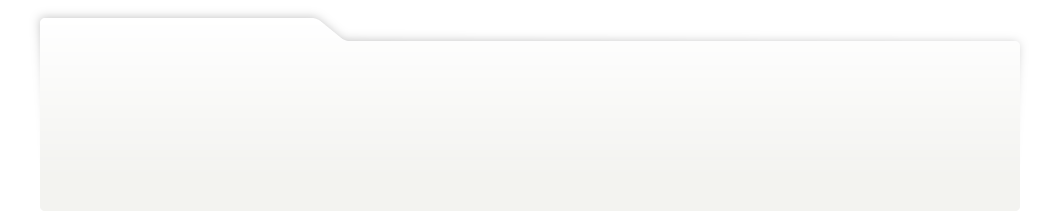
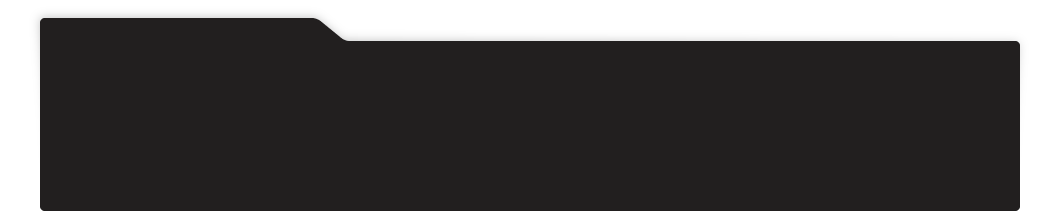
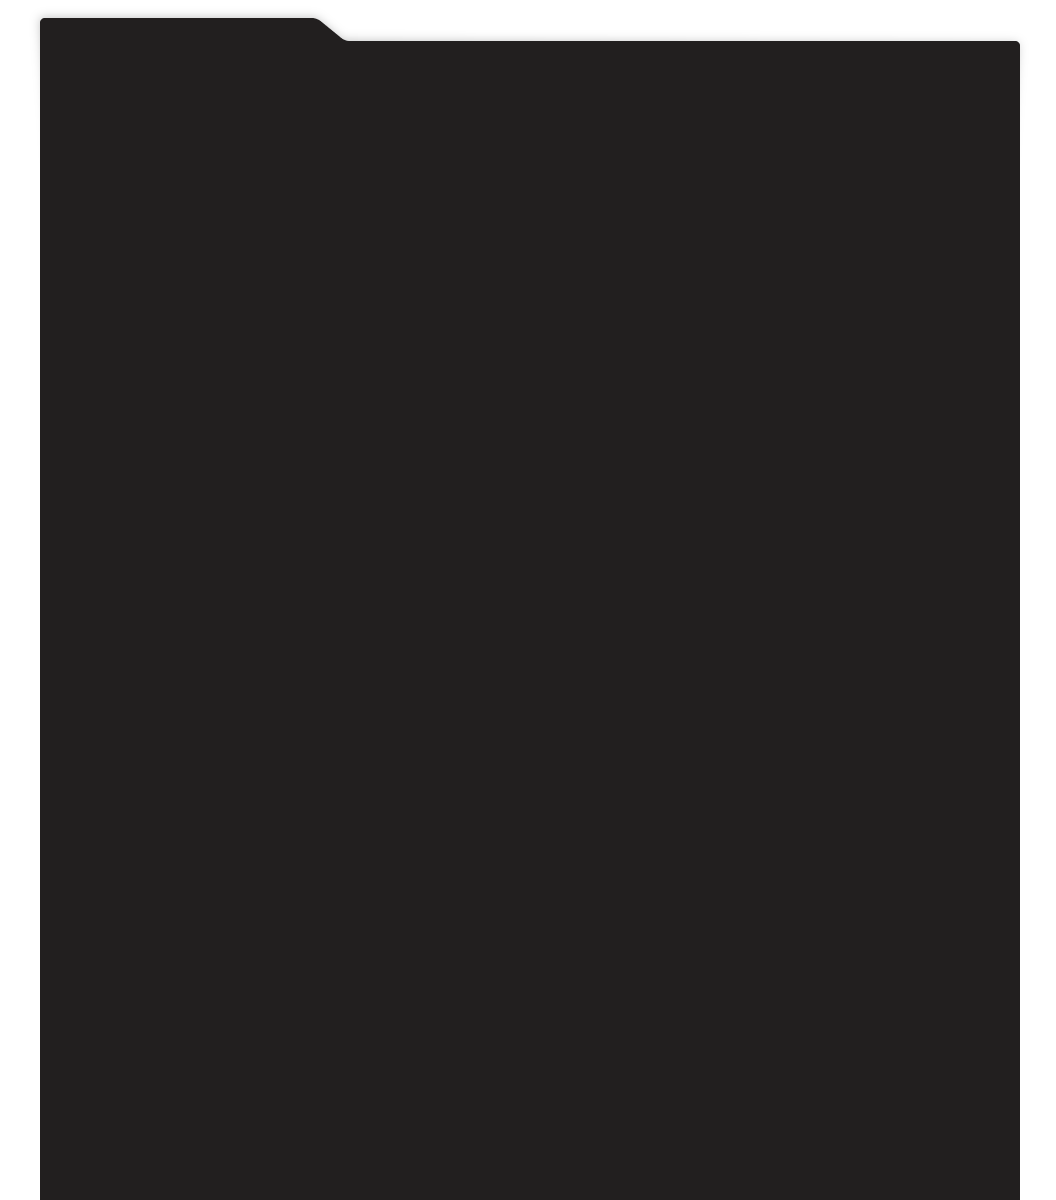
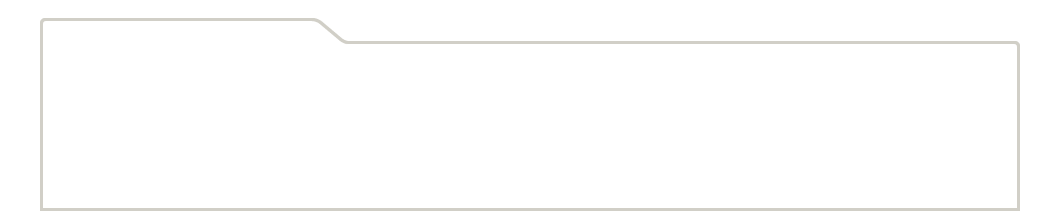
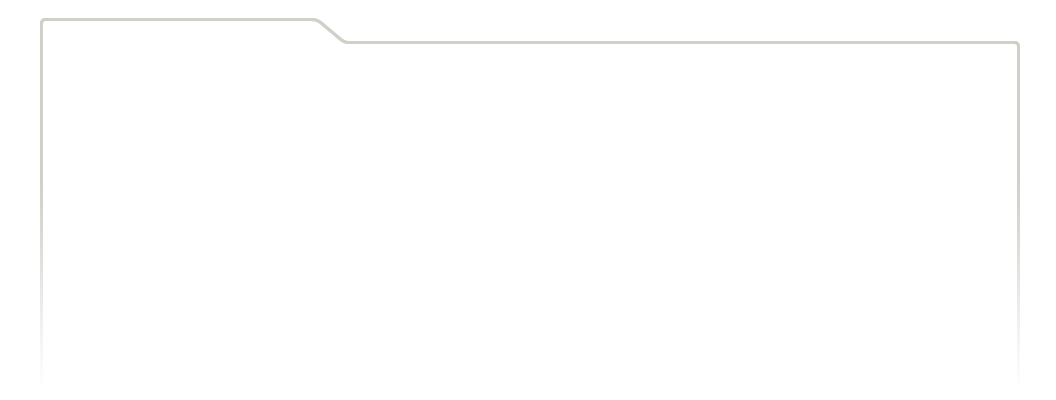
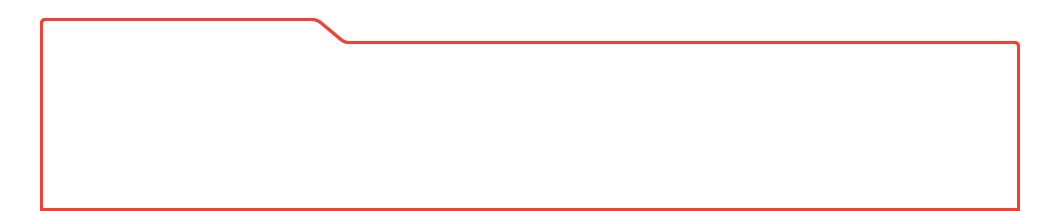
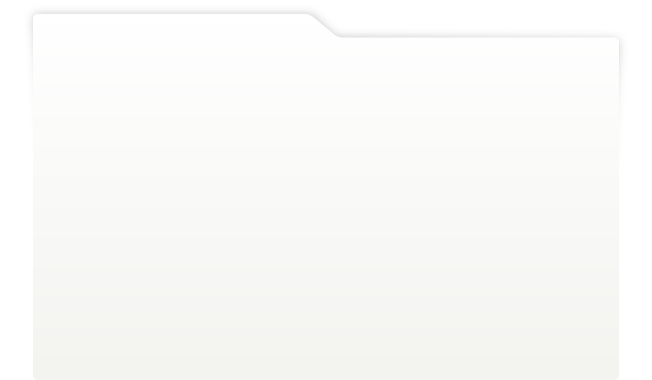
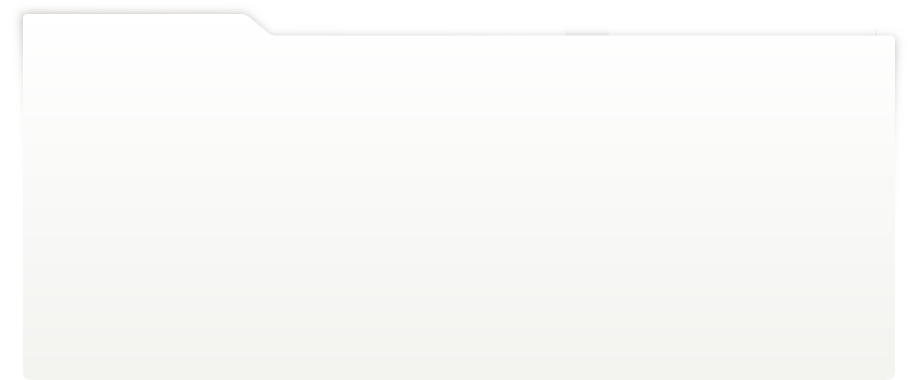
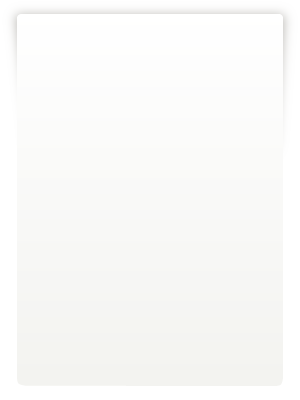
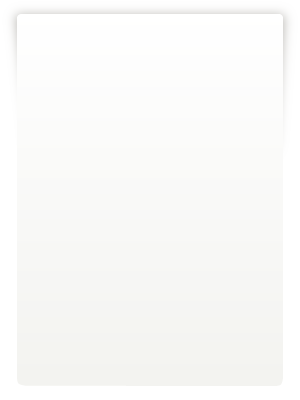
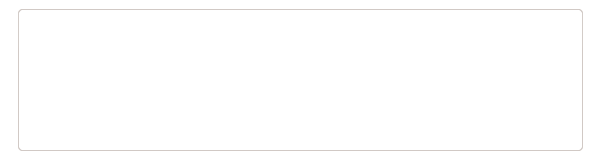
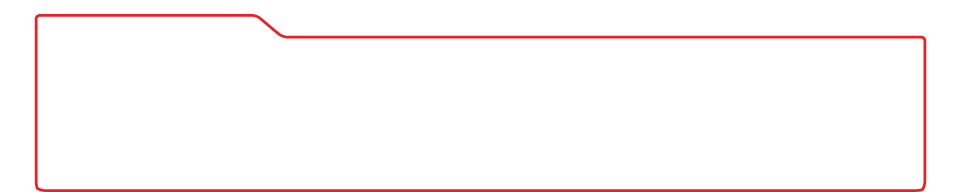
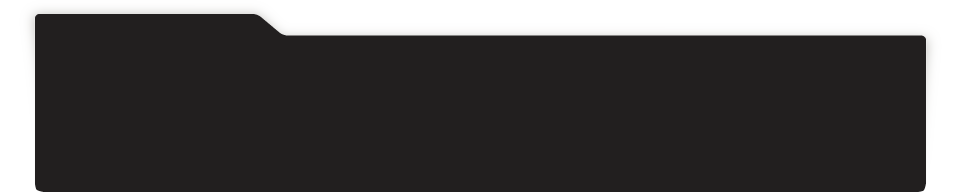
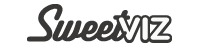
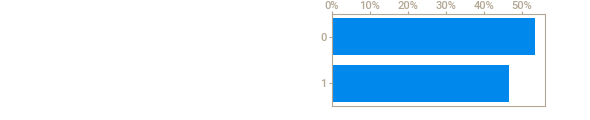
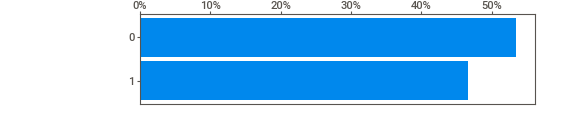
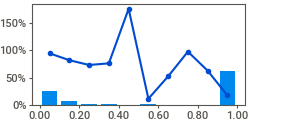
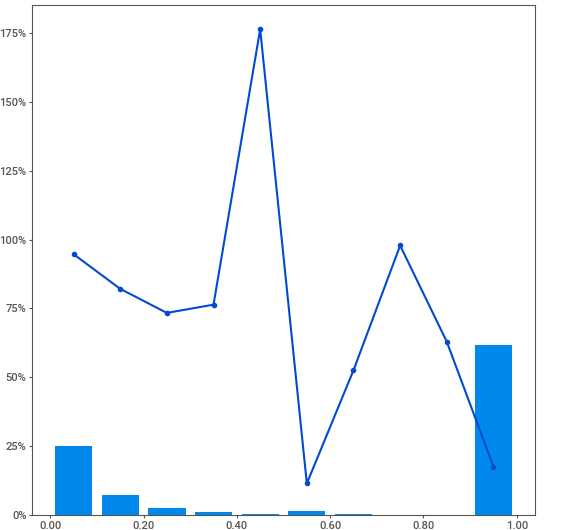
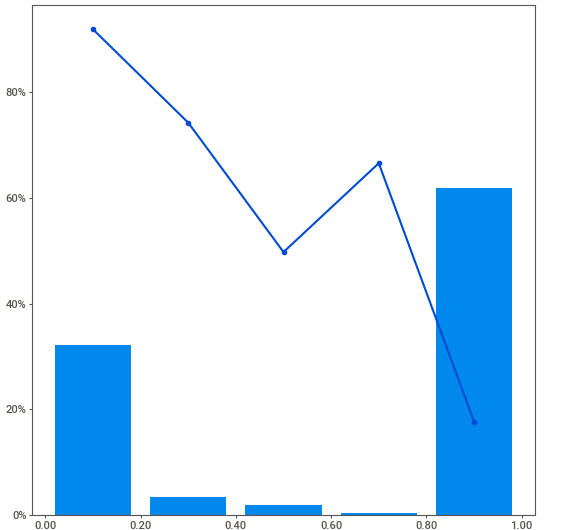
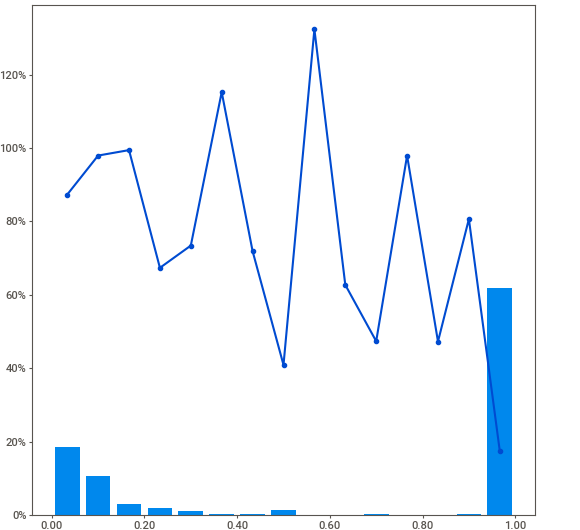
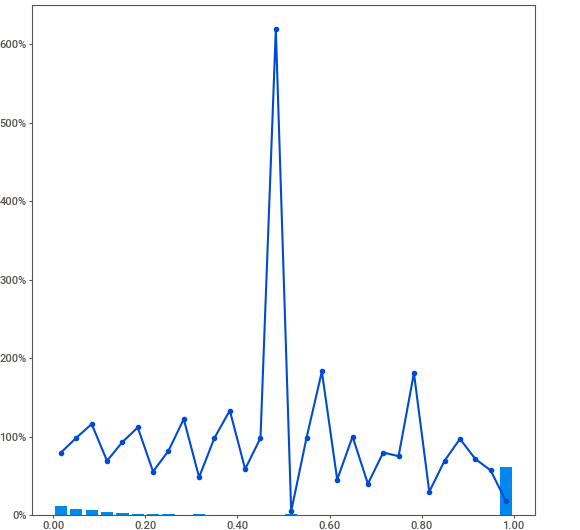
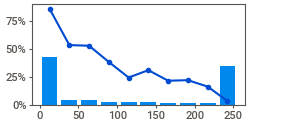
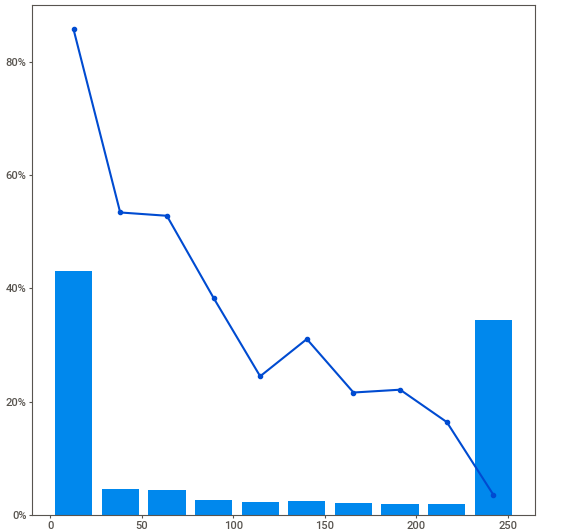
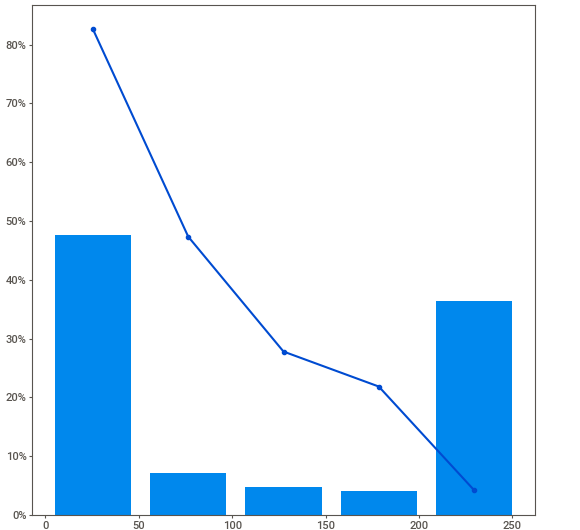
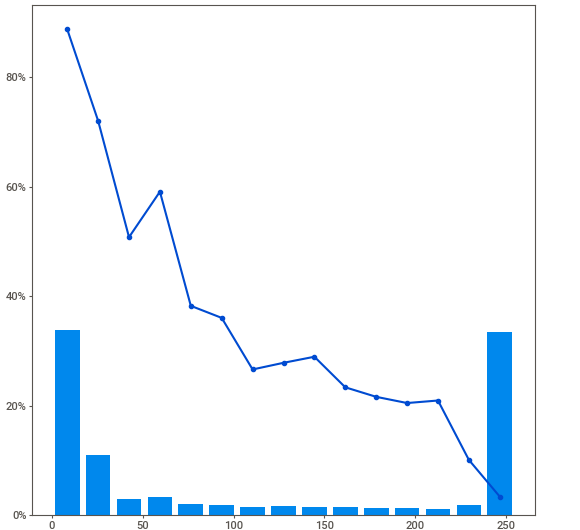
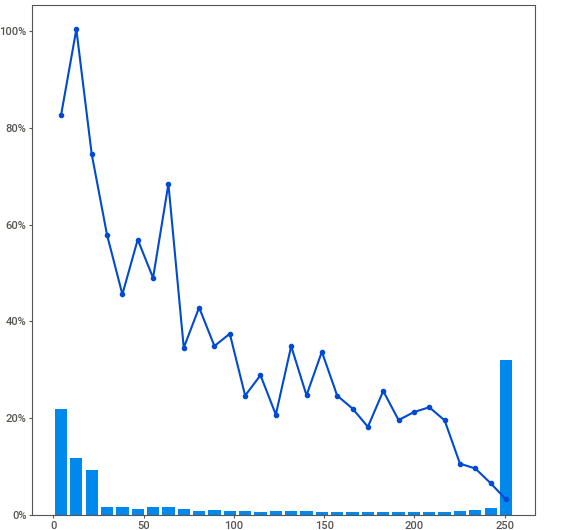
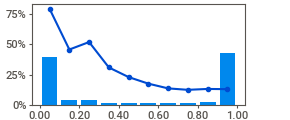
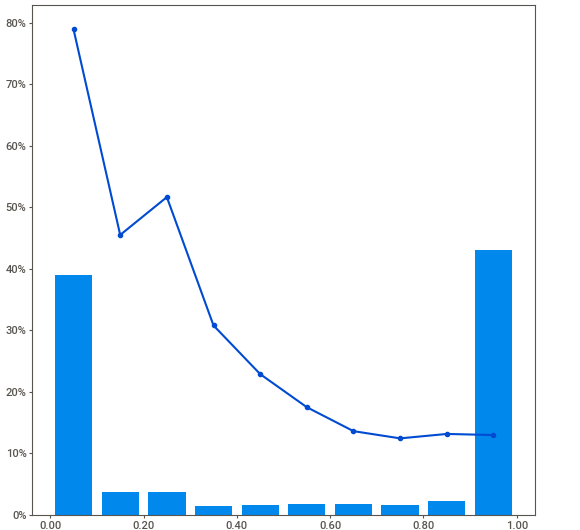
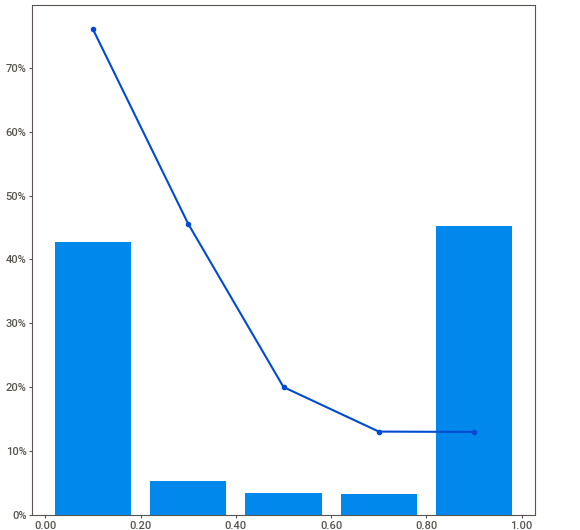
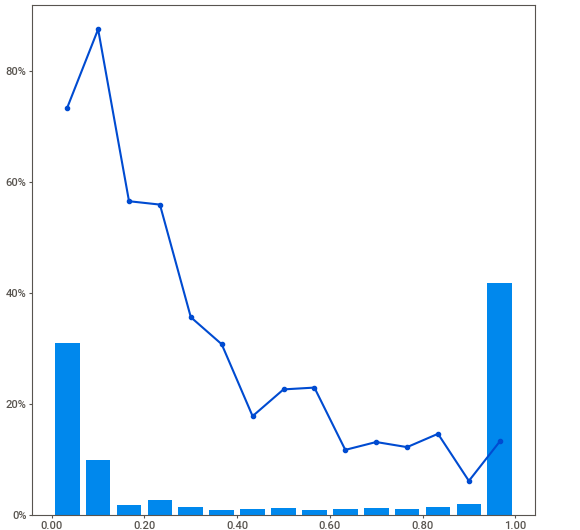
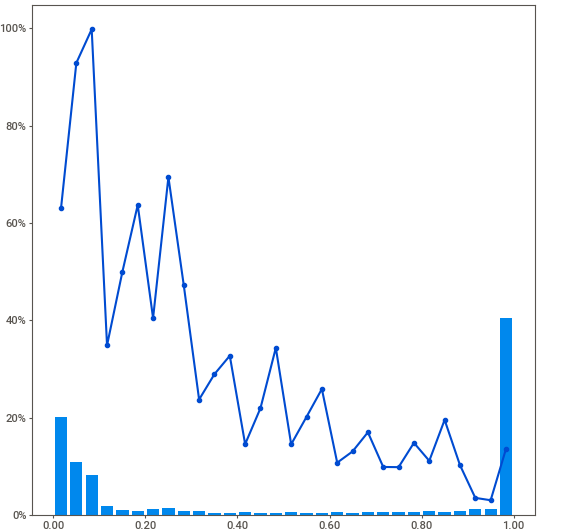
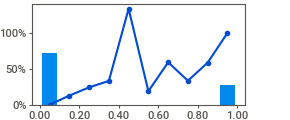
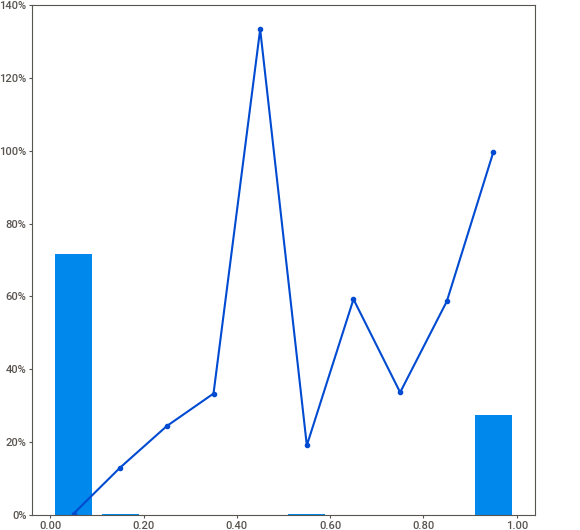
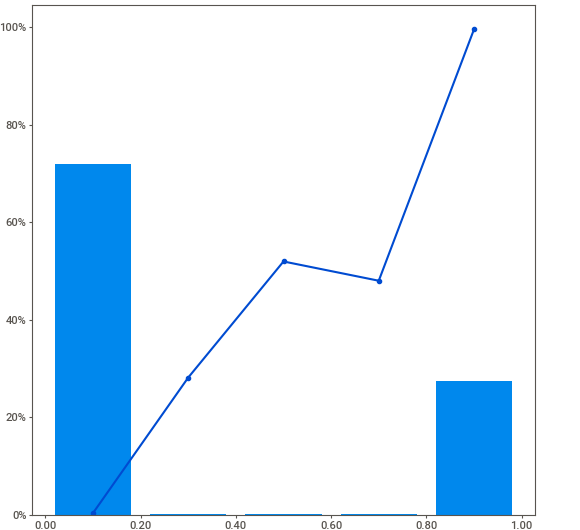
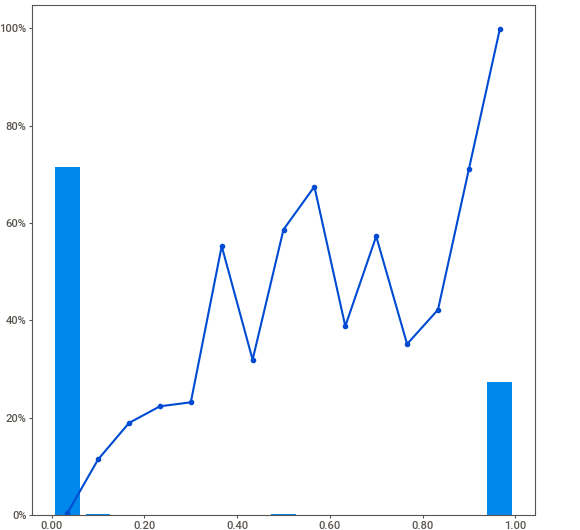
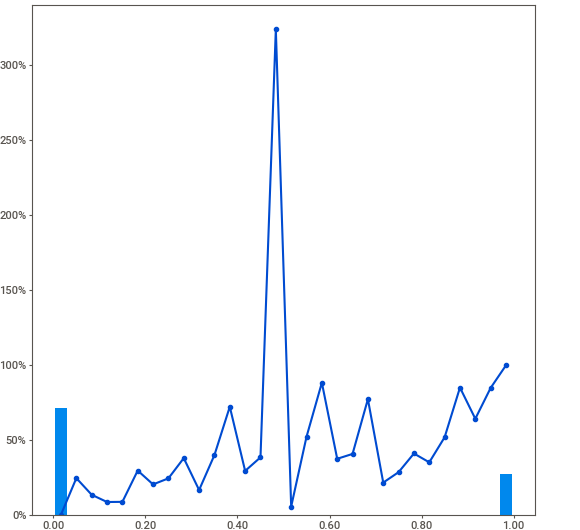
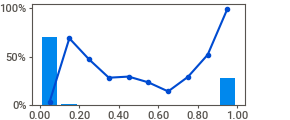
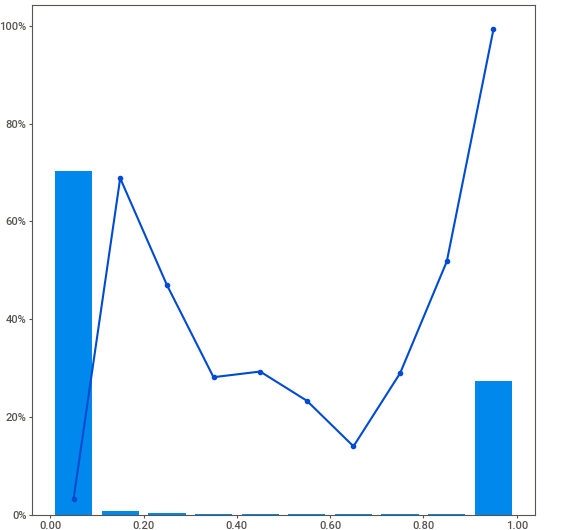
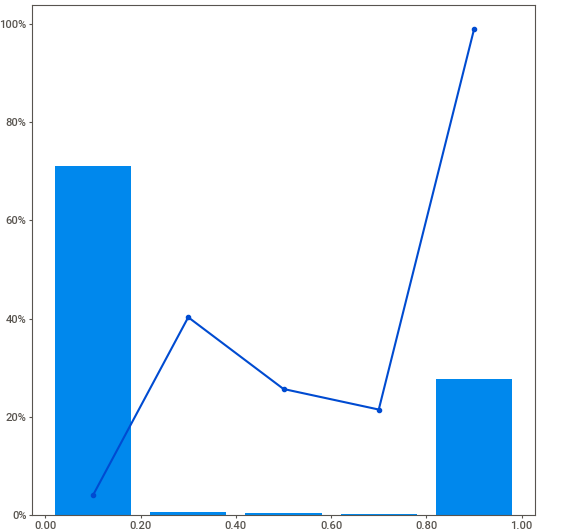
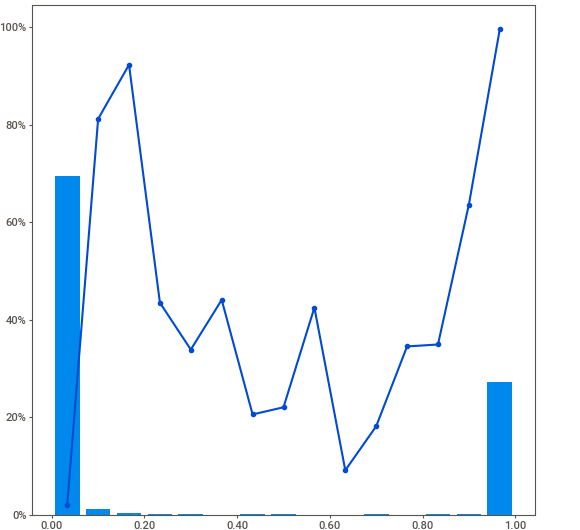
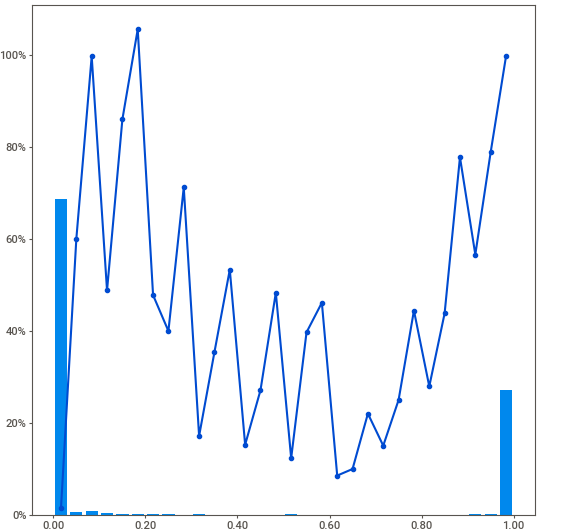
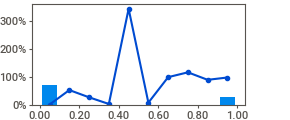
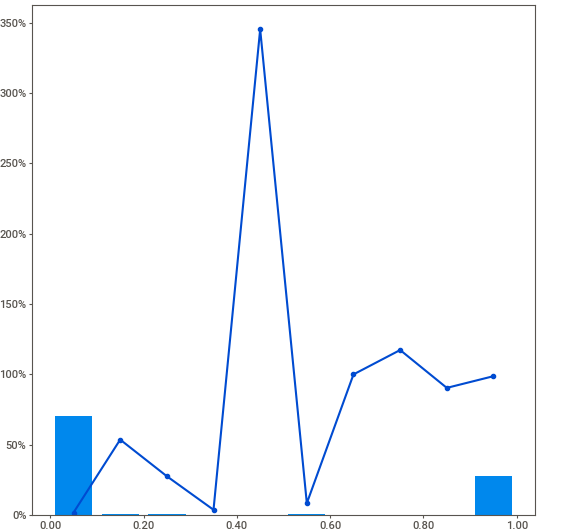
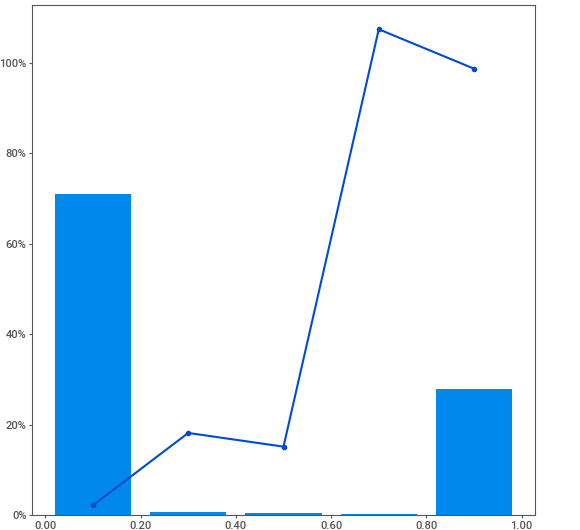
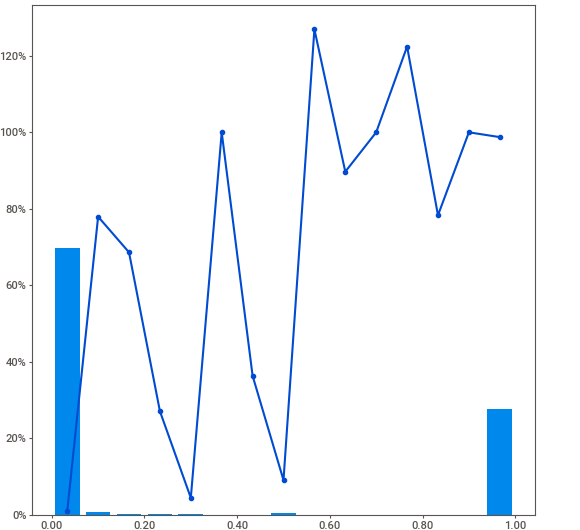
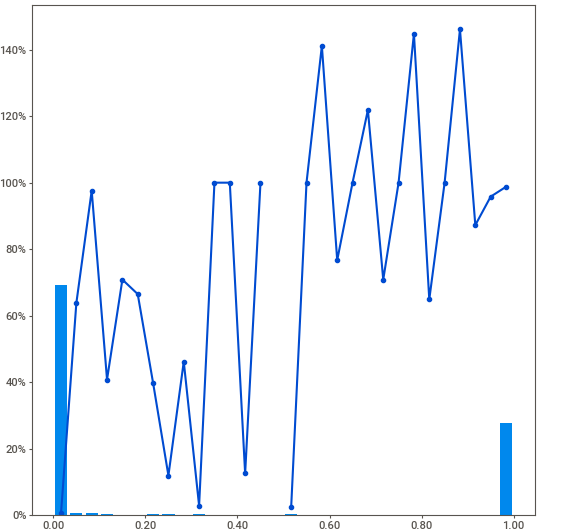
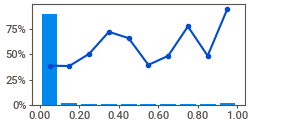
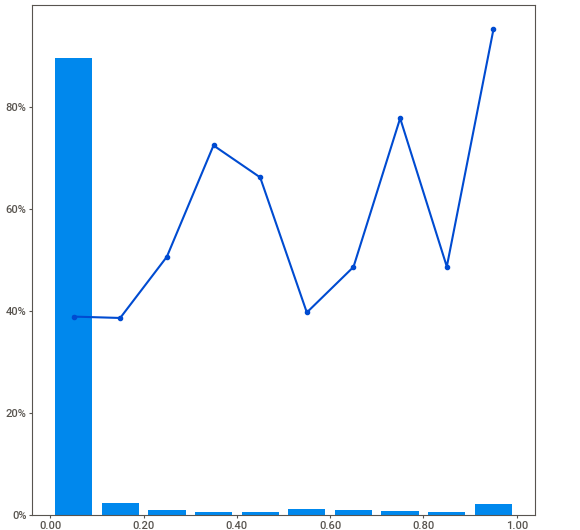
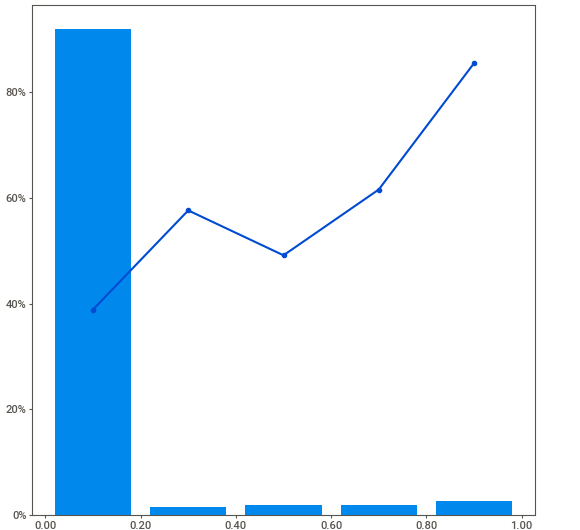
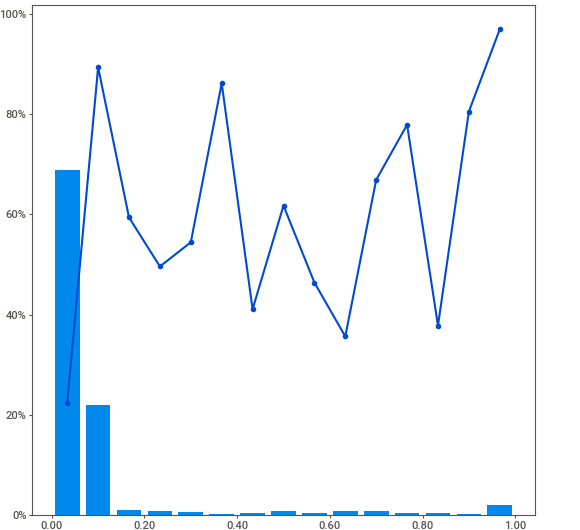
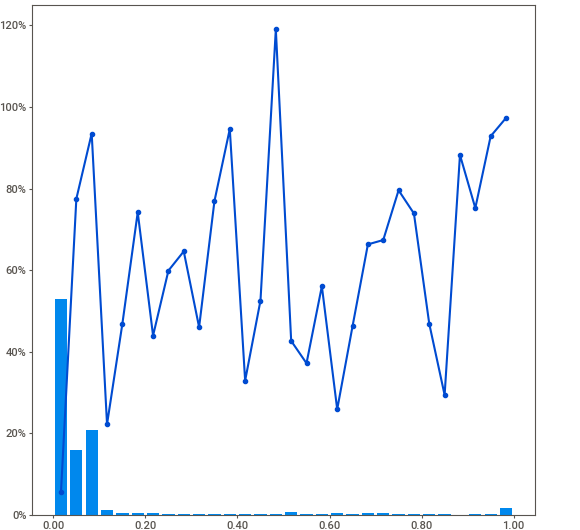
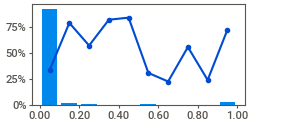
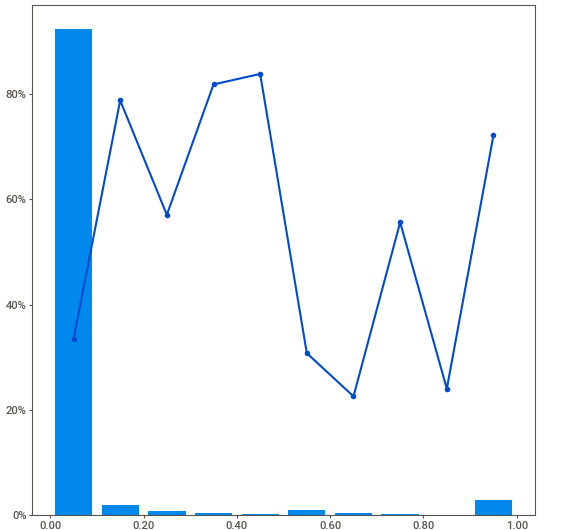
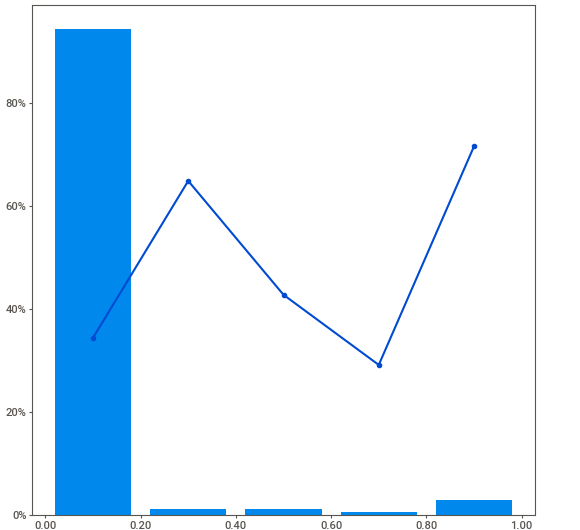
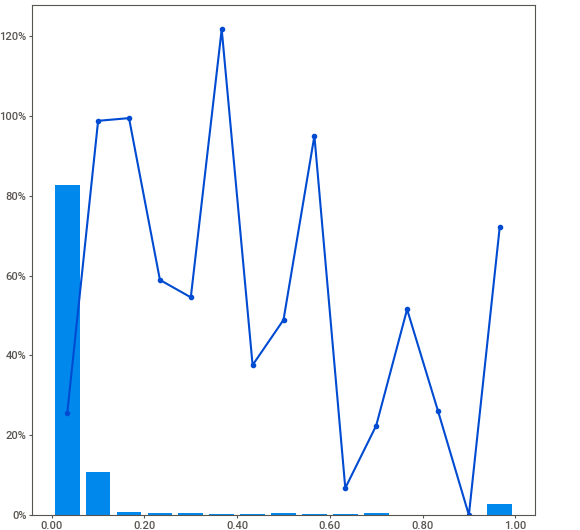
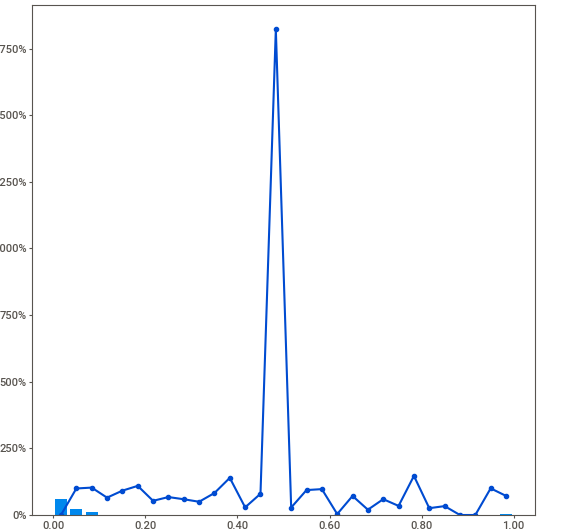
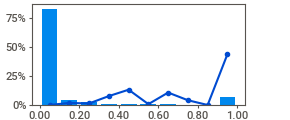
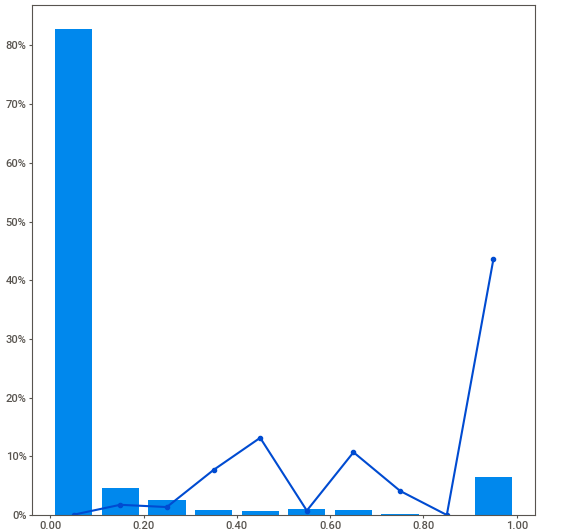
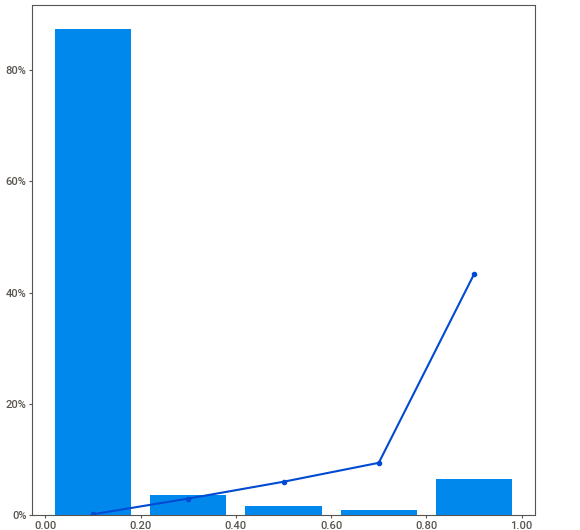
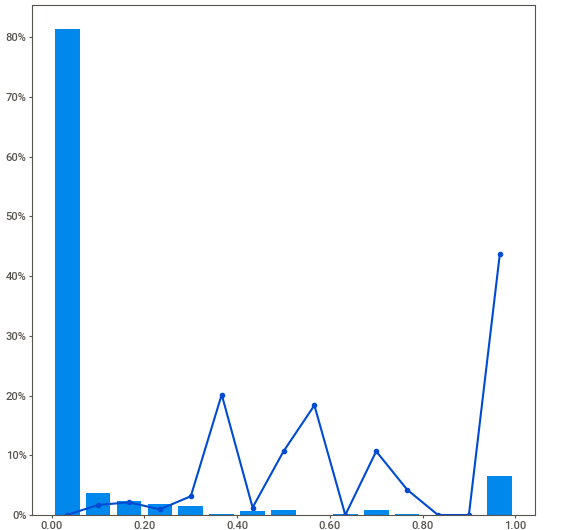
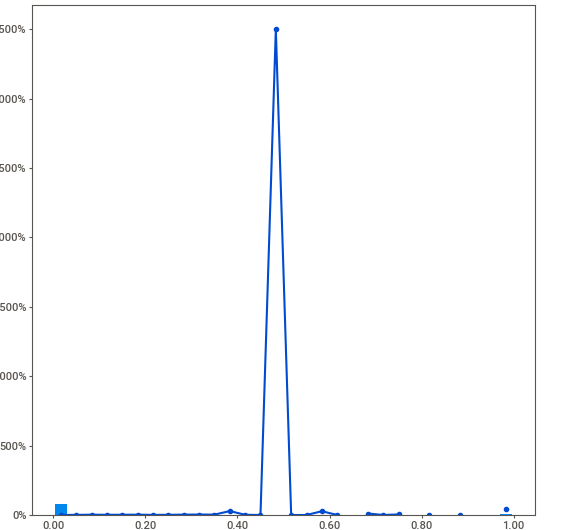
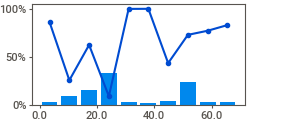
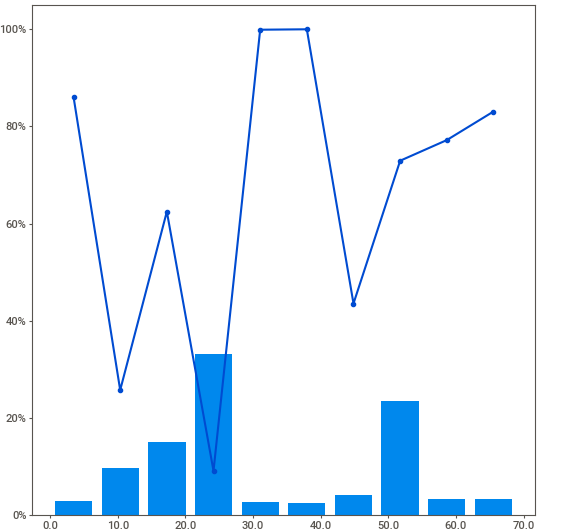
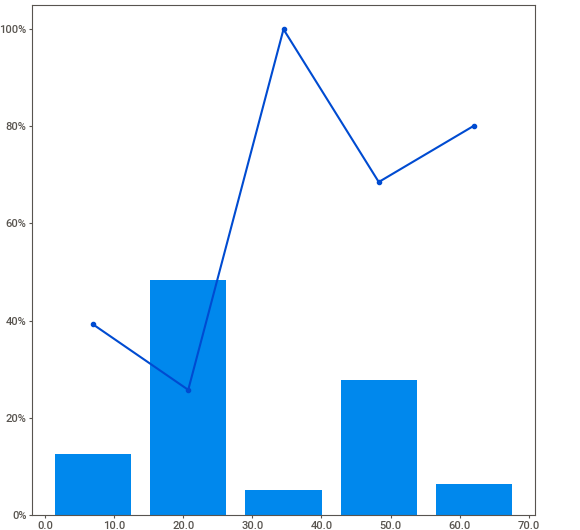
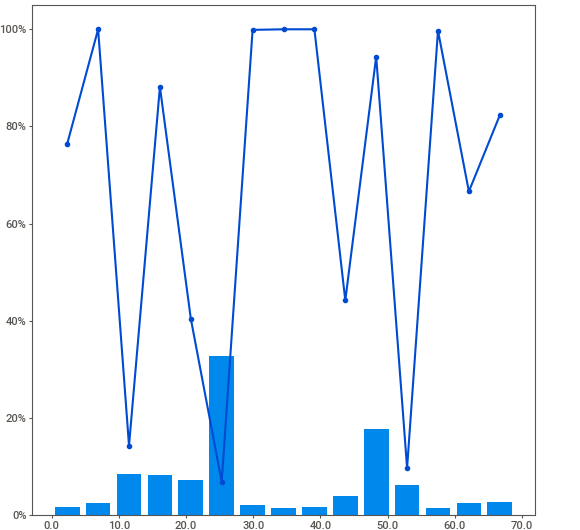
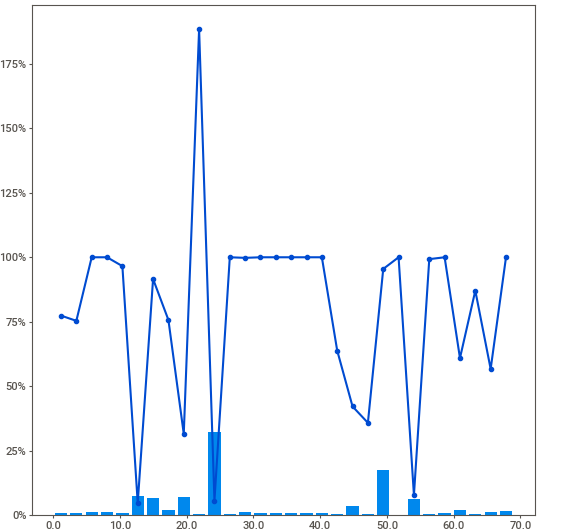
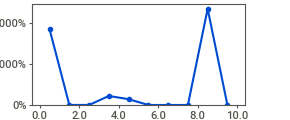
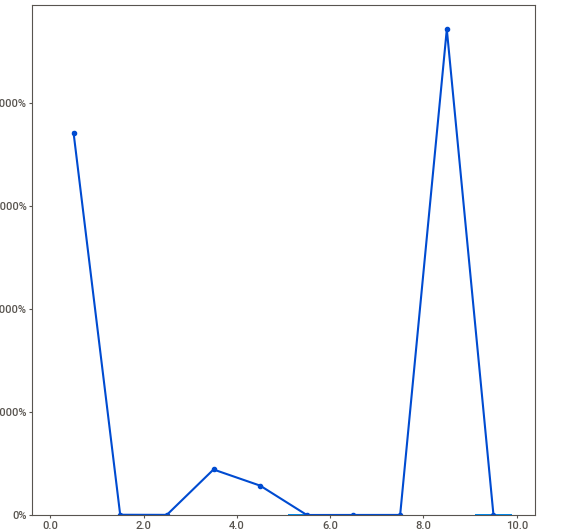
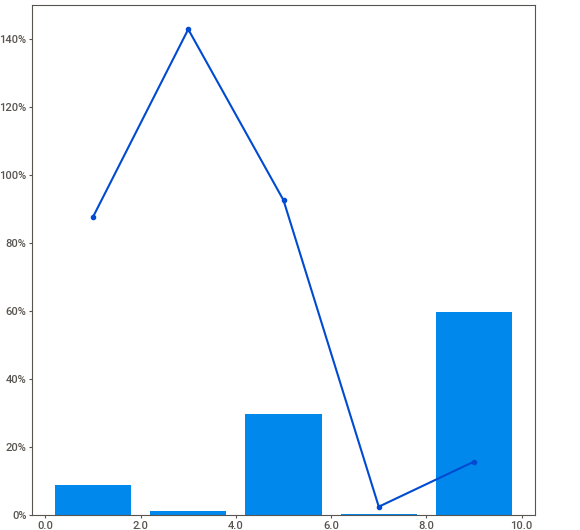
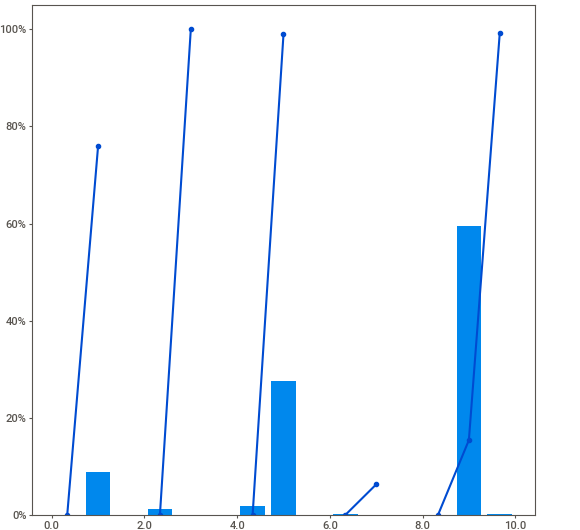
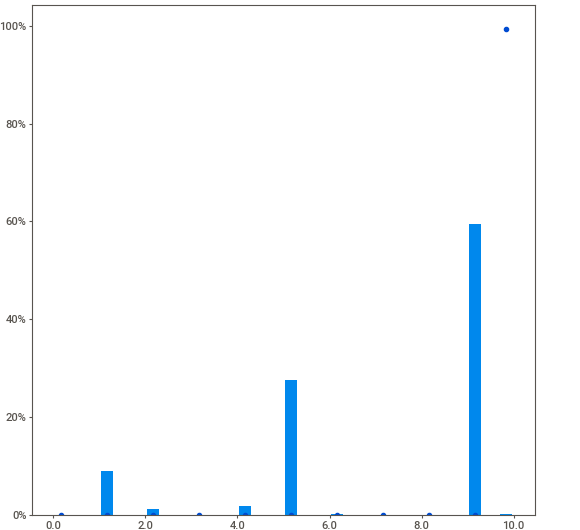
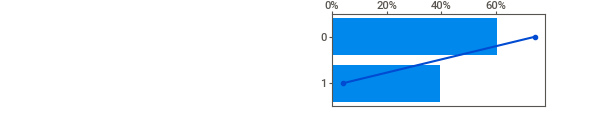
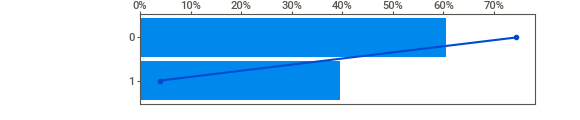
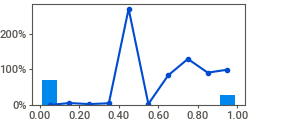
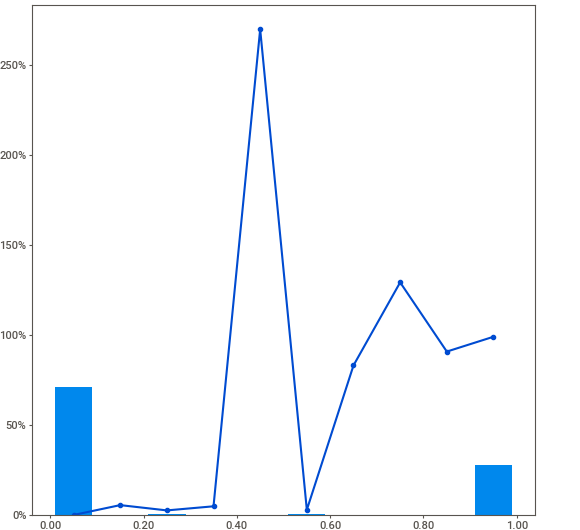
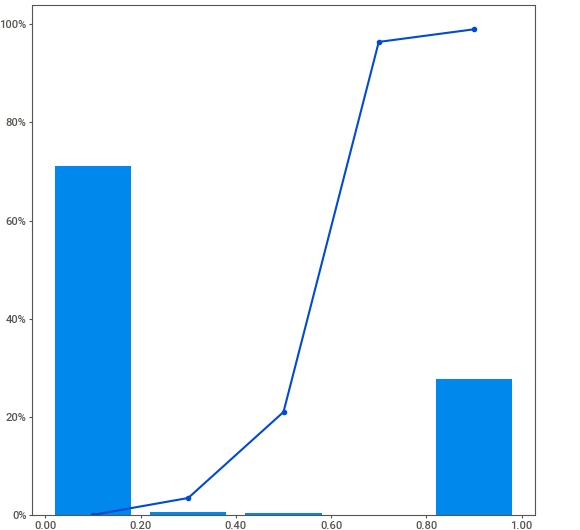
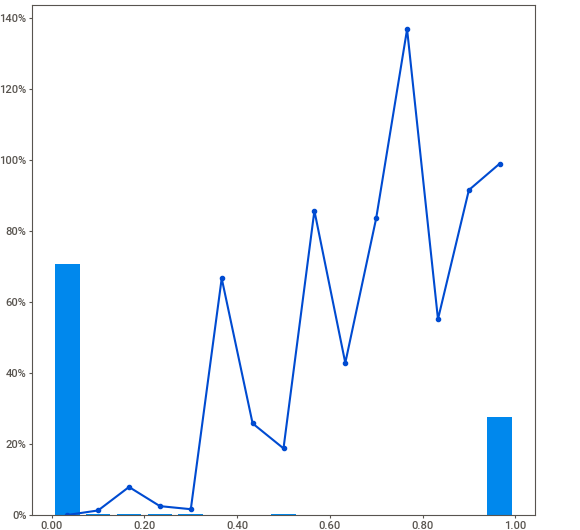
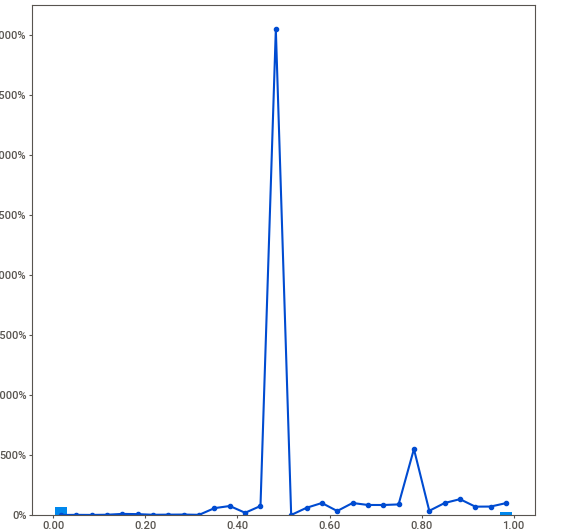
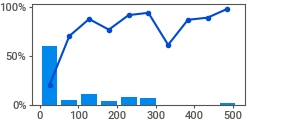
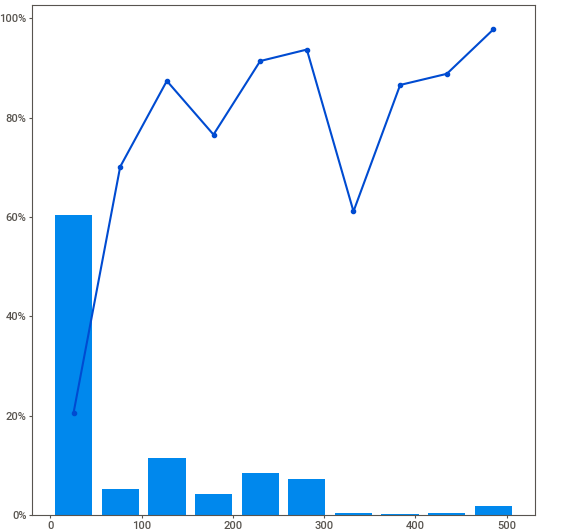
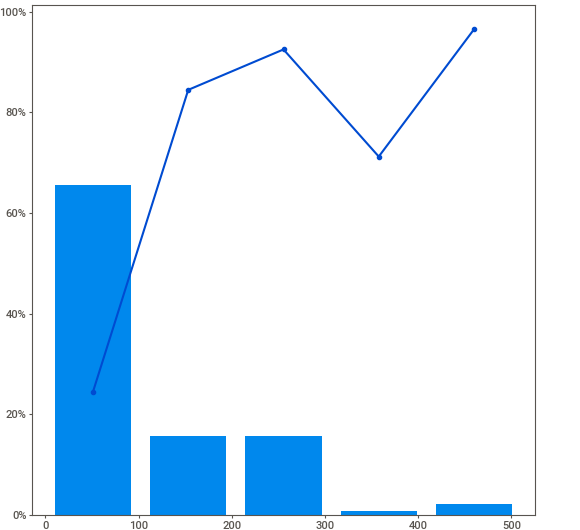
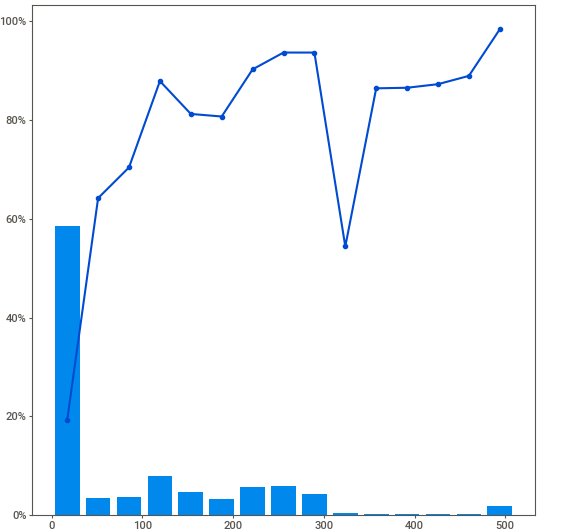
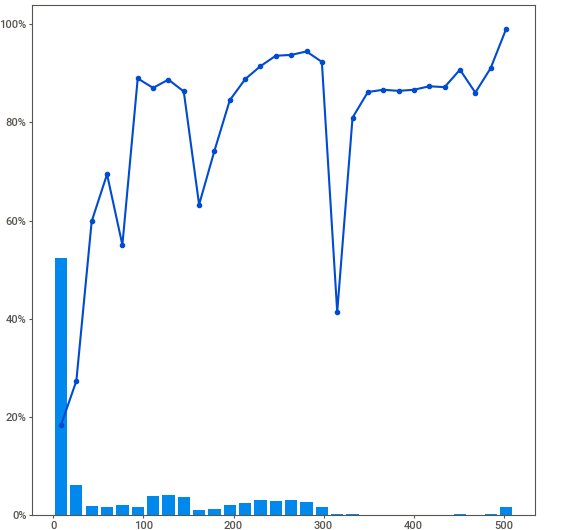
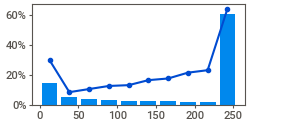
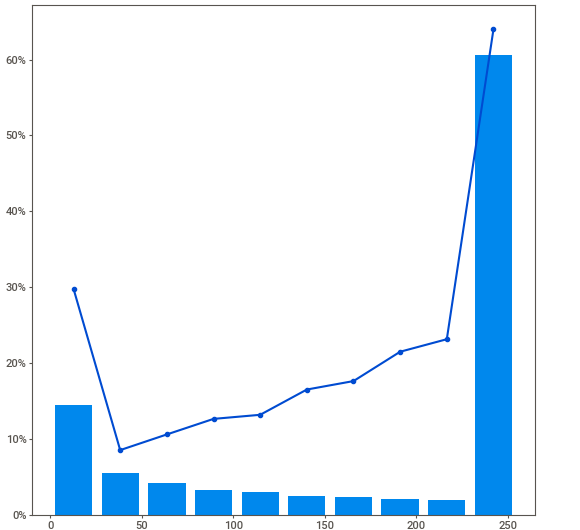
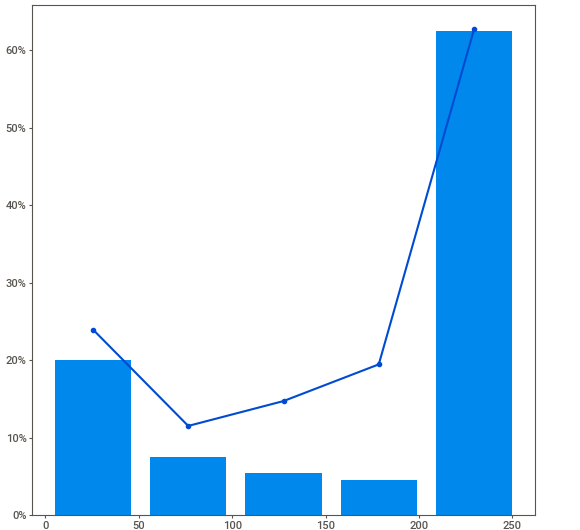
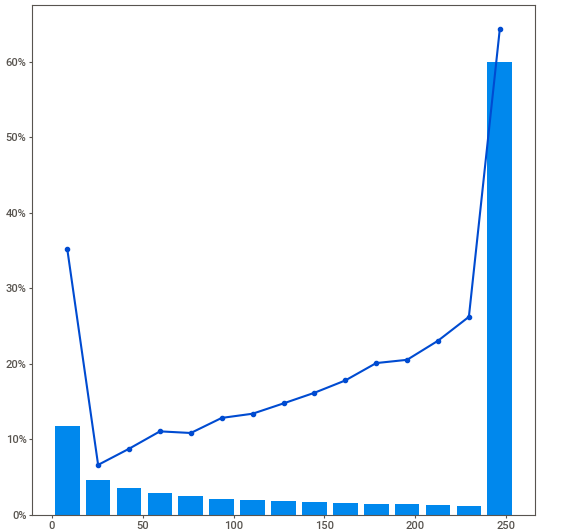
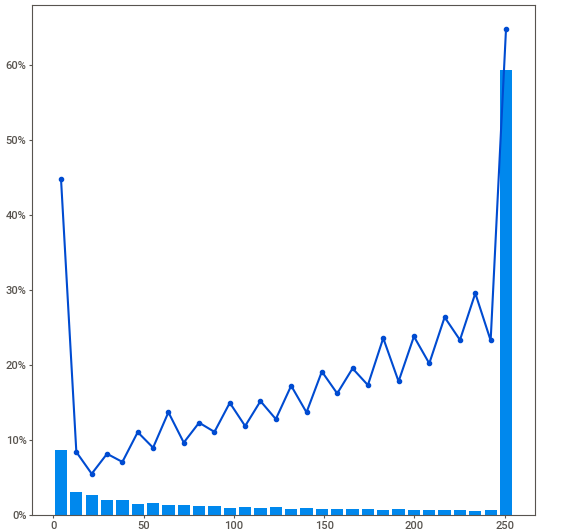
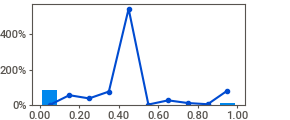
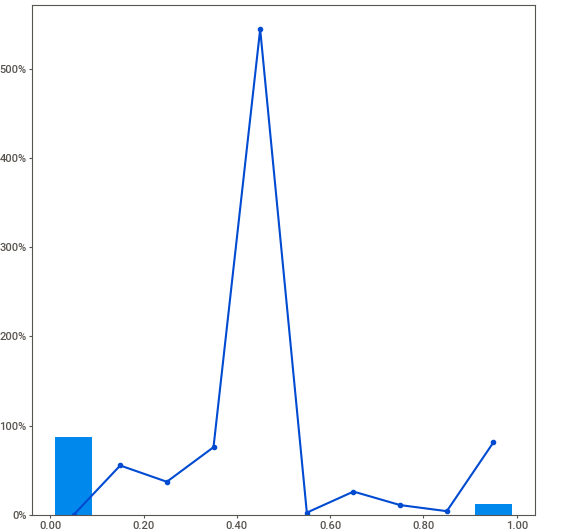
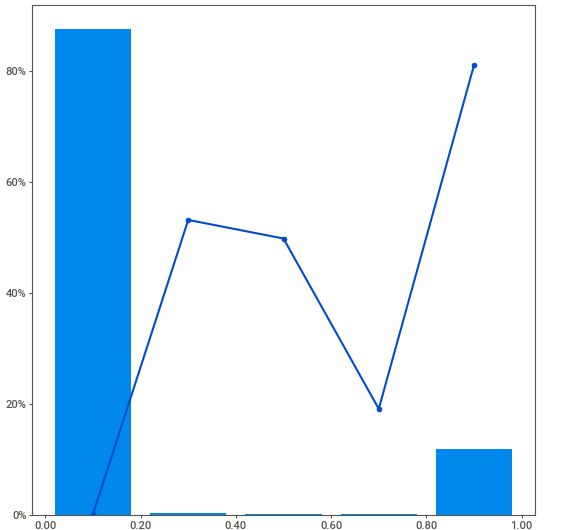
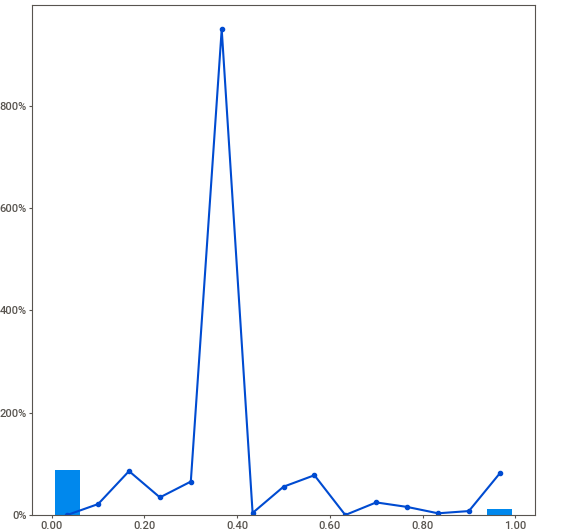
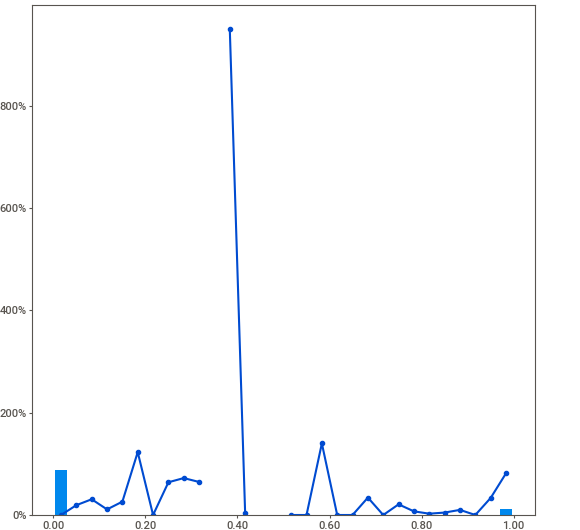
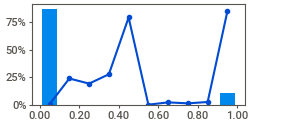
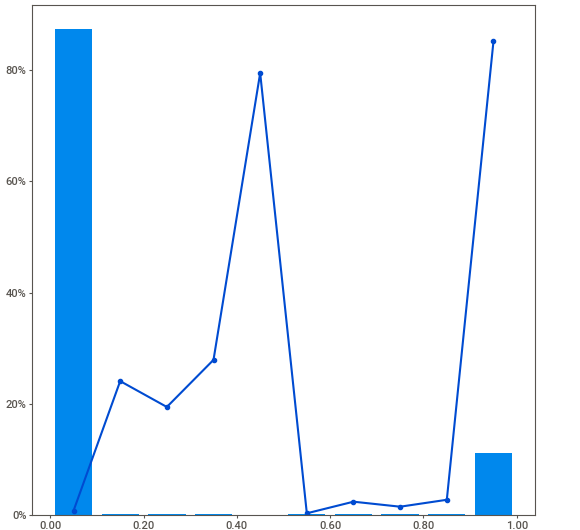
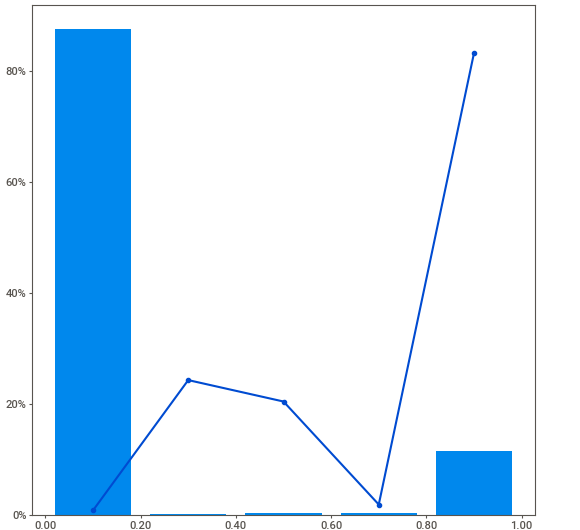
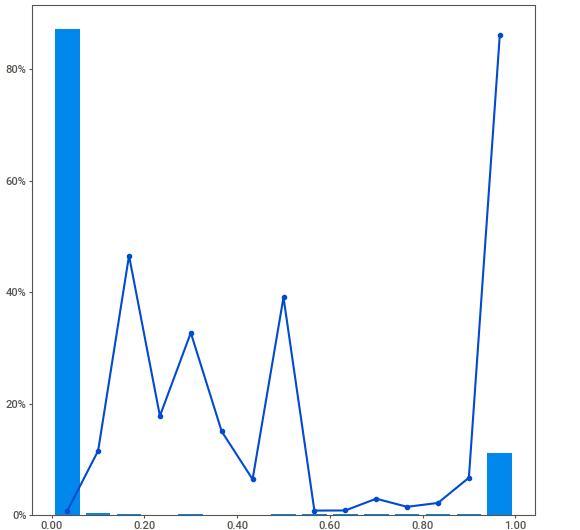
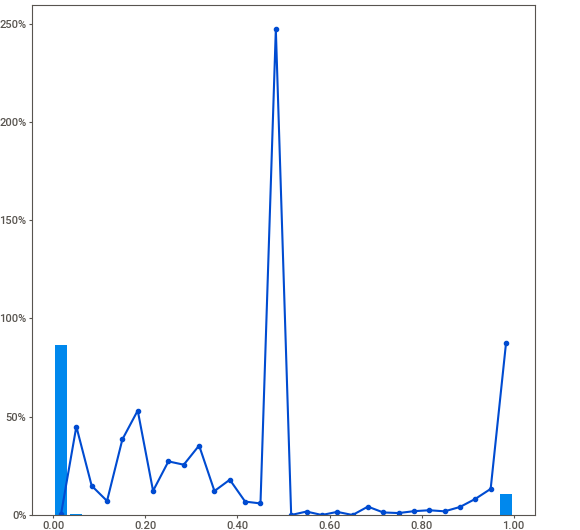
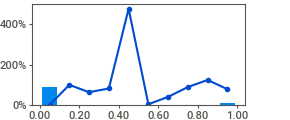
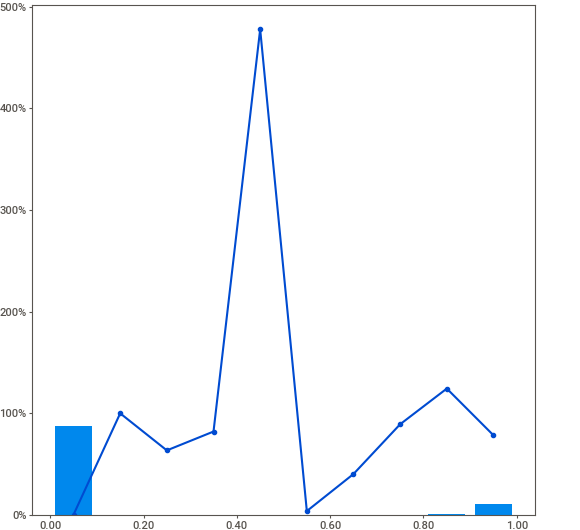
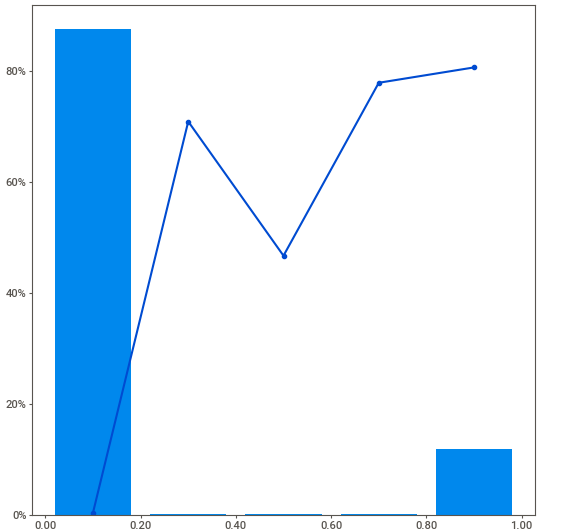
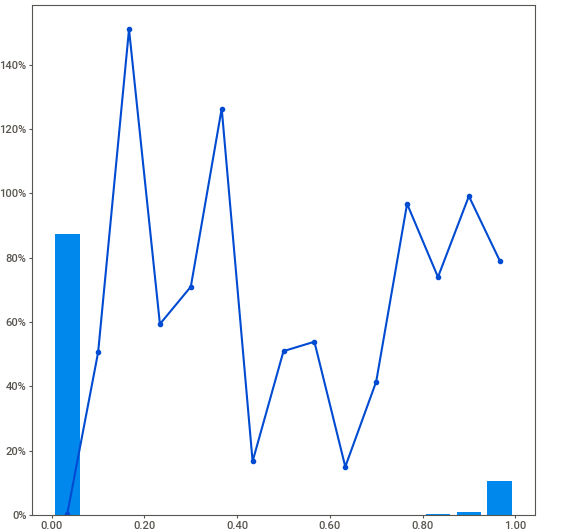
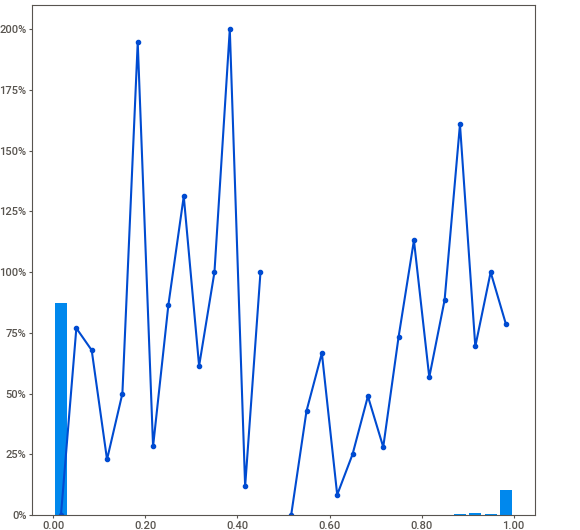
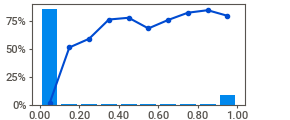
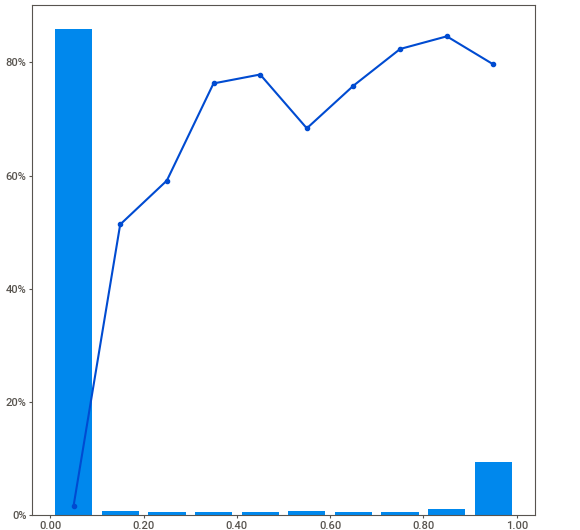
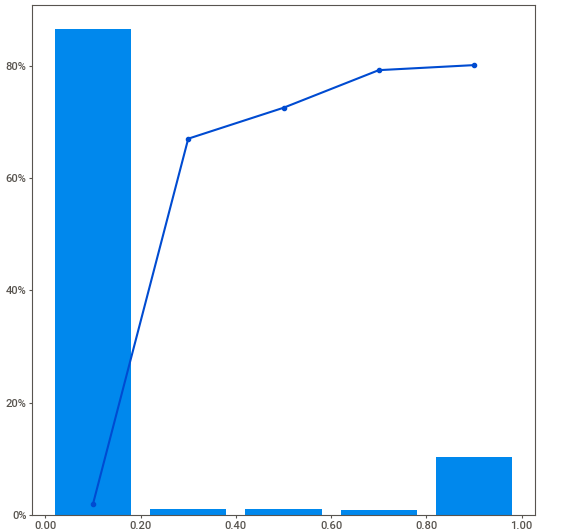
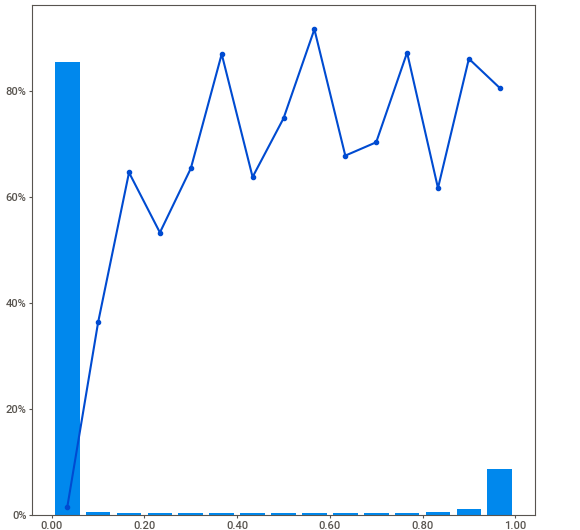
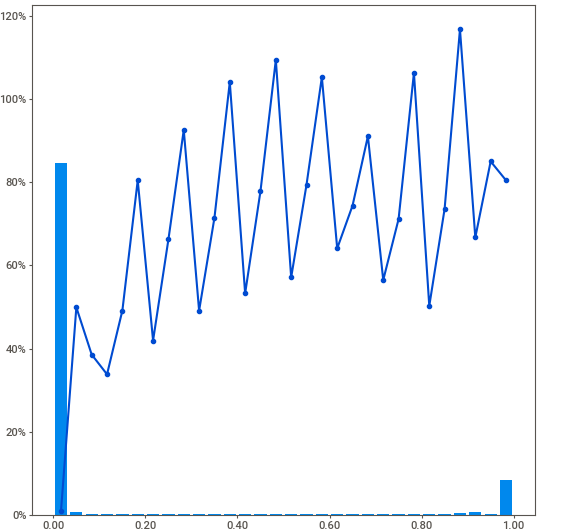
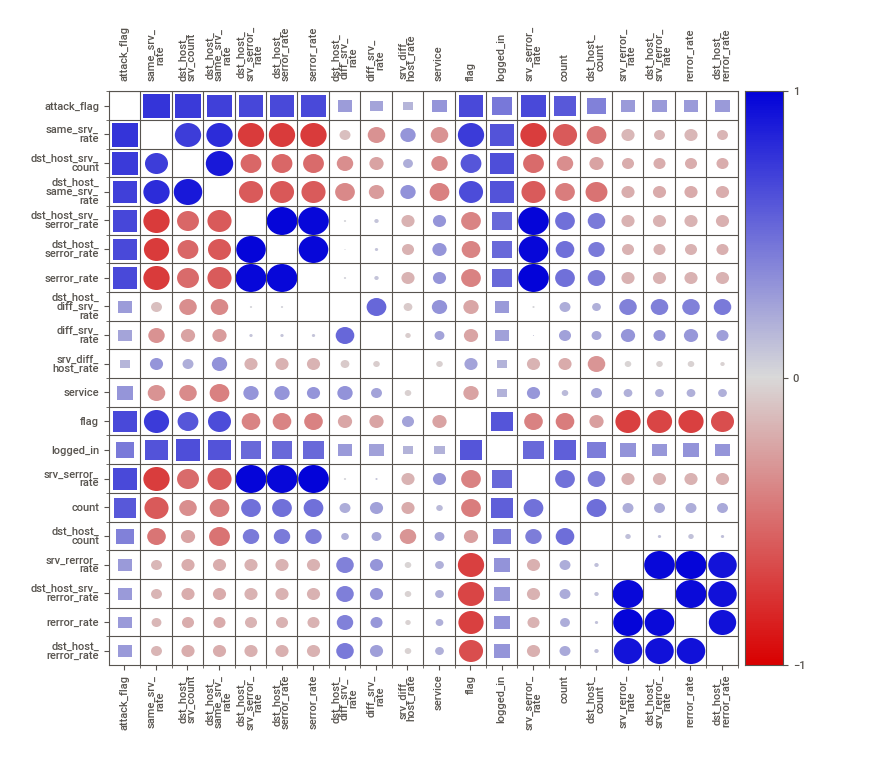
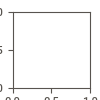

In [125]:
cor_ananlysis2.show_notebook()

In [126]:
X_train,Y_train = df_train_new.drop(['attack_flag'],axis=1),df_train_new['attack_flag']
X_test,Y_test = df_test_new.drop(['attack_flag'],axis=1),df_test_new['attack_flag']


## Treinamento de modelos:

### Modo de explicação:

In [127]:
automl = AutoML(results_path="AutoML_Explain_2",mode="Explain")
automl.fit(X_train,Y_train)

Linear algorithm was disabled.
AutoML directory: AutoML_Explain_2
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
invalid value encountered in true_divide
1_Baseline logloss 0.690754 trained in 1.51 seconds
2_DecisionTree logloss 0.163106 trained in 16.56 seconds
* Step default_algorithms will try to check up to 3 models
Exception while producing SHAP explanations. underflow encountered in nextafter
Continuing ...
3_Default_Xgboost logloss 0.009315 trained in 26.52 seconds
There was an error during 4_Default_NeuralNetwork training.
Please check AutoML_Explain_2/errors.md for details.
5_Default_RandomForest logloss 0.109628 trained in 15.07 seconds
* Step ensemble will try to check up to 1 model
Ensemble 

AutoML(results_path='AutoML_Explain_2')

In [128]:
prediction = automl.predict(X_test)

#### Métricas

In [129]:
precision_score(Y_test, prediction, average='binary')

0.9590519770034026

In [130]:
accuracy_score(Y_test,prediction)

0.7778566359119943

In [131]:
f1_score(Y_test, prediction, average='binary')

0.765499157145533

In [132]:
confusion_matrix(Y_test, prediction)

array([[9362,  349],
       [4659, 8174]])

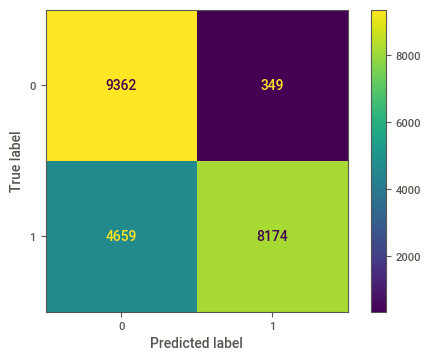

In [133]:
plot_confusion_matrix(automl,X_test,Y_test)

In [134]:
f1_score(Y_test, prediction, average='binary')

0.765499157145533

### Modo de performance:

In [135]:
automl = AutoML(results_path="AutoML_classifier_Perform_last",mode="Perform",explain_level=2)
automl.fit(X_train,Y_train)

Linear algorithm was disabled.
AutoML directory: AutoML_classifier_Perform_last
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 5 models
1_Default_LightGBM logloss 0.010194 trained in 222.99 seconds (1-sample predict time 0.0292 seconds)
Exception while producing SHAP explanations. underflow encountered in nextafter
Continuing ...
Exception while producing SHAP explanations. underflow encountered in nextafter
Continuing ...
Exception while producing SHAP explanations. underflow encountered in nextafter
Continuing ...
Exception while produ

AutoML(explain_level=2, mode='Perform',
       results_path='AutoML_classifier_Perform_last')

In [136]:
prediction = automl.predict(X_test)

#### Métricas

In [137]:
accuracy_score(Y_test,prediction)

0.7634847409510291

In [138]:
f1_score(Y_test, prediction, average='binary')

0.7455378448029015

In [139]:
precision_score(Y_test, prediction, average='binary')

0.9618273611624184

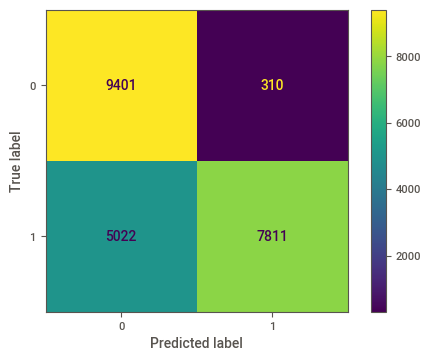

In [140]:
plot_confusion_matrix(automl,X_test,Y_test)

### Modo de performance 2:

In [141]:
automl = AutoML(results_path="AutoML_classifier_Perform",mode="Perform")
automl.fit(X_train,Y_train)

#### Métricas

In [142]:
prediction = automl.predict(X_test)

In [143]:
accuracy_score(Y_test,prediction)

0.7634847409510291

In [144]:
f1_score(Y_test, prediction, average='binary')

0.7455378448029015

In [145]:
precision_score(Y_test, prediction, average='binary')

0.9618273611624184

In [146]:
confusion_matrix(Y_test, prediction)

array([[9401,  310],
       [5022, 7811]])

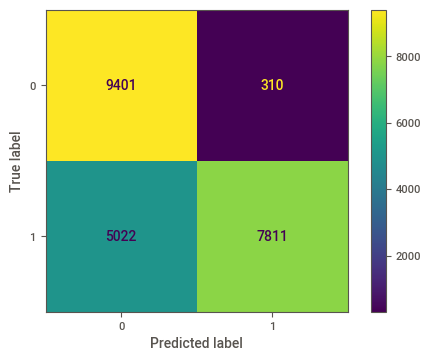

In [147]:
plot_confusion_matrix(automl,X_test,Y_test)

### Teste com apenas o modelo LightGBM:

AutoML directory: AutoML_classifier_lightgbm
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['LightGBM']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_LightGBM logloss 0.009671 trained in 62.71 seconds
* Step ensemble will try to check up to 1 model
AutoML fit time: 68.88 seconds
AutoML best model: 1_Default_LightGBM


AutoML(algorithms=['LightGBM'], explain_level=2,
       results_path='AutoML_classifier_lightgbm')

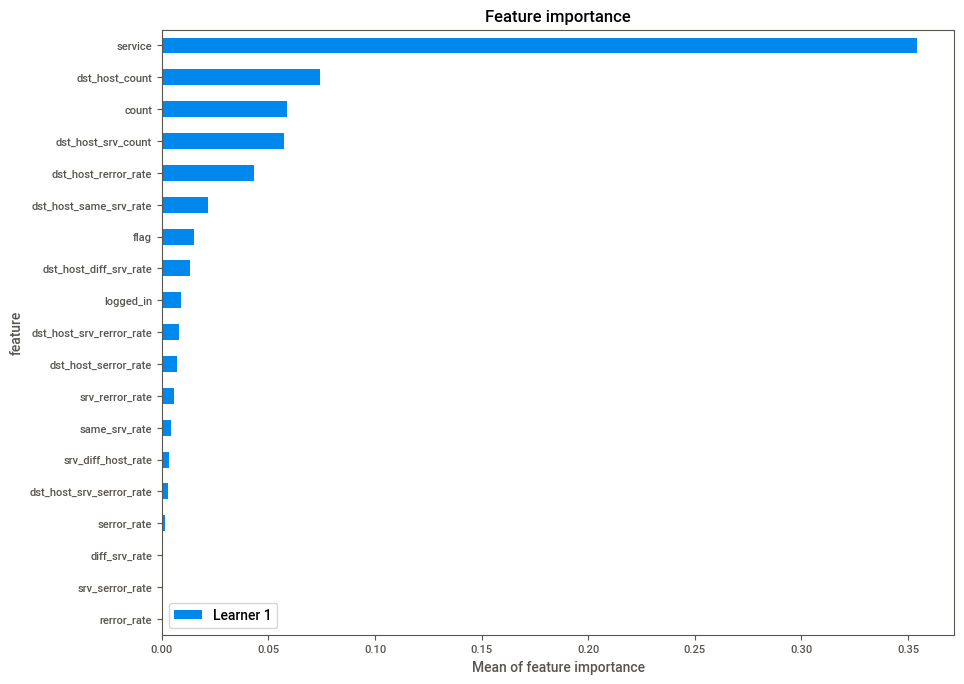

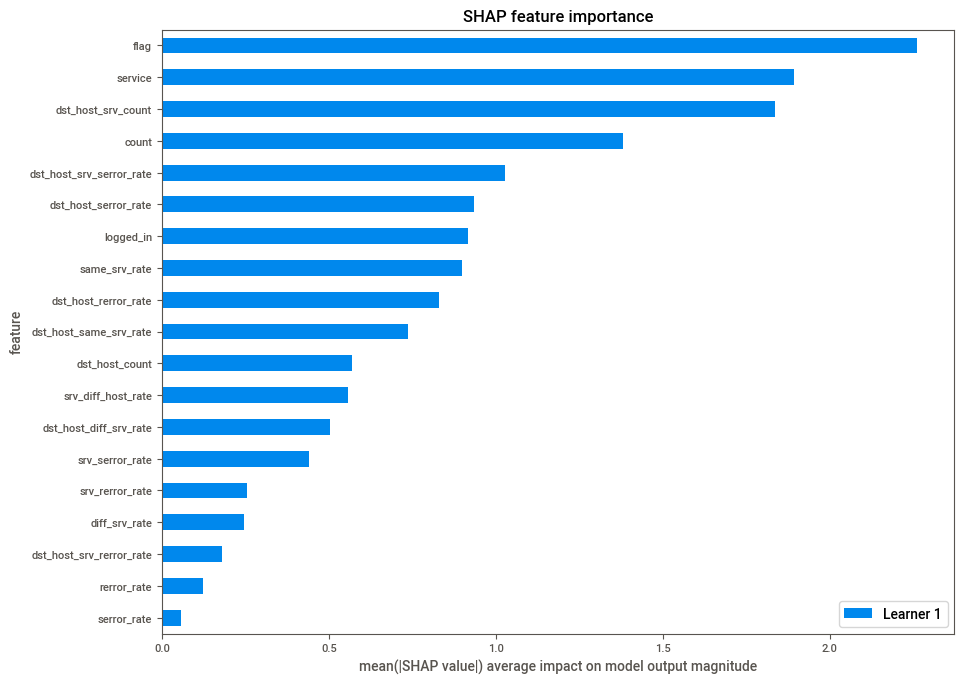

In [149]:
automl = AutoML(results_path="AutoML_classifier_lightgbm", algorithms=["LightGBM"], explain_level=2)
automl.fit(X_train,Y_train)

In [150]:
f1_score(Y_test, prediction, average='binary')

0.7455378448029015

#### Métricas:

In [151]:
prediction = automl.predict(X_test)
accuracy_score(Y_test,prediction)

0.769694819020582

In [152]:
f1_score(Y_test, prediction, average='binary')

0.7561067267944381

In [153]:
precision_score(Y_test, prediction, average='binary')

0.9518628030751035

In [154]:
confusion_matrix(Y_test, prediction)

array([[9304,  407],
       [4785, 8048]])

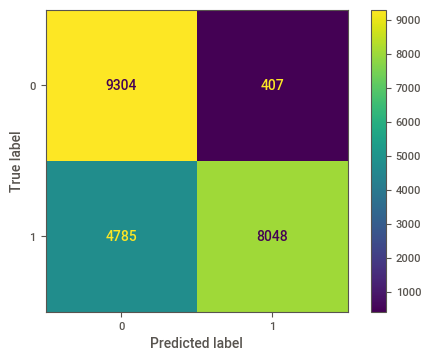

In [155]:
plot_confusion_matrix(automl,X_test,Y_test)

### Teste com o algoritmo de Random Forest:

AutoML directory: AutoML_classifier_RandomForest_2
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Random Forest']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_RandomForest logloss 0.108899 trained in 25.44 seconds
* Step ensemble will try to check up to 1 model
AutoML fit time: 31.89 seconds
AutoML best model: 1_Default_RandomForest


AutoML(algorithms=['Random Forest'], explain_level=2,
       results_path='AutoML_classifier_RandomForest_2')

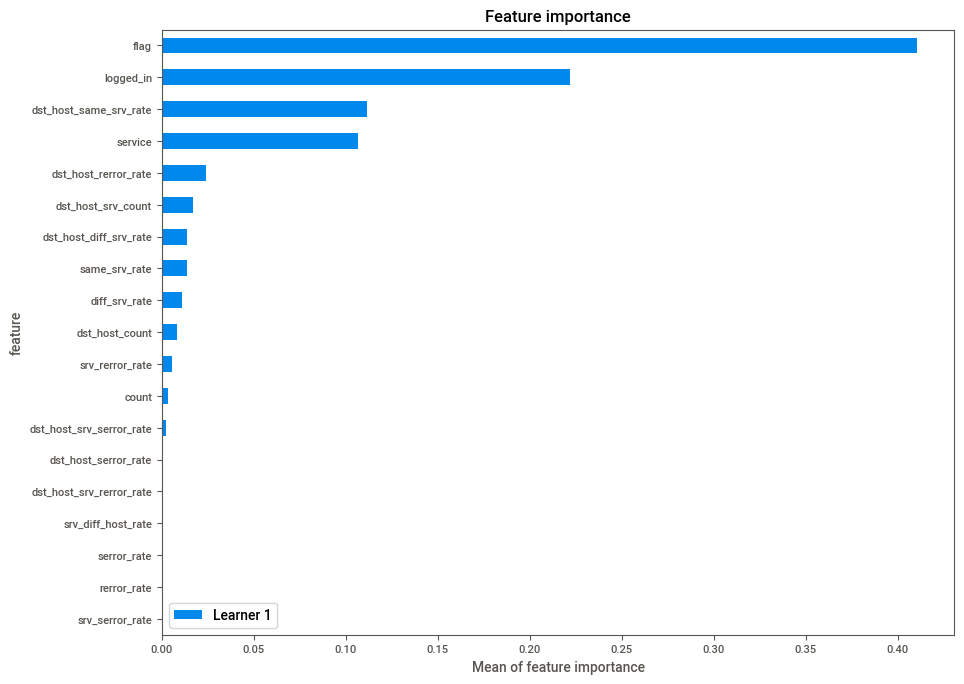

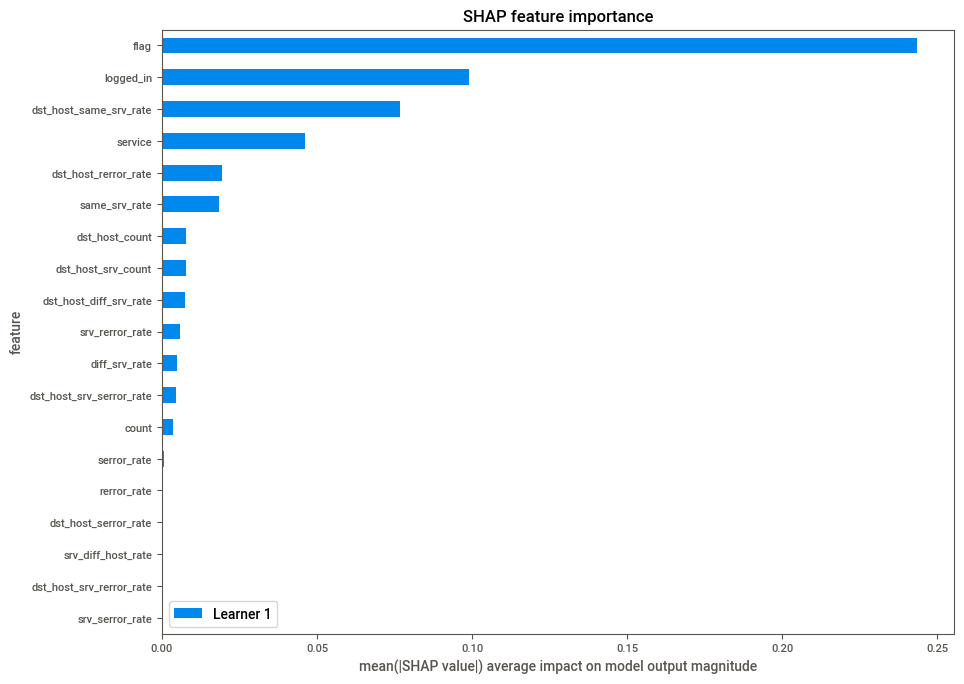

In [156]:
automl = AutoML(results_path="AutoML_classifier_RandomForest_2", algorithms=["Random Forest"], explain_level=2)
automl.fit(X_train,Y_train)

#### Métricas:

In [157]:
prediction = automl.predict(X_test)
accuracy_score(Y_test,prediction)

0.7692955997161107

In [158]:
f1_score(Y_test, prediction, average='binary')

0.7499158532480646

In [159]:
precision_score(Y_test, prediction, average='binary')

0.979156202913109

In [160]:
f1_score(Y_test, prediction, average='binary')

0.7499158532480646

In [161]:
confusion_matrix(Y_test, prediction)

array([[9545,  166],
       [5035, 7798]])

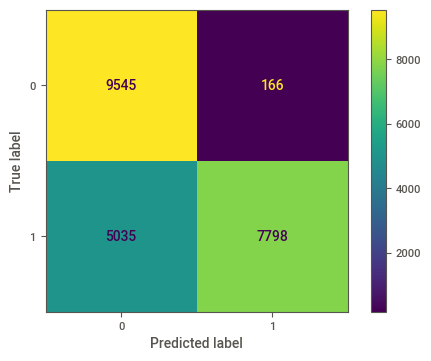

In [162]:
plot_confusion_matrix(automl,X_test,Y_test)

### Comparação entre os algoritmos de Random Forest e Light GBM:

In [163]:
automl = AutoML(results_path="AutoML_classifier_Comparação_2", algorithms=["Random Forest", "LightGBM"], explain_level=2)
automl.fit(X_train,Y_train)

AutoML directory: AutoML_classifier_Comparação_2
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Random Forest', 'LightGBM']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 2 models
1_Default_LightGBM logloss 0.009671 trained in 59.86 seconds
2_Default_RandomForest logloss 0.10978 trained in 12.06 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.009671 trained in 5.26 seconds
AutoML fit time: 86.1 seconds
AutoML best model: 1_Default_LightGBM


AutoML(algorithms=['Random Forest', 'LightGBM'], explain_level=2,
       results_path='AutoML_classifier_Comparação_2')

#### Métricas:

In [164]:
prediction = automl.predict(X_test)
accuracy_score(Y_test,prediction)

0.769694819020582

In [165]:
f1_score(Y_test, prediction, average='binary')

0.7561067267944381

In [166]:
confusion_matrix(Y_test, prediction)

array([[9304,  407],
       [4785, 8048]])

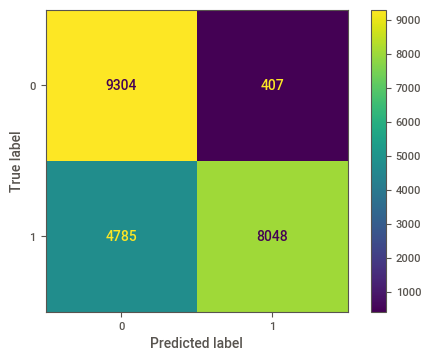

In [167]:
plot_confusion_matrix(automl,X_test,Y_test)